# Load packages and functions

In [1]:
import pandas as pd
import numpy as np
import os
from collections import defaultdict
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import palettable
import plotly_express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotnine import *
from sklearn.metrics import mutual_info_score, accuracy_score, roc_curve, auc, f1_score
import sklearn.metrics as sk
import scanpy as sc
import anndata as ad
from funkyheatmappy import funkyheatmappy
from typing import Any, Callable, Optional, Union
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.plots import bar
from pysankey2.datasets import load_fruits
from pysankey2.utils import setColorConf
from pysankey2 import Sankey
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist
from scipy import stats
from rogi import RoughnessIndex
import torch
plt.rcParams['font.family'] = 'sans-serif'

In [2]:
def accuracy_for_unkonw(preds, output_ratio, labels, number_unkonw, cut_off_ratio=0):
    total_konw_cells=len(labels)-number_unkonw
    index = np.where(np.array(output_ratio) > cut_off_ratio)[0]

    labels = labels[index]
    preds = preds[index]

    correct=sum(preds==labels)

    # print("correct, total_konw_cells: ", correct, total_konw_cells)
    return correct / total_konw_cells


def get_FPR(unknown_cell, FPR=0.05):
    number_unkonw = len(unknown_cell)
    cut_off_ratio = sorted(unknown_cell, reverse=True)[int(number_unkonw*FPR)]

    # print("cut_off_ratio value: ", cut_off_ratio)
    return cut_off_ratio, number_unkonw

In [3]:
# Ref: https://github.com/wetliu/energy_ood/blob/master/utils/display_results.py
def stable_cumsum(arr, rtol=1e-05, atol=1e-08):
    """Use high precision for cumsum and check that final value matches sum
    Parameters
    ----------
    arr : array-like
        To be cumulatively summed as flat
    rtol : float
        Relative tolerance, see ``np.allclose``
    atol : float
        Absolute tolerance, see ``np.allclose``
    """
    out = np.cumsum(arr, dtype=np.float64)
    expected = np.sum(arr, dtype=np.float64)
    if not np.allclose(out[-1], expected, rtol=rtol, atol=atol):
        raise RuntimeError('cumsum was found to be unstable: '
                           'its last element does not correspond to sum')
    return out

def fpr_and_fdr_at_recall(y_true, y_score, recall_level=0.95, pos_label=None):
    classes = np.unique(y_true)
    if (pos_label is None and
            not (np.array_equal(classes, [0, 1]) or
                 np.array_equal(classes, [-1, 1]) or
                 np.array_equal(classes, [0]) or
                 np.array_equal(classes, [-1]) or
                 np.array_equal(classes, [1]))):
        raise ValueError("Data is not binary and pos_label is not specified")
    elif pos_label is None:
        pos_label = 1.

    # make y_true a boolean vector
    y_true = (y_true == pos_label)

    # sort scores and corresponding truth values
    desc_score_indices = np.argsort(y_score, kind="mergesort")[::-1]
    y_score = y_score[desc_score_indices]
    y_true = y_true[desc_score_indices]

    # y_score typically has many tied values. Here we extract
    # the indices associated with the distinct values. We also
    # concatenate a value for the end of the curve.
    distinct_value_indices = np.where(np.diff(y_score))[0]
    threshold_idxs = np.r_[distinct_value_indices, y_true.size - 1]

    # accumulate the true positives with decreasing threshold
    tps = stable_cumsum(y_true)[threshold_idxs]
    fps = 1 + threshold_idxs - tps      # add one because of zero-based indexing

    thresholds = y_score[threshold_idxs]

    recall = tps / tps[-1]

    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)      # [last_ind::-1]
    recall, fps, tps, thresholds = np.r_[recall[sl], 1], np.r_[fps[sl], 0], np.r_[tps[sl], 0], thresholds[sl]

    cutoff = np.argmin(np.abs(recall - recall_level))

    return fps[cutoff] / (np.sum(np.logical_not(y_true)))   # , fps[cutoff]/(fps[cutoff] + tps[cutoff])


def get_measures(y_true, y_pred, recall_level=0.95):
    auroc = sk.roc_auc_score(y_true, y_pred)
    aupr = sk.average_precision_score(y_true, y_pred)
    fpr = fpr_and_fdr_at_recall(y_true, y_pred, recall_level)

    return auroc, aupr, fpr

In [4]:
def dominates(x, y):
    """
    检查解x是否支配解y
    """
    if (x >= y).all() and not (x == y).all():
        return True
    else:
        return False
        
def non_dominated_sort(population):
    # model_name: metrics
    fronts = [[]]  # 记录非支配前沿
    # S = []  # 支配的个体列表 
    # n_dominated = np.zeros(len(population))  # 每个个体被支配的个体数量
    S = defaultdict(list)
    n_dominated = defaultdict(int)
    
    for p in population.keys():
        # S.append([])  # 初始化支配个体的列表
        for q in population.keys():
            if dominates(population[p], population[q]):
                S[p].append(q)
            elif dominates(population[q], population[p]):
                n_dominated[p] += 1

        if n_dominated[p] == 0:
            fronts[0].append(p)  # p 是第一前沿的一部分

    i = 0
    while fronts[i]:
        Q = []  # 下一前沿
        for p in fronts[i]:
            for q in S[p]:
                n_dominated[q] -= 1
                if n_dominated[q] == 0:
                    Q.append(q)  # q 是下一前沿的一部分
        i += 1
        fronts.append(Q)  # 记录下一前沿

    return fronts[:-1]  # 返回前沿（去掉空列表）

In [37]:
np.random.seed(0)
scores = np.random.rand(10, 2)
population = {}
for i in range(10):
    population[i] = scores[i]

fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: [4, 5, 6, 9]
Front 2: [3, 0, 1]
Front 3: [8, 2]
Front 4: [7]


In [38]:
population

{0: array([0.5488135 , 0.71518937]),
 1: array([0.60276338, 0.54488318]),
 2: array([0.4236548 , 0.64589411]),
 3: array([0.43758721, 0.891773  ]),
 4: array([0.96366276, 0.38344152]),
 5: array([0.79172504, 0.52889492]),
 6: array([0.56804456, 0.92559664]),
 7: array([0.07103606, 0.0871293 ]),
 8: array([0.0202184 , 0.83261985]),
 9: array([0.77815675, 0.87001215])}

In [ ]:
_METRIC_TYPE = "Metric Type"
_AGGREGATE_SCORE = "Aggregate score"
def plot_results_table(
    df, min_max_scale: bool = True, show: bool = True, save_dir: Optional[str] = None
) -> Table:
    """Plot the benchmarking results.

    Parameters
    ----------
    min_max_scale
        Whether to min max scale the results.
    show
        Whether to show the plot.
    save_dir
        The directory to save the plot to. If `None`, the plot is not saved.
    """
    # num_embeds = len(self._embedding_obsm_keys)
    num_embeds = len(df.columns)-1
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)
    # df = self.get_results(min_max_scale=min_max_scale)
    # Do not want to plot what kind of metric it is
    plot_df = df.drop(_METRIC_TYPE, axis=0)
    # Sort by total score
    plot_df = plot_df.sort_values(by="overall", ascending=False).astype(np.float64)
    plot_df["Method"] = plot_df.index

    # Split columns by metric type, using df as it doesn't have the new method col
    score_cols = df.columns[df.loc[_METRIC_TYPE] == _AGGREGATE_SCORE]
    other_cols = df.columns[df.loc[_METRIC_TYPE] != _AGGREGATE_SCORE]
    column_definitions = [
        ColumnDefinition("Method", width=1.5, textprops={"ha": "left", "weight": "bold"}),
    ]
    # Circles for the metric values
    column_definitions += [
        ColumnDefinition(
            col,
            title=col.replace(" ", "\n", 1),
            width=1,
            textprops={
                "ha": "center",
                "bbox": {"boxstyle": "circle", "pad": 0.25},
            },
            cmap=cmap_fn(plot_df[col]),
            group=df.loc[_METRIC_TYPE, col],
            formatter="{:.3f}",
        )
        for i, col in enumerate(other_cols)
    ]
    # Bars for the aggregate scores
    column_definitions += [
        ColumnDefinition(
            col,
            width=1,
            title=col.replace(" ", "\n", 1),
            plot_fn=bar,
            plot_kw={
                "cmap": matplotlib.cm.YlGnBu,
                "plot_bg_bar": False,
                "annotate": True,
                "height": 0.9,
                "formatter": "{:.3f}",
            },
            group=df.loc[_METRIC_TYPE, col],
            border="left" if i == 0 else None,
        )
        for i, col in enumerate(score_cols)
    ]
    # Allow to manipulate text post-hoc (in illustrator)
    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(df.columns) * 1.5, 3 + 0.3 * num_embeds), dpi=300)
        tab = Table(
            plot_df,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k",
            },
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 8, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Method",
        ).autoset_fontcolors(colnames=plot_df.columns)
    if show:
        plt.show()
    if save_dir is not None:
        fig.savefig(os.path.join(save_dir, "scib_results.png"), facecolor=ax.get_facecolor(), dpi=300, bbox_inches='tight')

    return tab

# Clustering

In [ ]:
emb_all = []
for i in range(5):
    emb = np.load(f"./output/Tabula_Sapiens_all_subset{i}/xTrimoGene/mapping_01B-resolution_singlecell_cell_embedding_t4.5_resolution.npy")
    emb_all.append(emb)
emb_all = np.concatenate(emb_all, axis=0)
print(emb_all.shape)
np.save("./output/Tabula_Sapiens_all/xTrimoGene/mapping_01B-resolution_singlecell_cell_embedding_t4.5_resolution.npy", emb_all)    

## Pancreas_scib

In [55]:
pd.set_option('display.precision', 4) 
# output_folder = "/data2/zhuyiheng/wjl/scFoundation/output_renormalize/pancreas_scib"
output_folder = "/data2/zhuyiheng/wjl/scFoundation/output/pancreas_scib"
df = pd.DataFrame()
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
    df_ = pd.read_csv(result_path, index_col=0)
    df = pd.concat([df, df_], axis=1)
df = pd.DataFrame(df.values, columns=["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"], index=df.index)
df

HVG    scVI  Geneformer   scGPT     UCE  xTrimoGene  \
NMI_cluster/label  0.7843  0.9144      0.3706  0.6229  0.5934      0.5631   
ARI_cluster/label  0.7063  0.9483      0.1510  0.4046  0.4068      0.3705   
ASW_label          0.5536  0.5728      0.3742  0.5307  0.5482      0.5260   
graph_conn         0.9579  0.9879      0.6935  0.9161  0.9136      0.8761   
ASW_label/batch    0.9320  0.8699      0.5306  0.8494  0.8412      0.7929   
avg_bio            0.6814  0.8118      0.2986  0.5194  0.5161      0.4865   
avg_batch          0.9450  0.9289      0.6121  0.8827  0.8774      0.8345   
overall            0.7868  0.8586      0.4240  0.6647  0.6606      0.6257   

                   LangCell  
NMI_cluster/label    0.5657  
ARI_cluster/label    0.3214  
ASW_label            0.5165  
graph_conn           0.8681  
ASW_label/batch      0.7921  
avg_bio              0.4679  
avg_batch            0.8301  
overall              0.6128

In [40]:
keys = df.columns
values = df.iloc[:-3,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
population

{'HVG': array([0.78434315, 0.7062693 , 0.55363642, 0.95790084, 0.93202508]),
 'scVI': array([0.91442552, 0.9483021 , 0.57275319, 0.98789319, 0.86986821]),
 'Geneformer': array([0.37060327, 0.15104353, 0.37419696, 0.69350058, 0.53064692]),
 'scGPT': array([0.62288934, 0.40462043, 0.53072393, 0.9160651 , 0.84941082]),
 'UCE': array([0.59340931, 0.40682167, 0.54820949, 0.91359577, 0.84119302]),
 'xTrimoGene': array([0.56309287, 0.37048716, 0.52603648, 0.87608645, 0.7929012 ]),
 'LangCell': array([0.56566881, 0.32141229, 0.51651315, 0.8680742 , 0.79211287])}

In [41]:
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI']
Front 2: ['scGPT', 'UCE']
Front 3: ['xTrimoGene', 'LangCell']
Front 4: ['Geneformer']


In [56]:
keys = df.columns
values = df.iloc[-3:-1,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI']
Front 2: ['scGPT']
Front 3: ['UCE']
Front 4: ['xTrimoGene']
Front 5: ['LangCell']
Front 6: ['Geneformer']


In [9]:
df_RI = df.copy()
df["median"] = df.median(1)
for column in df_RI.columns:
    df_RI[column] = df_RI[column].gt(df["median"])
df_RI

HVG  scVI  Geneformer  scGPT    UCE  xTrimoGene  LangCell
NMI_cluster/label  True  True       False   True  False       False     False
ARI_cluster/label  True  True       False  False   True       False     False
ASW_label          True  True       False  False   True       False     False
graph_conn         True  True       False   True  False       False     False
ASW_label/batch    True  True       False   True  False       False     False
avg_bio            True  True       False   True  False       False     False
avg_batch          True  True       False   True  False       False     False
overall            True  True       False   True  False       False     False

In [10]:
df_RI.loc["RI", :] = df_RI.iloc[:5, :].sum()
df_RI

HVG  scVI Geneformer  scGPT    UCE xTrimoGene LangCell
NMI_cluster/label  True  True      False   True  False      False    False
ARI_cluster/label  True  True      False  False   True      False    False
ASW_label          True  True      False  False   True      False    False
graph_conn         True  True      False   True  False      False    False
ASW_label/batch    True  True      False   True  False      False    False
avg_bio            True  True      False   True  False      False    False
avg_batch          True  True      False   True  False      False    False
overall            True  True      False   True  False      False    False
RI                    5     5          0      3      2          0        0

In [13]:
df[_METRIC_TYPE] = ["Bio conservation", "Bio conservation", "Bio conservation", 
                    "Batch correction", "Batch correction",
                    _AGGREGATE_SCORE, _AGGREGATE_SCORE, _AGGREGATE_SCORE]
df

HVG    scVI  Geneformer   scGPT     UCE  xTrimoGene  \
NMI_cluster/label  0.7843  0.9144      0.3706  0.6229  0.5934      0.5631   
ARI_cluster/label  0.7063  0.9483      0.1510  0.4046  0.4068      0.3705   
ASW_label          0.5536  0.5728      0.3742  0.5307  0.5482      0.5260   
graph_conn         0.9579  0.9879      0.6935  0.9161  0.9136      0.8761   
ASW_label/batch    0.9320  0.8699      0.5306  0.8494  0.8412      0.7929   
avg_bio            0.6814  0.8118      0.2986  0.5194  0.5161      0.4865   
avg_batch          0.9450  0.9289      0.6121  0.8827  0.8774      0.8345   
overall            0.7868  0.8586      0.4240  0.6647  0.6606      0.6257   

                   LangCell       Metric Type  
NMI_cluster/label    0.5657  Bio conservation  
ARI_cluster/label    0.3214  Bio conservation  
ASW_label            0.5165  Bio conservation  
graph_conn           0.8681  Batch correction  
ASW_label/batch      0.7921  Batch correction  
avg_bio              0.4679   Aggregate score  
avg_batch            0.8301   Aggregate score  
overall              0.6128   Aggregate score

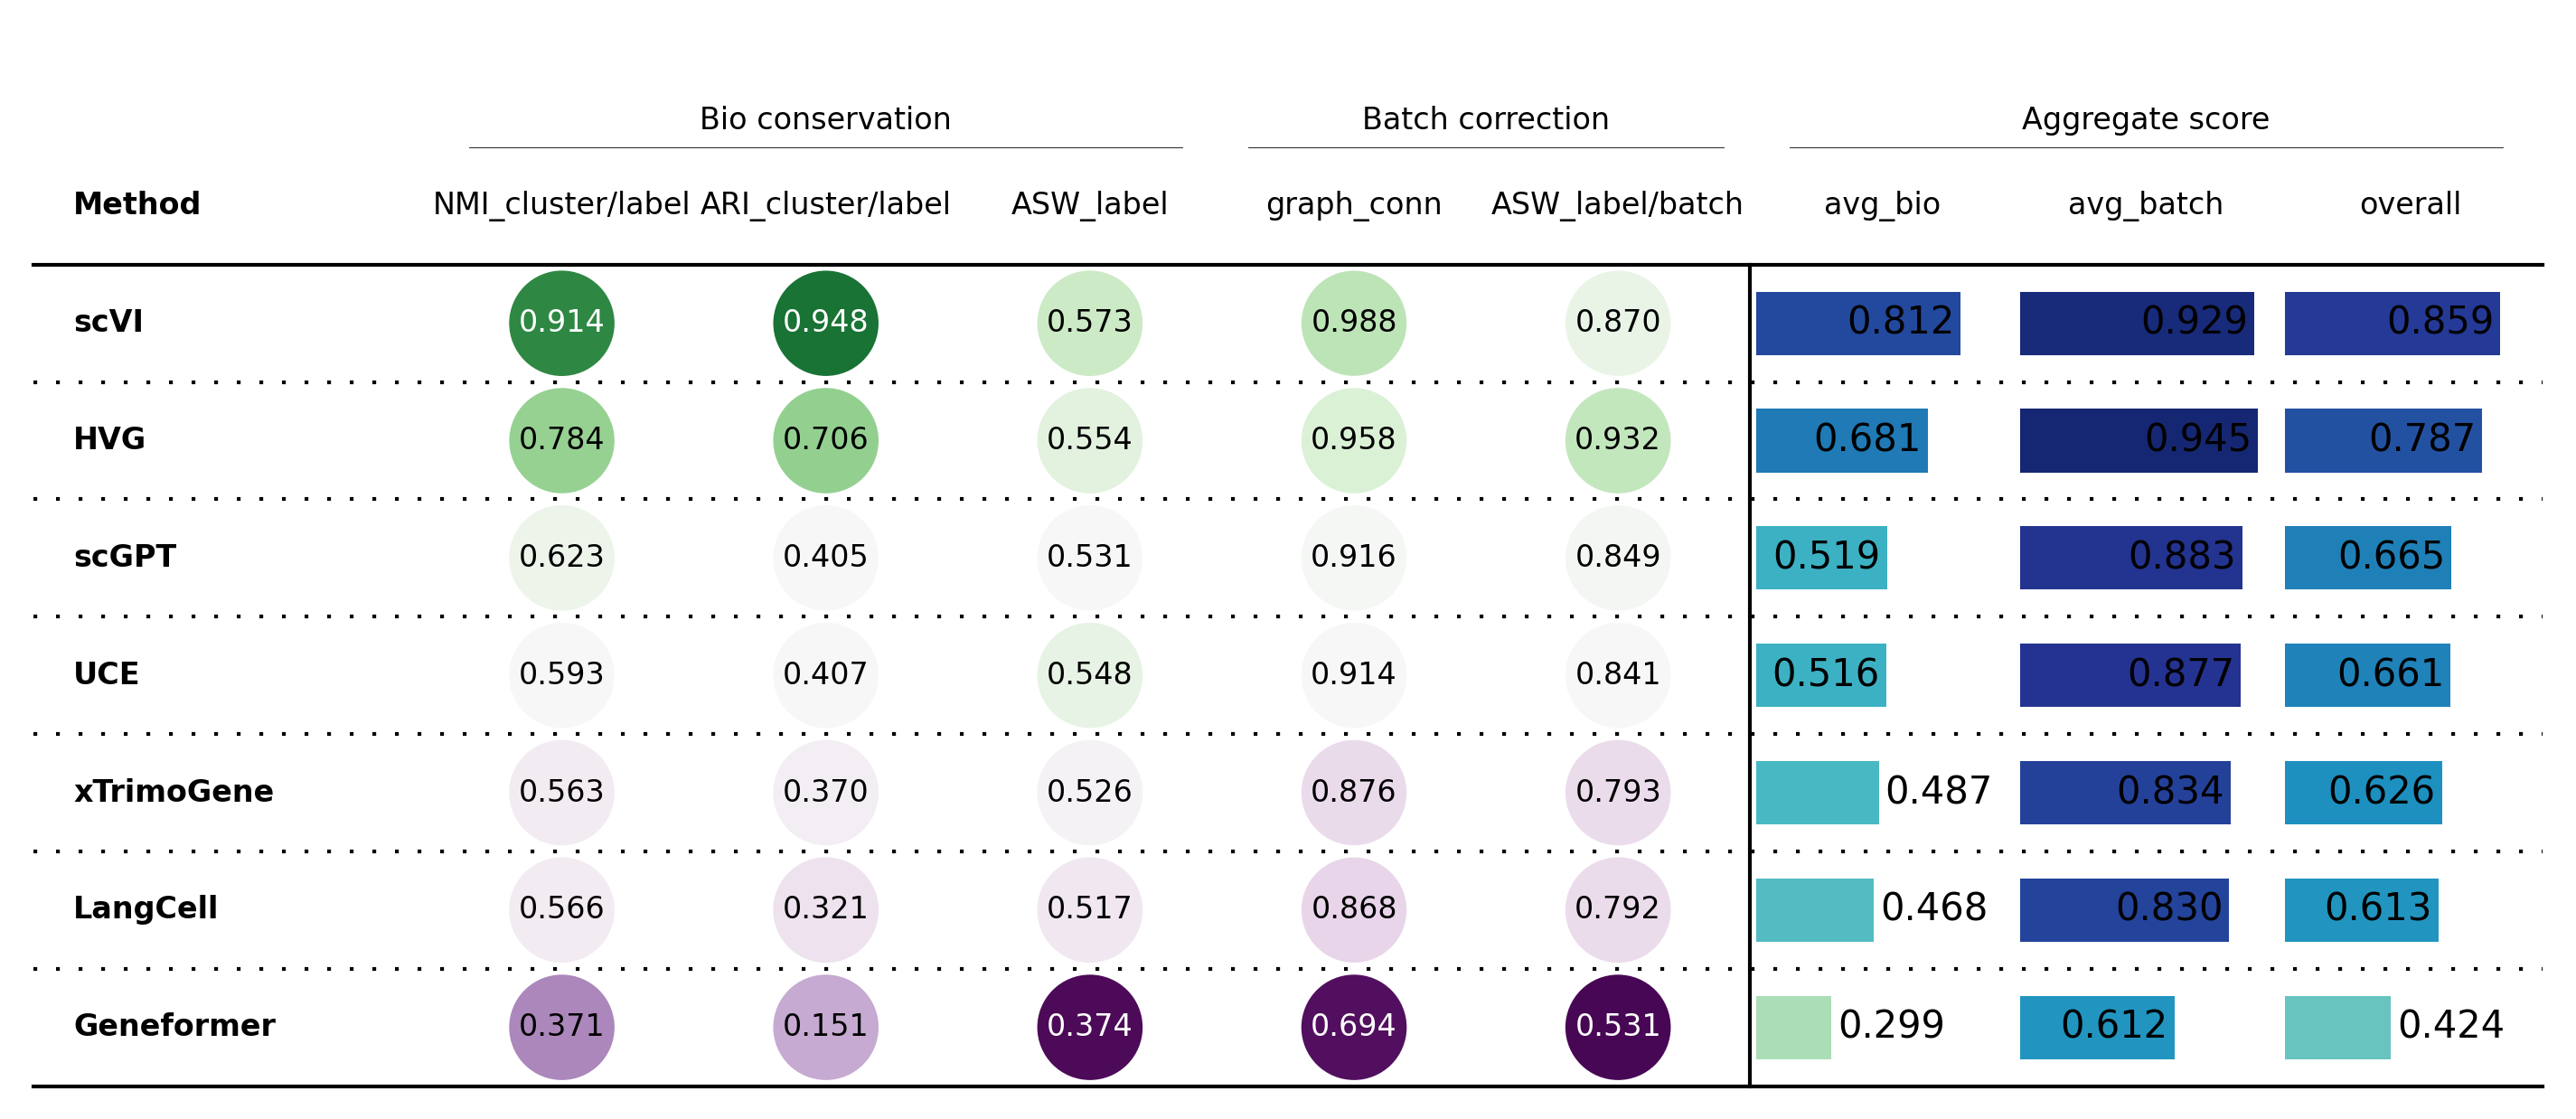

In [14]:
plot_results_table(df.T)

In [34]:
data = df.T
data["id"] = data.index
data

NMI_cluster/label  ARI_cluster/label  ASW_label  graph_conn  \
HVG                    0.7758             0.6928     0.5536      0.9580   
scVI                   0.9144             0.9483     0.5728      0.9879   
Geneformer             0.3681             0.1775     0.3742      0.6935   
scGPT                  0.6229             0.4046     0.5307      0.9161   
UCE                    0.5934             0.4068     0.5482      0.9136   
xTrimoGene             0.5679             0.3757     0.5260      0.8761   
LangCell               0.4850             0.1600     0.5131      0.8553   

            ASW_label/batch  PCR_batch    kBET  avg_bio  avg_batch  overall  \
HVG                  0.9320     0.6092  0.3806   0.6741     0.7200   0.6924   
scVI                 0.8699     0.9795  0.5331   0.8118     0.8426   0.8241   
Geneformer           0.5306     0.0000  0.1155   0.3066     0.3349   0.3179   
scGPT                0.8494     0.2419  0.2475   0.5194     0.5637   0.5371   
UCE                  0.8412     0.3711  0.2495   0.5161     0.5938   0.5472   
xTrimoGene           0.7929     0.0614  0.2824   0.4899     0.5032   0.4952   
LangCell             0.8169     0.3060  0.2582   0.3861     0.5591   0.4553   

                    id  
HVG                HVG  
scVI              scVI  
Geneformer  Geneformer  
scGPT            scGPT  
UCE                UCE  
xTrimoGene  xTrimoGene  
LangCell      LangCell

In [40]:
row_info = pd.DataFrame({
    "id": data.index,
    "group": ["Baseline", "Baseline", "Foundation models", "Foundation models", "Foundation models", "Foundation models", "Foundation models"],
})
row_info = row_info.set_index("id")
row_info

group
id                           
HVG                  Baseline
scVI                 Baseline
Geneformer  Foundation models
scGPT       Foundation models
UCE         Foundation models
xTrimoGene  Foundation models
LangCell    Foundation models

In [42]:
columns_info = pd.DataFrame({
    "id": data.columns,
    "group": ["Bio conservation", "Bio conservation", "Bio conservation", "Batch correction", "Batch correction","Batch correction","Batch correction","Bio conservation", "Batch correction", "Overall",pd.NA],
    "geom": ["rect","rect","rect","rect","rect","rect","rect","bar","bar","bar","text"],    
    "palette": ["blues","blues","blues","greens","greens","greens","greens","blues","greens","oranges",np.nan],
})
columns_info = columns_info.set_index("id")
columns_info

group  geom  palette
id                                                
NMI_cluster/label  Bio conservation  rect    blues
ARI_cluster/label  Bio conservation  rect    blues
ASW_label          Bio conservation  rect    blues
graph_conn         Batch correction  rect   greens
ASW_label/batch    Batch correction  rect   greens
PCR_batch          Batch correction  rect   greens
kBET               Batch correction  rect   greens
avg_bio            Bio conservation   bar    blues
avg_batch          Batch correction   bar   greens
overall                     Overall   bar  oranges
id                             <NA>  text      NaN

In [53]:
norm = matplotlib.colors.Normalize(vmin=0, vmax=101, clip=True)
def get_colors_from_cmap(cmap_name):
    mapper = cm.ScalarMappable(norm=norm, cmap=cmap_name)
    colors = [mapper.to_rgba(i) for i in range(0, 101)]
    return colors
palettes = pd.DataFrame(
    {
        "palettes": ["oranges", "blues", "greens"],
        "colours": [get_colors_from_cmap("Oranges"), get_colors_from_cmap("Blues"), get_colors_from_cmap("Greens")],
    }
)

In [55]:
palettes = {
    'oranges': 'Oranges',
    'blues': 'Blues',
    'greens': 'Greens'
}

In [58]:
palettes = {
    'oranges': ['#FFEDA0', '#FEB24C', '#F03B20'],
    'blues': ['#DEEBF7', '#9ECAE1', '#3182BD'],
    'greens': ['#E5F5E0', '#A1D99B', '#31A354']
}

In [ ]:
funkyheatmappy.funky_heatmap(
    data=data,
    column_info=columns_info,
    row_info=row_info,
    palettes=palettes,
)

Text(0, 0.5, 'Batch correction')

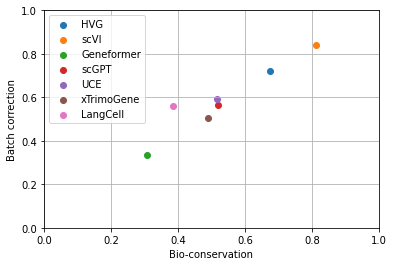

In [18]:
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    x = df.loc["avg_bio", f"X_{model.lower()}"]
    y = df.loc["avg_batch", f"X_{model.lower()}"]
    plt.scatter(x, y, label=model)
plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Bio-conservation")
plt.ylabel("Batch correction")
# plt.savefig(os.path.join(output_folder, "scib_metrics.png"), dpi=600)

Text(0.5, 0, 'scIB overall score')

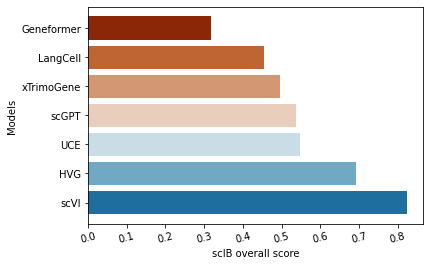

In [60]:
df_sorted = df.transpose().sort_values(by='overall', ascending=False)  # 降序排列
plt.barh(df_sorted.index, df_sorted["overall"],color=palettable.scientific.diverging.Vik_10.mpl_colors[2:])
plt.xticks(rotation=15)
plt.ylabel("Models")
plt.xlabel("scIB overall score")
# plt.savefig(os.path.join(output_folder, "scib_overall_score.png"), dpi=600, bbox_inches='tight')

In [61]:
scgraph = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/output/scGraph/pancreas_scib.csv", index_col=0)
scgraph

Rank-Count  Corr-Count  Rank-PCA  Corr-PCA
X_geneformer      3.2308      0.7924    3.2308    0.7213
X_langcell        4.6154      0.8905    4.6154    0.8050
X_scgpt           2.3077      0.8472    2.3077    0.8300
X_scvi            2.4615      0.9197    2.4615    0.5619
X_uce             1.5385      0.8804    1.5385    0.8060
X_xtrimogene      5.3846      0.8982    5.3846    0.7840

Text(0.5, 0, 'scGraph score')

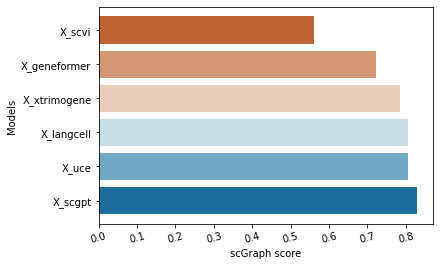

In [62]:
scgraph = scgraph.sort_values(by='Corr-PCA', ascending=False)  # 降序排列
plt.barh(scgraph.index, scgraph["Corr-PCA"],color=palettable.scientific.diverging.Vik_10.mpl_colors[2:])
plt.xticks(rotation=15)
plt.ylabel("Models")
plt.xlabel("scGraph score")
# plt.savefig(os.path.join(output_folder, "scgraph_score.png"), dpi=600, bbox_inches='tight')

## Immune

In [57]:
# output_folder = "/data2/zhuyiheng/wjl/scFoundation/output_renormalize/Immune_all_human"
output_folder = "/data2/zhuyiheng/wjl/scFoundation/output/Immune_all_human"
df = pd.DataFrame()
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
    df_ = pd.read_csv(result_path, index_col=0)
    df = pd.concat([df, df_], axis=1)
df = pd.DataFrame(df.values, columns=["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"], index=df.index)
df

HVG    scVI  Geneformer   scGPT     UCE  xTrimoGene  \
NMI_cluster/label  0.6665  0.8043      0.6200  0.6446  0.7732      0.6466   
ARI_cluster/label  0.3710  0.8214      0.4481  0.5333  0.7212      0.2730   
ASW_label          0.5154  0.5252      0.5073  0.5452  0.5603      0.5733   
graph_conn         0.9155  0.9739      0.9088  0.8982  0.9365      0.8740   
ASW_label/batch    0.9417  0.9116      0.8617  0.9018  0.8845      0.8250   
avg_bio            0.5176  0.7170      0.5251  0.5744  0.6849      0.4976   
avg_batch          0.9286  0.9427      0.8853  0.9000  0.9105      0.8495   
overall            0.6820  0.8073      0.6692  0.7046  0.7751      0.6384   

                   LangCell  
NMI_cluster/label    0.6836  
ARI_cluster/label    0.3875  
ASW_label            0.5463  
graph_conn           0.8682  
ASW_label/batch      0.8458  
avg_bio              0.5391  
avg_batch            0.8570  
overall              0.6663

In [58]:
keys = df.columns
values = df.iloc[:-3,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI', 'scGPT', 'UCE', 'xTrimoGene']
Front 2: ['Geneformer', 'LangCell']


In [59]:
keys = df.columns
values = df.iloc[-3:-1,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['scVI']
Front 2: ['HVG', 'UCE']
Front 3: ['scGPT']
Front 4: ['Geneformer', 'LangCell']
Front 5: ['xTrimoGene']


In [16]:
df[_METRIC_TYPE] = ["Bio conservation", "Bio conservation", "Bio conservation", 
                    "Batch correction", "Batch correction",
                    _AGGREGATE_SCORE, _AGGREGATE_SCORE, _AGGREGATE_SCORE]
df

HVG    scVI  Geneformer   scGPT     UCE  xTrimoGene  \
NMI_cluster/label  0.6665  0.8043      0.6200  0.6446  0.7732      0.6466   
ARI_cluster/label  0.3710  0.8214      0.4481  0.5333  0.7212      0.2730   
ASW_label          0.5154  0.5252      0.5073  0.5452  0.5603      0.5733   
graph_conn         0.9155  0.9739      0.9088  0.8982  0.9365      0.8740   
ASW_label/batch    0.9417  0.9116      0.8617  0.9018  0.8845      0.8250   
avg_bio            0.5176  0.7170      0.5251  0.5744  0.6849      0.4976   
avg_batch          0.9286  0.9427      0.8853  0.9000  0.9105      0.8495   
overall            0.6820  0.8073      0.6692  0.7046  0.7751      0.6384   

                   LangCell       Metric Type  
NMI_cluster/label    0.6836  Bio conservation  
ARI_cluster/label    0.3875  Bio conservation  
ASW_label            0.5463  Bio conservation  
graph_conn           0.8682  Batch correction  
ASW_label/batch      0.8458  Batch correction  
avg_bio              0.5391   Aggregate score  
avg_batch            0.8570   Aggregate score  
overall              0.6663   Aggregate score

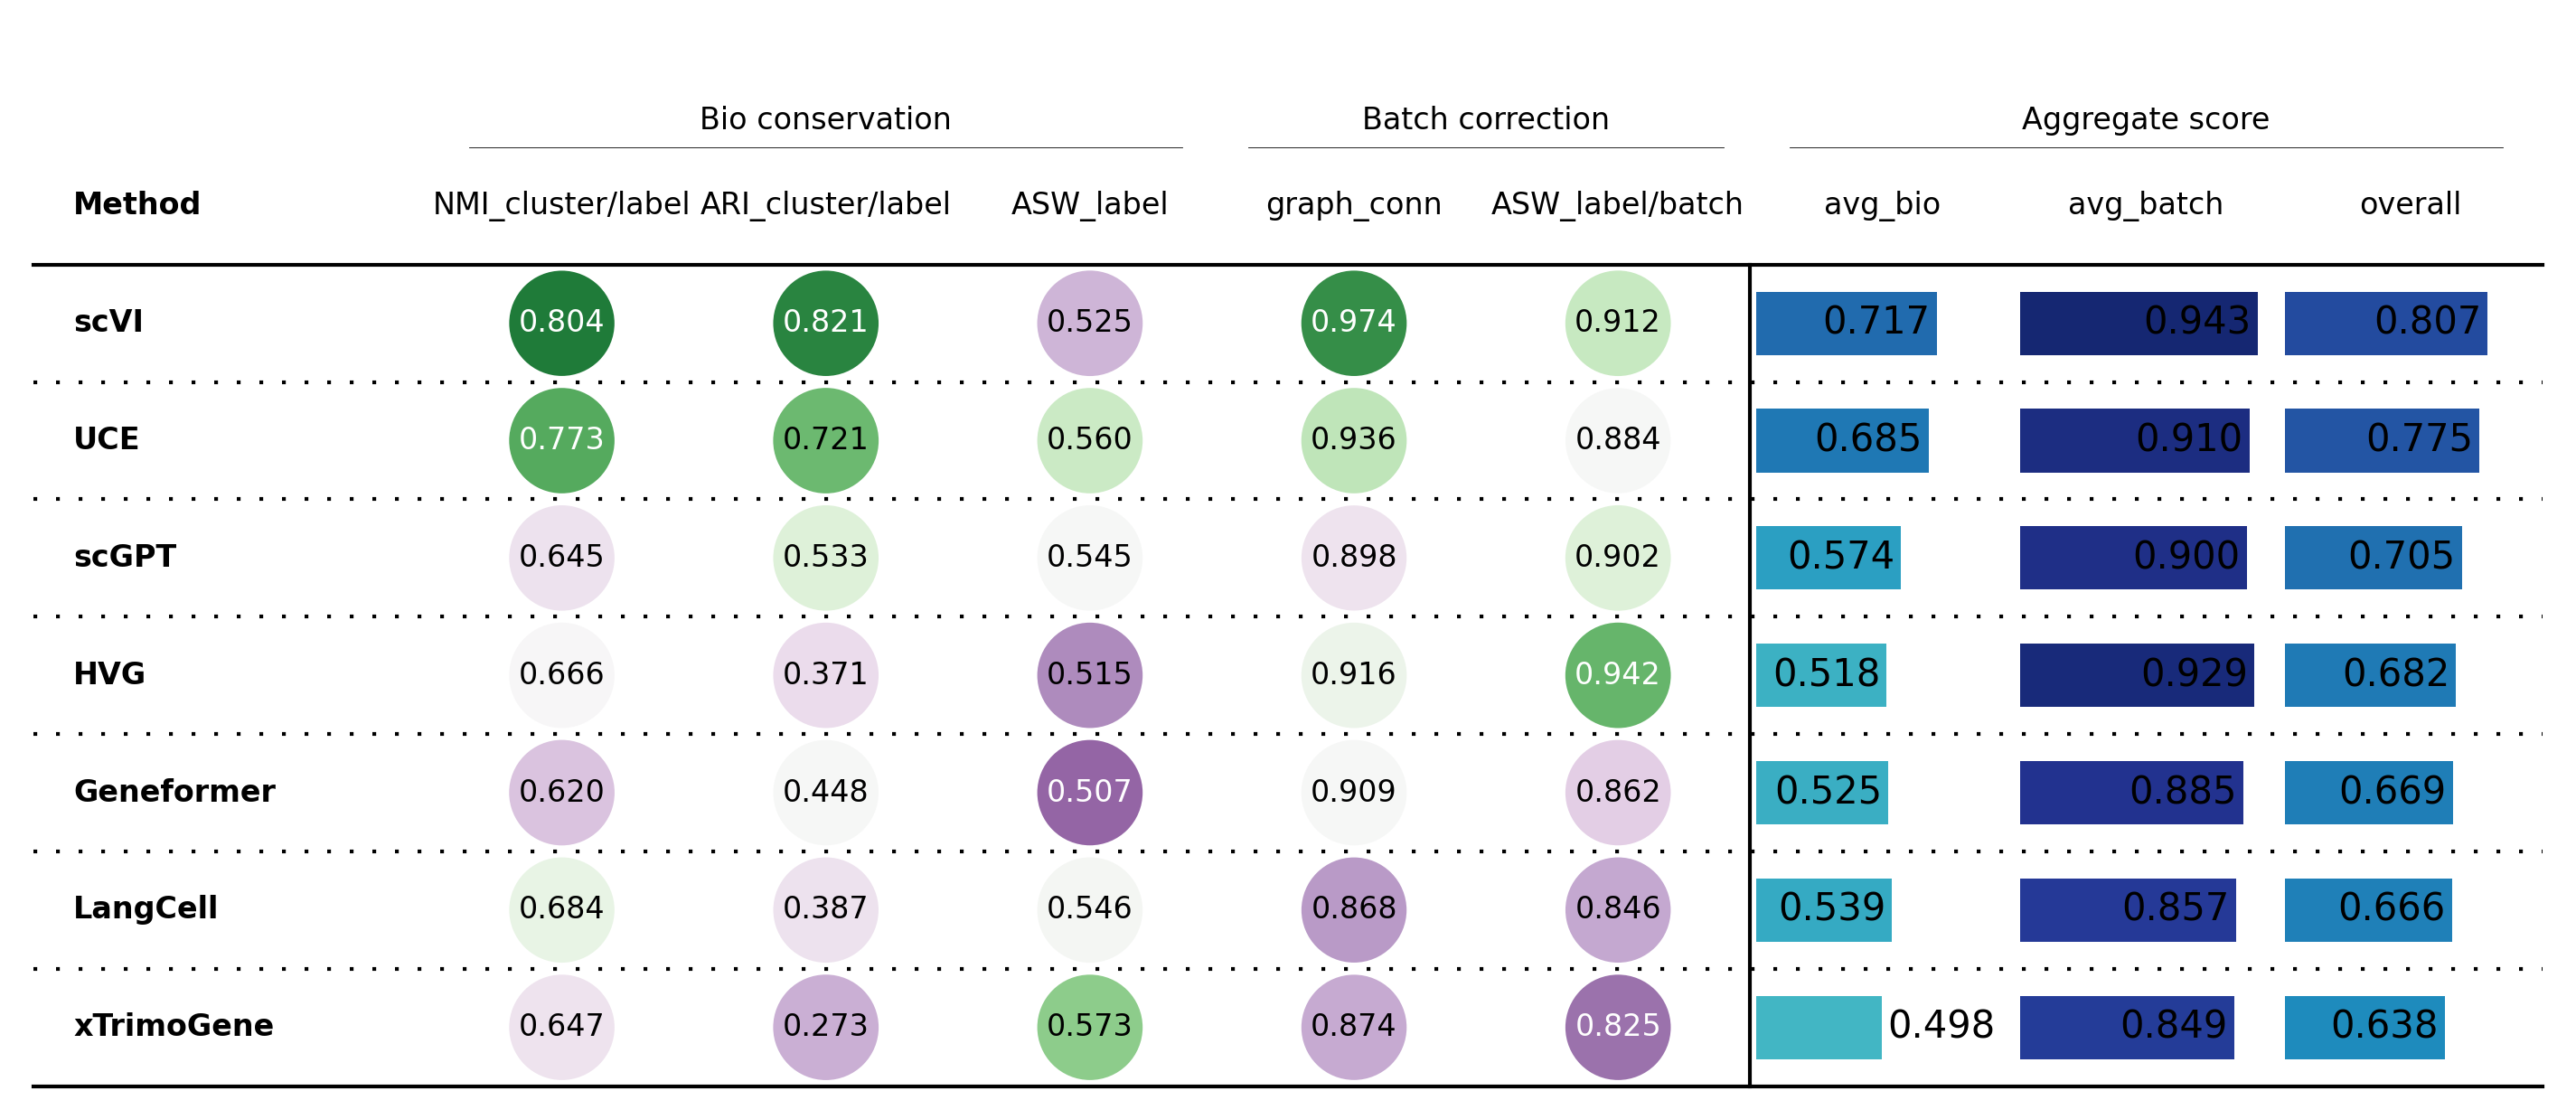

In [17]:
plot_results_table(df.T)

In [ ]:
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    x = df.loc["avg_bio", f"X_{model.lower()}"]
    y = df.loc["avg_batch", f"X_{model.lower()}"]
    plt.scatter(x, y, label=model)
plt.legend()
plt.grid()
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Bio-conservation")
plt.ylabel("Batch correction")
plt.savefig(os.path.join(output_folder, "scib_metrics.png"), dpi=600)

In [ ]:
df_sorted = df.transpose().sort_values(by='overall', ascending=False)  # 降序排列
plt.barh(df_sorted.index, df_sorted["overall"],color=palettable.scientific.diverging.Vik_10.mpl_colors[2:])
plt.xticks(rotation=15)
plt.ylabel("Models")
plt.xlabel("scIB overall score")
plt.savefig(os.path.join(output_folder, "scib_overall_score.png"), dpi=600, bbox_inches='tight')

In [ ]:
scgraph = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/output/scGraph/Immune_all_human.csv", index_col=0)
scgraph = scgraph.sort_values(by='Corr-PCA', ascending=False)  # 降序排列
plt.barh(scgraph.index, scgraph["Corr-PCA"],color=palettable.scientific.diverging.Vik_10.mpl_colors[2:])
plt.xticks(rotation=15)
plt.ylabel("Models")
plt.xlabel("scGraph score")
plt.savefig(os.path.join(output_folder, "scgraph_score.png"), dpi=600, bbox_inches='tight')

## HLCA

In [60]:
dataset_name = "HLCA_core"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/output/{dataset_name}"
df = pd.DataFrame()
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
    df_ = pd.read_csv(result_path, index_col=0)
    df = pd.concat([df, df_], axis=1)
df = pd.DataFrame(df.values, columns=["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"], index=df.index)
df

HVG    scVI  Geneformer   scGPT     UCE  xTrimoGene  \
NMI_cluster/label  0.7550  0.8123      0.6662  0.7736  0.7337      0.6749   
ARI_cluster/label  0.5386  0.7037      0.4476  0.6651  0.4667      0.3038   
ASW_label          0.5197  0.5324      0.4981  0.5098  0.5646      0.5543   
graph_conn         0.9796  0.9870      0.9358  0.9634  0.9810      0.9773   
ASW_label/batch    0.9348  0.9109      0.8840  0.9180  0.8847      0.8525   
avg_bio            0.6044  0.6828      0.5373  0.6495  0.5883      0.5110   
avg_batch          0.9572  0.9489      0.9099  0.9407  0.9329      0.9149   
overall            0.7456  0.7892      0.6863  0.7660  0.7262      0.6726   

                   LangCell  
NMI_cluster/label    0.6638  
ARI_cluster/label    0.3275  
ASW_label            0.5258  
graph_conn           0.9291  
ASW_label/batch      0.8730  
avg_bio              0.5057  
avg_batch            0.9011  
overall              0.6638

In [61]:
keys = df.columns
values = df.iloc[-3:-1,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI']
Front 2: ['scGPT']
Front 3: ['UCE']
Front 4: ['Geneformer', 'xTrimoGene']
Front 5: ['LangCell']


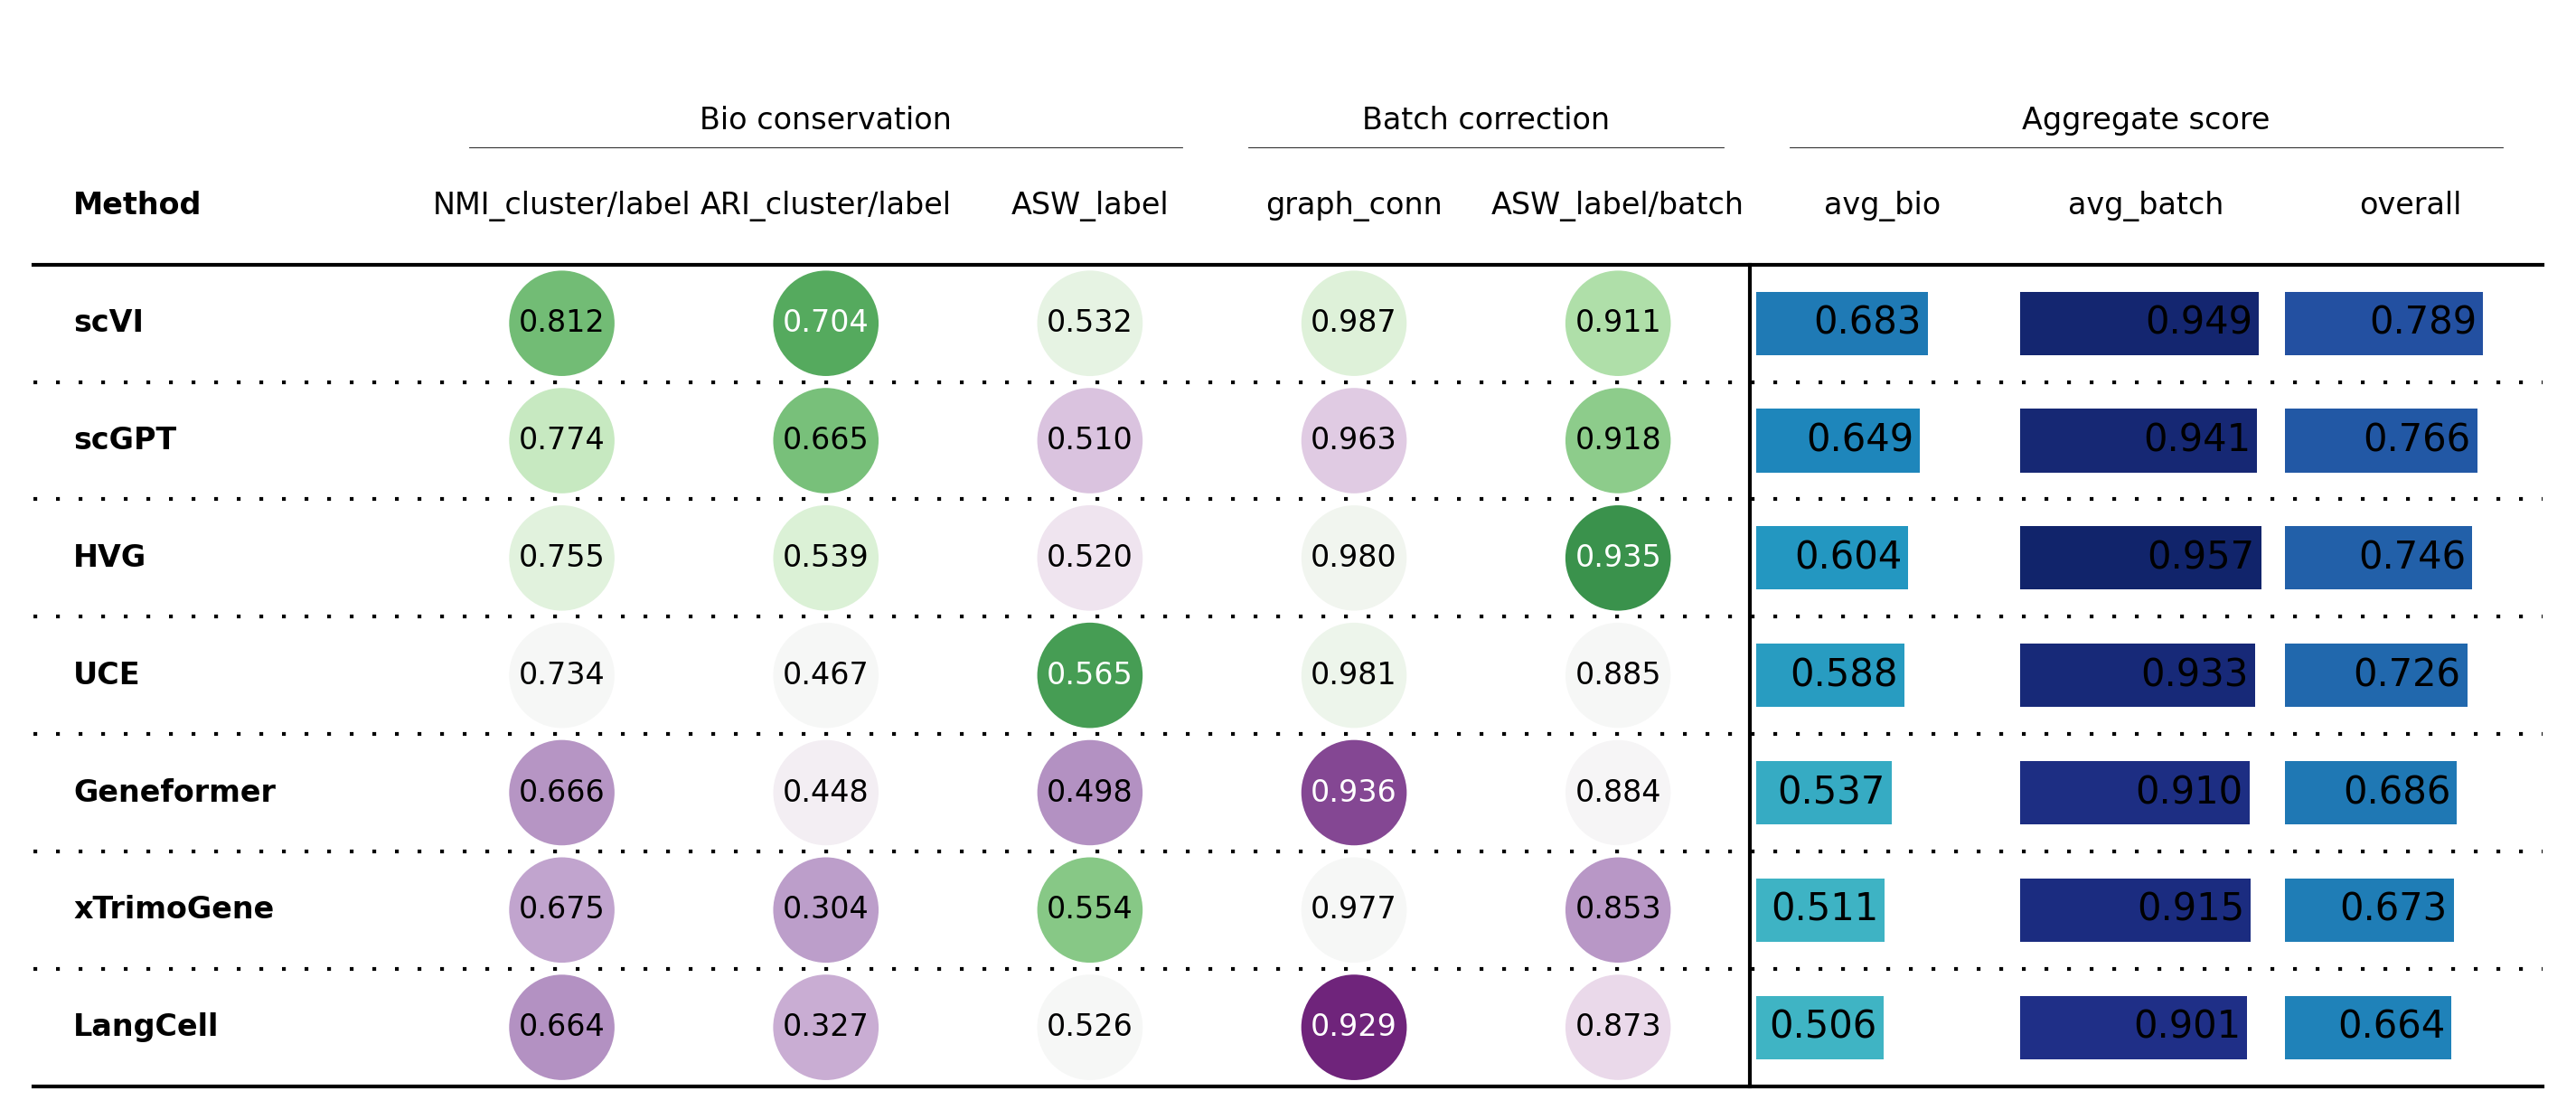

In [19]:
df[_METRIC_TYPE] = ["Bio conservation", "Bio conservation", "Bio conservation", 
                    "Batch correction", "Batch correction",
                    _AGGREGATE_SCORE, _AGGREGATE_SCORE, _AGGREGATE_SCORE]
plot_results_table(df.T)

In [ ]:
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    x = df.loc["avg_bio", f"X_{model.lower()}"]
    y = df.loc["avg_batch", f"X_{model.lower()}"]
    plt.scatter(x, y, label=model)
plt.grid(ls=":")
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.xlabel("Bio-conservation")
plt.ylabel("Batch correction")
plt.legend(bbox_to_anchor=(1,0.5), loc="center left")
# plt.savefig(os.path.join(output_folder, "scib_metrics.png"), dpi=600)

In [ ]:
scgraph = f"/data2/zhuyiheng/wjl/scFoundation/output/scGraph/{dataset_name}.csv"
scgraph_onto = f"/data2/zhuyiheng/wjl/scFoundation/output/scGraph/{dataset_name}_cl_ontology.csv"
plt.figure(figsize=(5,5))
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    x = pd.read_csv(scgraph, index_col=0).loc[f"X_{model.lower()}", "Corr-PCA"]
    y = pd.read_csv(scgraph_onto, index_col=0).loc[f"X_{model.lower()}", "Corr-Ontology"]
    plt.scatter(x, y, label=model)
plt.grid(ls=":")
# plt.xlim(0, 1)
# plt.ylim(0, 1)
x_major_locator = MultipleLocator(0.01)
y_major_locator = MultipleLocator(0.01)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlabel("scGraph-Corr-PCA")
plt.ylabel("scGraph-Corr-Ontology")
plt.legend(bbox_to_anchor=(1,0.5), loc="center left")
# plt.savefig(os.path.join(output_folder, "scgraph_metrics.png"), dpi=600)

In [120]:
df_T = df.T
df_T["class"] = ["baseline"] * 2 + ["foundation_models"] * 5
df_T["model"] = df_T.index
df_T

NMI_cluster/label  ARI_cluster/label  ASW_label  graph_conn  \
X_hvg                  0.754979           0.538613   0.519747    0.979611   
X_scvi                 0.812295           0.703677   0.532368    0.987007   
X_geneformer           0.666199           0.447622   0.498085    0.935757   
X_scgpt                0.773555           0.665147   0.509778    0.963434   
X_uce                  0.733668           0.466701   0.564621    0.981017   
X_xtrimogene           0.674921           0.303765   0.554321    0.977270   
X_langcell             0.540025           0.263842   0.520378    0.850517   

              ASW_label/batch   avg_bio  avg_batch   overall  \
X_hvg                0.934830  0.604446   0.957221  0.745556   
X_scvi               0.910863  0.682780   0.948935  0.789242   
X_geneformer         0.884008  0.537302   0.909883  0.686334   
X_scgpt              0.918022  0.649493   0.940728  0.765987   
X_uce                0.884750  0.588330   0.932884  0.726151   
X_xtrimogene         0.852518  0.511002   0.914894  0.672559   
X_langcell           0.902275  0.441415   0.876396  0.615407   

                          class         model  
X_hvg                  baseline         X_hvg  
X_scvi                 baseline        X_scvi  
X_geneformer  foundation_models  X_geneformer  
X_scgpt       foundation_models       X_scgpt  
X_uce         foundation_models         X_uce  
X_xtrimogene  foundation_models  X_xtrimogene  
X_langcell    foundation_models    X_langcell

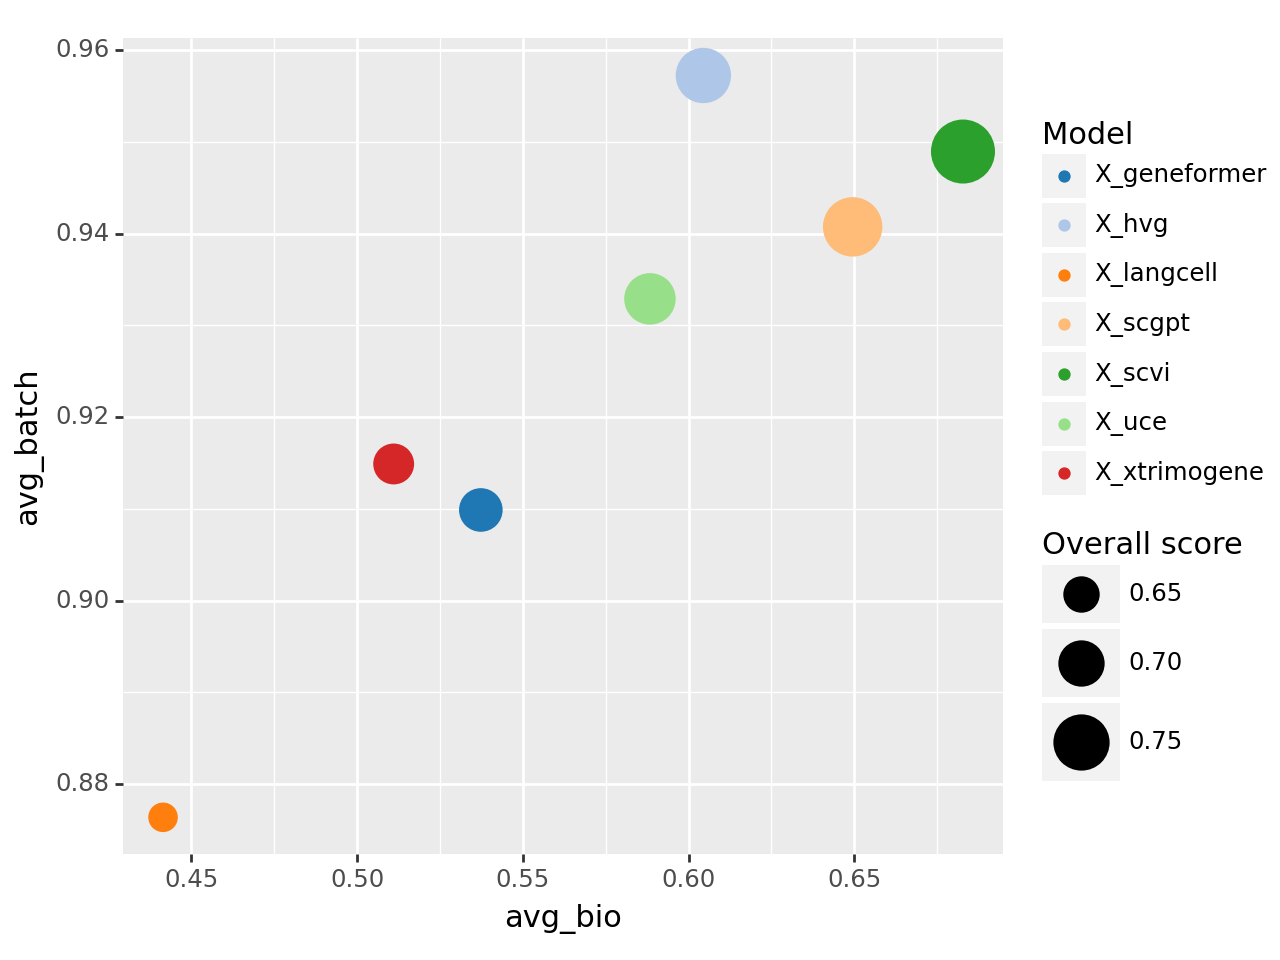

<Figure Size: (640 x 480)>

In [121]:
ggplot(df_T, aes(x='avg_bio', y='avg_batch', color="model")) \
    + geom_point(aes(size='overall')) \
    + scale_color_cmap_d(name="tab20") \
    + guides( 
        color=guide_legend(title="Model"), size=guide_legend(title="Overall score")
    ) \
    + scale_size_radius(range=(5,12))

### scGraph metrics

In [107]:
dataset_name = "HLCA_core"
# scgraph = f"/data2/zhuyiheng/wjl/scFoundation/output/scGraph/{dataset_name}.csv"
scgraph_onto = f"/data2/zhuyiheng/wjl/scFoundation/output/scGraph/{dataset_name}_cl_ontology.csv"
scgraph_df = pd.DataFrame()
x, y, z =[], [], []
model_list = ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
for model in model_list:
    x.append(pd.read_csv(scgraph_onto, index_col=0).loc[f"X_{model.lower()}", "Pearson-PCA"])
    y.append(pd.read_csv(scgraph_onto, index_col=0).loc[f"X_{model.lower()}", "Pearson-OntoRWR"])
scgraph_df["model"] = model_list
scgraph_df["scGraph-Pearson-PCA"] = x
scgraph_df["scGraph-Pearson-OntoRWR"] = y
scgraph_df["Overall_score"] = (scgraph_df["scGraph-Pearson-PCA"] + scgraph_df["scGraph-Pearson-OntoRWR"]) / 2
scgraph_df = scgraph_df.sort_values(by="Overall_score").reset_index(drop=True)
scgraph_df

model  scGraph-Pearson-PCA  scGraph-Pearson-OntoRWR  Overall_score
0  Geneformer               0.6322                   0.6967         0.6644
1        scVI               0.6575                   0.7372         0.6974
2       scGPT               0.6806                   0.7311         0.7059
3    LangCell               0.6799                   0.7719         0.7259
4  xTrimoGene               0.6970                   0.7886         0.7428
5         UCE               0.6942                   0.7994         0.7468
6         HVG               0.8375                   0.7115         0.7745

In [108]:
keys = scgraph_df["model"]
values = scgraph_df.loc[:, ["scGraph-Pearson-PCA", "scGraph-Pearson-OntoRWR"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.63219378, 0.6966999 ]), 'scVI': array([0.65754599, 0.73721821]), 'scGPT': array([0.68064775, 0.73111642]), 'LangCell': array([0.67991261, 0.77185943]), 'xTrimoGene': array([0.6970117 , 0.78859846]), 'UCE': array([0.69424743, 0.79938658]), 'HVG': array([0.83754268, 0.71153892])}
Front 1: ['xTrimoGene', 'UCE', 'HVG']
Front 2: ['scGPT', 'LangCell']
Front 3: ['scVI']
Front 4: ['Geneformer']


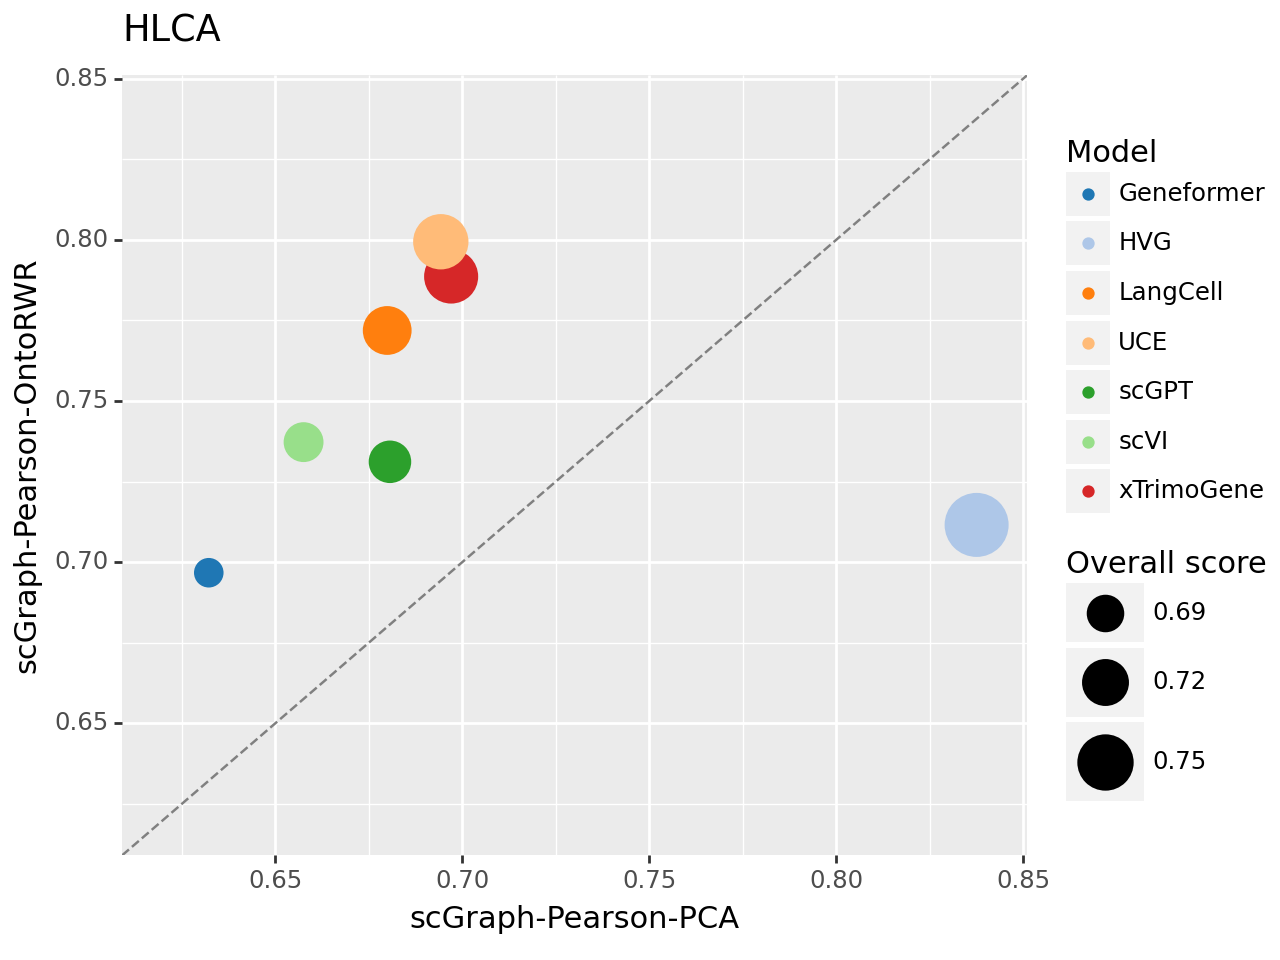

<Figure Size: (640 x 480)>

In [109]:
ggplot(scgraph_df, aes(x="scGraph-Pearson-PCA", y="scGraph-Pearson-OntoRWR", color="model")) \
    + geom_point(aes(size='Overall_score')) \
    + scale_color_cmap_d(name="tab20") \
    + guides( 
        color=guide_legend(title="Model"), size=guide_legend(title="Overall score")
    ) \
    + scale_size_radius(range=(5,12)) \
    + ggtitle("HLCA") \
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") \
    + scale_x_continuous(limits = (0.62, 0.84)) \
    + scale_y_continuous(limits = (0.62, 0.84)) 

In [66]:
rwr_detailed = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/output/scGraph/HLCA_core_rwr_detailed.csv", index_col=0)
# drop unused columns
rwr_detailed = rwr_detailed.drop(["X_scanvi_emb", "X_umap"], axis=1)
# rename other columns
rwr_detailed = rwr_detailed.rename(columns={"X_geneformer": "Geneformer",
                                            "X_langcell": "LangCell",
                                            "X_scgpt": "scGPT",
                                            "X_uce": "UCE",
                                            "X_xtrimogene": "xTrimoGene",
                                            "X_scvi": "scVI"})
rwr_detailed.head()

Geneformer  LangCell     scGPT      scVI       UCE  xTrimoGene
CL:0000037    0.626754  0.815733  0.760888  0.625679  0.807295    0.798560
CL:0000057    0.606043  0.804460  0.737130  0.742126  0.784541    0.775159
CL:0000077    0.561587  0.719593  0.613668  0.730665  0.797727    0.815559
CL:0000084    0.625305  0.850438  0.843011  0.710046  0.858253    0.847141
CL:0000097    0.823629  0.781665  0.761615  0.701750  0.784784    0.795810

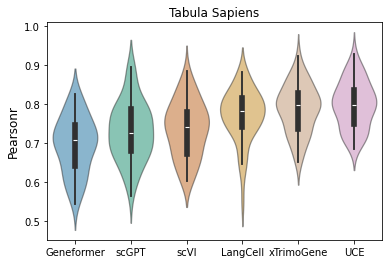

In [67]:
rwr_detailed = pd.melt(rwr_detailed, var_name='Model', value_name='Pearsonr')
medians = rwr_detailed.groupby('Model')['Pearsonr'].median().sort_values()
ordered_models = medians.index.tolist()
sns.violinplot(rwr_detailed, x="Model", y="Pearsonr", hue="Model", 
               palette="colorblind", alpha=0.5,
               order=ordered_models)
plt.xticks(fontsize=10)
plt.xlabel("")
plt.ylabel("Pearsonr", fontsize=12)
plt.title("Tabula Sapiens")
plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/clustering/hlca_spearmanr_violinplot.png", dpi=300)

## Tabula_Sapiens_all

In [119]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/output/{dataset_name}"
df = pd.DataFrame()
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "clustering_metrics.csv")
    df_ = pd.read_csv(result_path, index_col=0)
    df = pd.concat([df, df_], axis=1)
df = pd.DataFrame(df.values, columns=["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"], index=df.index)
df

HVG    scVI  Geneformer   scGPT     UCE  xTrimoGene  \
NMI_cluster/label  0.7199  0.7453      0.6811  0.6949  0.7367      0.7324   
ARI_cluster/label  0.3965  0.4750      0.3772  0.3351  0.4011      0.4139   
ASW_label          0.4900  0.4888      0.4106  0.4905  0.5298      0.5170   
graph_conn         0.8400  0.8390      0.7392  0.8286  0.8635      0.8533   
ASW_label/batch    0.8975  0.7844      0.7831  0.8744  0.7430      0.7977   
avg_bio            0.5355  0.5697      0.4896  0.5068  0.5559      0.5545   
avg_batch          0.8687  0.8117      0.7611  0.8515  0.8032      0.8255   
overall            0.6688  0.6665      0.5982  0.6447  0.6548      0.6629   

                   LangCell  
NMI_cluster/label    0.7325  
ARI_cluster/label    0.4196  
ASW_label            0.5038  
graph_conn           0.8370  
ASW_label/batch      0.8439  
avg_bio              0.5520  
avg_batch            0.8404  
overall              0.6673

In [63]:
keys = df.columns
values = df.iloc[-3:-1,:].values.transpose(1,0)
population = {k:v for k,v in zip(keys, values)}
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

Front 1: ['HVG', 'scVI', 'xTrimoGene', 'LangCell']
Front 2: ['scGPT', 'UCE']
Front 3: ['Geneformer']


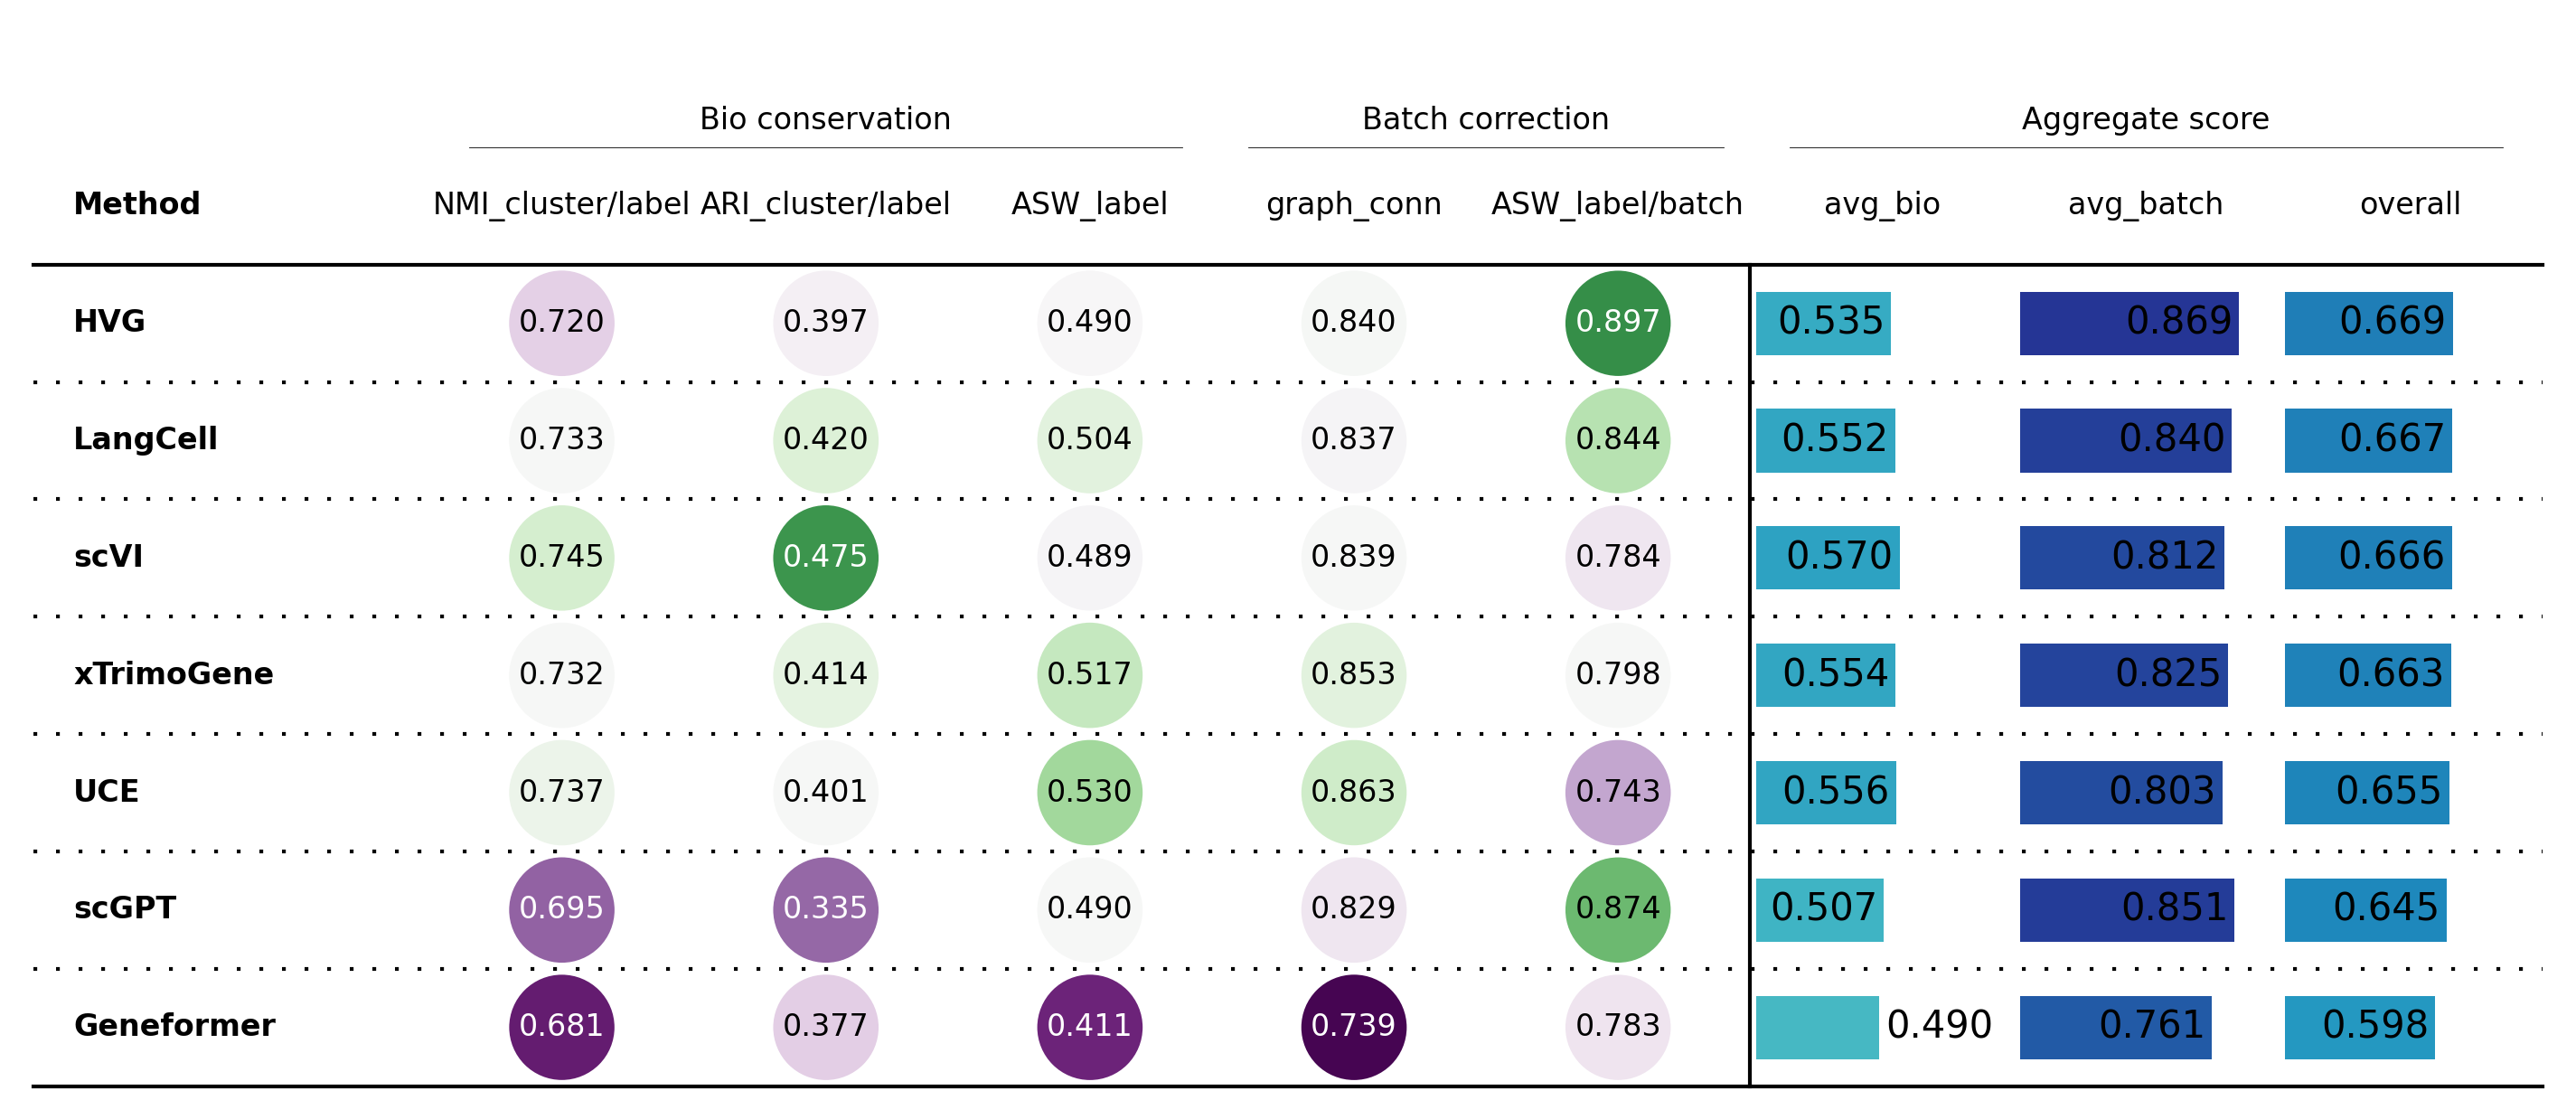

In [21]:
df[_METRIC_TYPE] = ["Bio conservation", "Bio conservation", "Bio conservation", 
                    "Batch correction", "Batch correction",
                    _AGGREGATE_SCORE, _AGGREGATE_SCORE, _AGGREGATE_SCORE]
plot_results_table(df.T)

In [ ]:
for model in ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    x = df.loc["avg_bio", f"X_{model.lower()}"]
    y = df.loc["avg_batch", f"X_{model.lower()}"]
    plt.scatter(x, y, label=model)
plt.grid(ls=":")
# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.xlabel("Bio-conservation")
plt.ylabel("Batch correction")
plt.legend(bbox_to_anchor=(1,0.5), loc="center left")
plt.savefig(os.path.join(output_folder, "scib_metrics.png"), dpi=600)

In [ ]:
df_T = df.T
df_T["class"] = ["baseline"] * 2 + ["foundation_models"] * 5
df_T["model"] = df_T.index
df_T

In [ ]:
ggplot(df_T, aes(x='avg_bio', y='avg_batch', color="model")) \
    + geom_point(aes(size='overall')) \
    + scale_color_cmap_d(name="tab20") \
    + guides( 
        color=guide_legend(title="Model"), size=guide_legend(title="Overall score")
    ) \
    + scale_size_radius(range=(5,12)) \
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") \
    + scale_x_continuous(limits = (0.56, 0.72)) \
    + scale_y_continuous(limits = (0.56, 0.72)) 

### scGraph metrics

In [79]:
df = pd.DataFrame()
for dataset in ["pancreas_scib", "Immune_all_human", "HLCA_core", "Tabula_Sapiens_all"]:
    df_ = pd.read_csv(f"output/scGraph/{dataset}.csv", index_col=0)
    df_["Dataset"] = dataset
    df = pd.concat([df, df_], axis=0)
df["Model"] = df.index
df["Model"] = df.apply(lambda x: x["Model"].split("_")[-1], axis=1)
df

Rank-Count  Pearson-Count  Spearman-Count  Rank-PCA  \
X_geneformer    3.230769       0.792445        0.468724  3.230769   
X_langcell      5.692308       0.900780        0.538884  5.692308   
X_scgpt         2.307692       0.847242        0.459848  2.307692   
X_scvi          2.461538       0.919731        0.781910  2.461538   
X_uce           1.538462       0.880379        0.438292  1.538462   
X_xtrimogene    5.384615       0.898180        0.609045  5.384615   
X_geneformer    2.875000       0.572706        0.475368  2.875000   
X_langcell      7.500000       0.874600        0.605147  7.500000   
X_scgpt         4.875000       0.876514        0.705331  4.875000   
X_scvi          5.875000       0.797824        0.481985  5.875000   
X_uce           5.375000       0.889517        0.660662  5.375000   
X_xtrimogene    6.000000       0.918480        0.735846  6.000000   
X_geneformer    5.617021       0.707765        0.472420  5.617021   
X_langcell      5.914894       0.813973        0.566955  5.914894   
X_scanvi_emb    7.531915       0.748868        0.532539  7.531915   
X_scgpt         7.787234       0.732716        0.512051  7.787234   
X_scvi          3.829787       0.709585        0.467889  3.829787   
X_uce           3.489362       0.825888        0.608136  3.489362   
X_umap          4.978723       0.433230        0.308700  4.978723   
X_xtrimogene    5.319149       0.829730        0.613686  5.319149   
X_geneformer         NaN       0.732217        0.576646       NaN   
X_langcell           NaN       0.856587        0.626524       NaN   
X_pca                NaN       0.810516        0.686816       NaN   
X_scgpt              NaN       0.834309        0.618484       NaN   
X_scvi               NaN       0.787175        0.587520       NaN   
X_scvi_umap          NaN       0.603262        0.527583       NaN   
X_uce                NaN       0.876797        0.651564       NaN   
X_umap               NaN       0.544506        0.443061       NaN   
X_xtrimogene         NaN       0.873565        0.660848       NaN   

              Pearson-PCA  Spearman-PCA             Dataset       Model  
X_geneformer     0.721328      0.473795       pancreas_scib  geneformer  
X_langcell       0.847252      0.543956       pancreas_scib    langcell  
X_scgpt          0.830003      0.573542       pancreas_scib       scgpt  
X_scvi           0.561873      0.148774       pancreas_scib        scvi  
X_uce            0.805981      0.444210       pancreas_scib         uce  
X_xtrimogene     0.783955      0.409975       pancreas_scib  xtrimogene  
X_geneformer     0.484587      0.436397    Immune_all_human  geneformer  
X_langcell       0.735638      0.545037    Immune_all_human    langcell  
X_scgpt          0.770505      0.661949    Immune_all_human       scgpt  
X_scvi           0.592346      0.300000    Immune_all_human        scvi  
X_uce            0.713351      0.509375    Immune_all_human         uce  
X_xtrimogene     0.767350      0.618015    Immune_all_human  xtrimogene  
X_geneformer     0.632194      0.428826           HLCA_core  geneformer  
X_langcell       0.679913      0.447478           HLCA_core    langcell  
X_scanvi_emb     0.649891      0.447555           HLCA_core         emb  
X_scgpt          0.680648      0.476525           HLCA_core       scgpt  
X_scvi           0.657546      0.493002           HLCA_core        scvi  
X_uce            0.694247      0.456439           HLCA_core         uce  
X_umap           0.590620      0.506723           HLCA_core        umap  
X_xtrimogene     0.697012      0.472526           HLCA_core  xtrimogene  
X_geneformer     0.498673      0.338017  Tabula_Sapiens_all  geneformer  
X_langcell       0.627845      0.433488  Tabula_Sapiens_all    langcell  
X_pca            0.581836      0.489121  Tabula_Sapiens_all         pca  
X_scgpt          0.643932      0.469149  Tabula_Sapiens_all       scgpt  
X_scvi           0.603731      0.459928  Tabula_Sapiens_all        scvi  
X_scvi_umap      0.

In [32]:
df_grouped = df.groupby("Model")
df_grouped.get_group(model.lower())

Rank-Count  Pearson-Count  Spearman-Count  Rank-PCA  \
X_xtrimogene    5.384615       0.898180        0.609045  5.384615   
X_xtrimogene    6.000000       0.918480        0.735846  6.000000   
X_xtrimogene    5.319149       0.829730        0.613686  5.319149   
X_xtrimogene         NaN       0.873565        0.660848       NaN   

              Pearson-PCA  Spearman-PCA             Dataset       Model  
X_xtrimogene     0.783955      0.409975       pancreas_scib  xtrimogene  
X_xtrimogene     0.767350      0.618015    Immune_all_human  xtrimogene  
X_xtrimogene     0.697012      0.472526           HLCA_core  xtrimogene  
X_xtrimogene     0.611502      0.402664  Tabula_Sapiens_all  xtrimogene

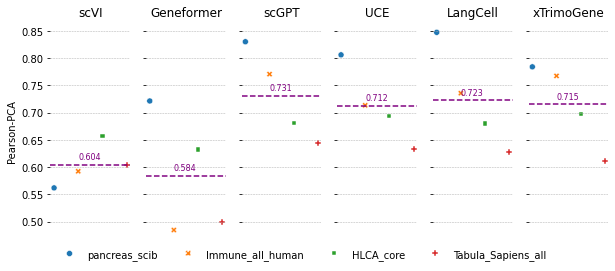

In [9]:
fig, axes = plt.subplots(1, 6, figsize=(10, 4), sharex=True, sharey=True)
df_grouped = df.groupby("Model")
for i, model in enumerate(["scVI", "Geneformer", "scGPT", "UCE", "LangCell", "xTrimoGene"]):
    df_model = df_grouped.get_group(model.lower())
    if i > 0:
        sns.scatterplot(data=df_model, x="Dataset", y="Pearson-PCA", hue="Dataset", style="Dataset", ax=axes[i], legend=False)
    else:
        sns.scatterplot(data=df_model, x="Dataset", y="Pearson-PCA", hue="Dataset", style="Dataset", ax=axes[i], legend=True)
        # sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1), title=None, frameon=False, fontsize=6) # title_fontsize
        axes[i].legend(loc='upper left', bbox_to_anchor=(0, 0), ncol=4, title=None, frameon=False, fontsize=10)
    
    mean_value = df_model["Pearson-PCA"].mean()
    axes[i].axhline(y=mean_value, color='purple', linestyle='--')
    axes[i].text(1, mean_value+0.01, f'{mean_value:.3f}', color='purple', fontsize=8) 
    
    # axes[i].set_xticklabels([])
    # axes[i].set_xlabel("")
    axes[i].xaxis.set_visible(False)
    # axes[i].set_major_locator
    axes[i].set_title(model)
    # 删除子图边框
    for spine in ['top', 'right', 'bottom', 'left']:
        axes[i].spines[spine].set_visible(False)

    # 添加网格线
    axes[i].grid(True, which='major', linestyle='--', linewidth=0.5, axis="y")

In [120]:
dataset_name = "Tabula_Sapiens_all"
# scgraph = f"/data2/zhuyiheng/wjl/scFoundation/output/scGraph/{dataset_name}.csv"
scgraph_onto = f"/data2/zhuyiheng/wjl/scFoundation/output/scGraph/{dataset_name}_cl_ontology.csv"
scgraph_df = pd.DataFrame()
x, y, z =[], [], []
model_list = ["HVG", "scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
for model in model_list:
    x.append(pd.read_csv(scgraph_onto, index_col=0).loc[f"X_{model.lower()}", "Pearson-PCA"])
    y.append(pd.read_csv(scgraph_onto, index_col=0).loc[f"X_{model.lower()}", "Pearson-OntoRWR"])
scgraph_df["model"] = model_list
scgraph_df["scGraph-Pearson-PCA"] = x
scgraph_df["scGraph-Pearson-OntoRWR"] = y
scgraph_df["Overall_score"] = (scgraph_df["scGraph-Pearson-PCA"] + scgraph_df["scGraph-Pearson-OntoRWR"]) / 2
# scgraph_df = scgraph_df.sort_values(by="Overall_score").reset_index(drop=True)
scgraph_df

model  scGraph-Pearson-PCA  scGraph-Pearson-OntoRWR  Overall_score
0         HVG               0.2912                   0.2254         0.2583
1        scVI               0.2963                   0.4083         0.3523
2  Geneformer               0.2902                   0.2570         0.2736
3       scGPT               0.3307                   0.4958         0.4132
4         UCE               0.3530                   0.5915         0.4722
5  xTrimoGene               0.3176                   0.5761         0.4468
6    LangCell               0.3444                   0.5433         0.4439

In [121]:
df

HVG    scVI  Geneformer   scGPT     UCE  xTrimoGene  \
NMI_cluster/label  0.7199  0.7453      0.6811  0.6949  0.7367      0.7324   
ARI_cluster/label  0.3965  0.4750      0.3772  0.3351  0.4011      0.4139   
ASW_label          0.4900  0.4888      0.4106  0.4905  0.5298      0.5170   
graph_conn         0.8400  0.8390      0.7392  0.8286  0.8635      0.8533   
ASW_label/batch    0.8975  0.7844      0.7831  0.8744  0.7430      0.7977   
avg_bio            0.5355  0.5697      0.4896  0.5068  0.5559      0.5545   
avg_batch          0.8687  0.8117      0.7611  0.8515  0.8032      0.8255   
overall            0.6688  0.6665      0.5982  0.6447  0.6548      0.6629   

                   LangCell  
NMI_cluster/label    0.7325  
ARI_cluster/label    0.4196  
ASW_label            0.5038  
graph_conn           0.8370  
ASW_label/batch      0.8439  
avg_bio              0.5520  
avg_batch            0.8404  
overall              0.6673

In [122]:
scgraph_df["avg_bio"] = df.loc["avg_bio", :].tolist()
scgraph_df["avg_batch"] = df.loc["avg_batch", :].tolist()
scgraph_df

model  scGraph-Pearson-PCA  scGraph-Pearson-OntoRWR  Overall_score  \
0         HVG               0.2912                   0.2254         0.2583   
1        scVI               0.2963                   0.4083         0.3523   
2  Geneformer               0.2902                   0.2570         0.2736   
3       scGPT               0.3307                   0.4958         0.4132   
4         UCE               0.3530                   0.5915         0.4722   
5  xTrimoGene               0.3176                   0.5761         0.4468   
6    LangCell               0.3444                   0.5433         0.4439   

   avg_bio  avg_batch  
0   0.5355     0.8687  
1   0.5697     0.8117  
2   0.4896     0.7611  
3   0.5068     0.8515  
4   0.5559     0.8032  
5   0.5545     0.8255  
6   0.5520     0.8404

In [123]:
keys = scgraph_df["model"]
values = scgraph_df.loc[:, ["avg_bio", "avg_batch", "scGraph-Pearson-OntoRWR"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'HVG': array([0.53546809, 0.86874316, 0.22542478]), 'scVI': array([0.56966582, 0.81169949, 0.40830899]), 'Geneformer': array([0.48964798, 0.76113336, 0.25695737]), 'scGPT': array([0.50679598, 0.85147018, 0.49582515]), 'UCE': array([0.55586685, 0.80324854, 0.59149406]), 'xTrimoGene': array([0.55445525, 0.82549894, 0.57611242]), 'LangCell': array([0.55195839, 0.84042114, 0.54330202])}
Front 1: ['HVG', 'scVI', 'scGPT', 'UCE', 'xTrimoGene', 'LangCell']
Front 2: ['Geneformer']


In [111]:
keys = scgraph_df["model"]
values = scgraph_df.loc[:, ["scGraph-Pearson-PCA", "scGraph-Pearson-OntoRWR"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'HVG': array([0.29116022, 0.22542478]), 'Geneformer': array([0.29021854, 0.25695737]), 'scVI': array([0.29628752, 0.40830899]), 'scGPT': array([0.33066443, 0.49582515]), 'LangCell': array([0.3444369 , 0.54330202]), 'xTrimoGene': array([0.31756602, 0.57611242]), 'UCE': array([0.3529786 , 0.59149406])}
Front 1: ['UCE']
Front 2: ['LangCell', 'xTrimoGene']
Front 3: ['scGPT']
Front 4: ['scVI']
Front 5: ['HVG', 'Geneformer']


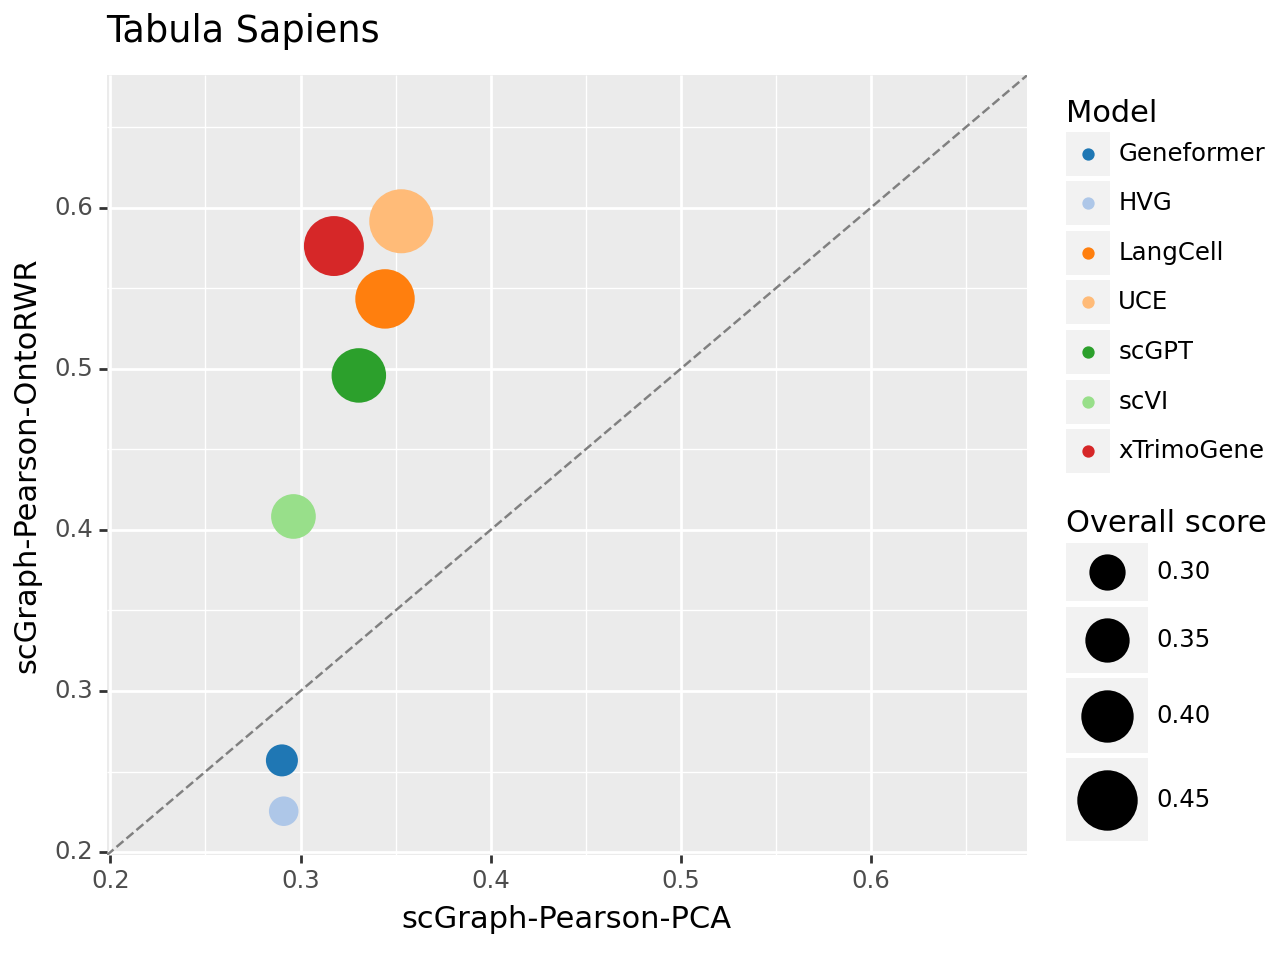

<Figure Size: (640 x 480)>

In [112]:
ggplot(scgraph_df, aes(x="scGraph-Pearson-PCA", y="scGraph-Pearson-OntoRWR", color="model")) \
    + geom_point(aes(size='Overall_score')) \
    + scale_color_cmap_d(name="tab20") \
    + guides( 
        color=guide_legend(title="Model"), size=guide_legend(title="Overall score")
    ) \
    + scale_size_radius(range=(5,12)) \
    + ggtitle("Tabula Sapiens") \
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") \
    + scale_x_continuous(limits = (0.22, 0.66)) \
    + scale_y_continuous(limits = (0.22, 0.66)) 

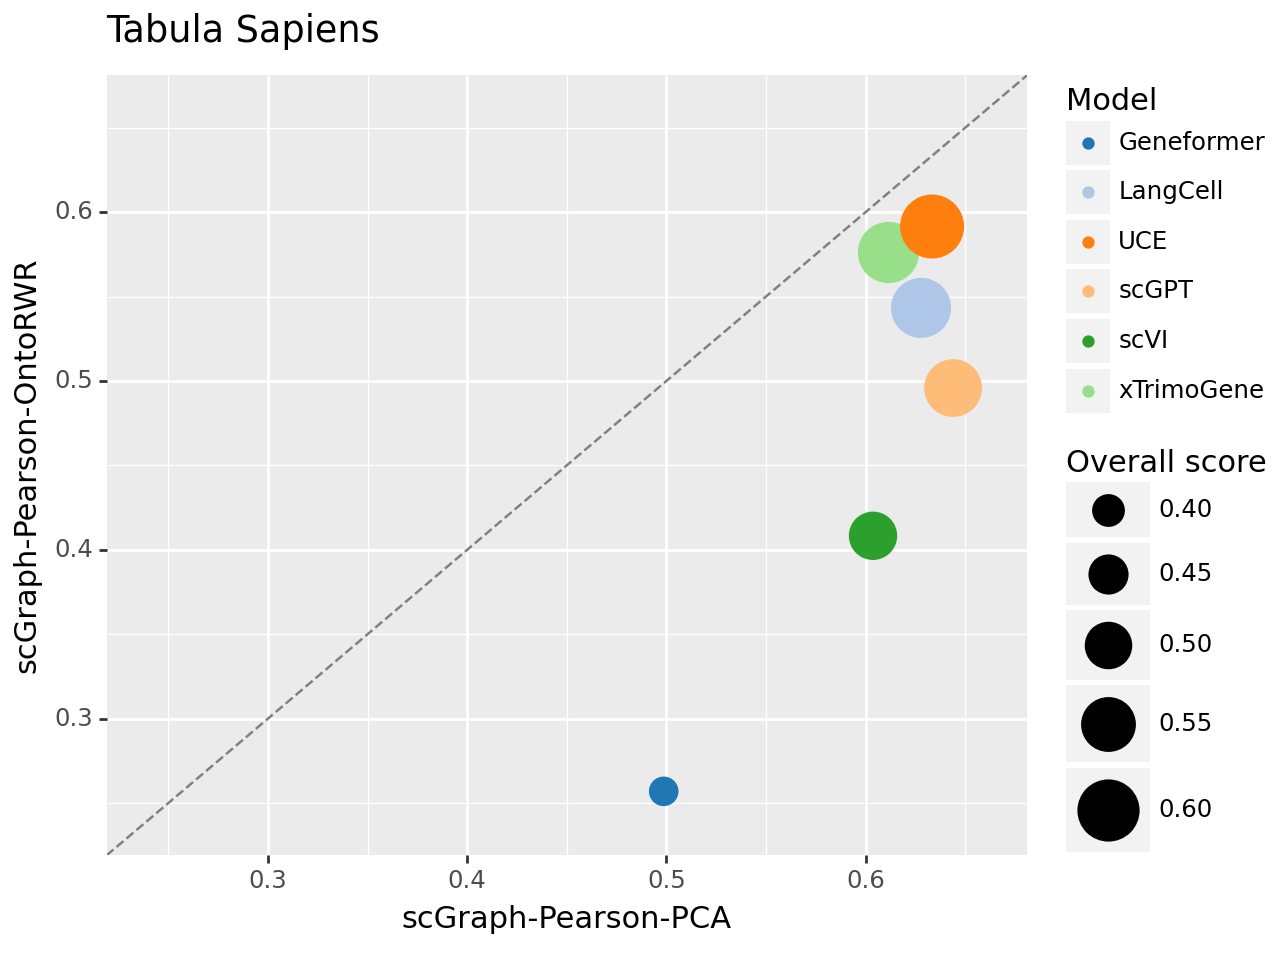

<Figure Size: (640 x 480)>

In [81]:
ggplot(scgraph_df, aes(x="scGraph-Pearson-PCA", y="scGraph-Pearson-OntoRWR", color="model")) \
    + geom_point(aes(size='Overall_score')) \
    + scale_color_cmap_d(name="tab20") \
    + guides( 
        color=guide_legend(title="Model"), size=guide_legend(title="Overall score")
    ) \
    + scale_size_radius(range=(5,12)) \
    + ggtitle("Tabula Sapiens") \
    + geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") \
    + scale_x_continuous(limits = (0.24, 0.66)) \
    + scale_y_continuous(limits = (0.24, 0.66)) 

In [68]:
rwr_detailed = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/output/scGraph/Tabula_Sapiens_all_rwr_detailed.csv", index_col=0)
# drop unused columns
rwr_detailed = rwr_detailed.drop(["X_pca", "X_scvi_umap", "X_umap"], axis=1)
# rename other columns
rwr_detailed = rwr_detailed.rename(columns={"X_geneformer": "Geneformer",
                                            "X_langcell": "LangCell",
                                            "X_scgpt": "scGPT",
                                            "X_uce": "UCE",
                                            "X_xtrimogene": "xTrimoGene",
                                            "X_scvi": "scVI"})
rwr_detailed

Geneformer  LangCell     scGPT      scVI       UCE  xTrimoGene
CL:0000019    0.153333  0.426806  0.358990  0.244767  0.487405    0.464828
CL:0000034    0.189868  0.389229  0.380859  0.332673  0.398462    0.439281
CL:0000037    0.197347  0.517652  0.383824  0.368233  0.612964    0.599023
CL:0000038    0.153031  0.631877  0.619199  0.340705  0.597511    0.547345
CL:0000049    0.312737  0.550322  0.531266  0.369481  0.615149    0.593259
...                ...       ...       ...       ...       ...         ...
CL:1001516    0.077733  0.660374  0.536936  0.530396  0.679429    0.723831
CL:1001589    0.226835  0.541316  0.446747  0.534491  0.561513    0.584450
CL:2000016    0.307579  0.530329  0.536819  0.485433  0.637969    0.603809
CL:2000055    0.289132  0.645872  0.618588  0.353625  0.709224    0.685981
CL:4006000    0.184124  0.469696  0.412216  0.359510  0.552265    0.504107

[155 rows x 6 columns]

In [69]:
rwr_detailed.loc['CL:0000786',:]

Geneformer    0.205122
LangCell      0.581111
scGPT         0.597829
scVI          0.463146
UCE           0.609506
xTrimoGene    0.613314
Name: CL:0000786, dtype: float64

In [70]:
rwr_detailed.sort_values("scVI")

Geneformer  LangCell     scGPT      scVI       UCE  xTrimoGene
CL:0000066    0.097439  0.453040  0.418832  0.146577  0.394870    0.501593
CL:0000681    0.172671  0.212831  0.179113  0.184470  0.284213    0.220802
CL:0002062    0.201283  0.554342  0.434791  0.188815  0.622253    0.558862
CL:0002341    0.159660  0.371544  0.389878  0.207816  0.400727    0.386093
CL:0002673    0.125603  0.372120  0.257404  0.221023  0.414011    0.411409
...                ...       ...       ...       ...       ...         ...
CL:0002139    0.385460  0.637202  0.515793  0.616100  0.713324    0.690546
CL:0000064    0.381063  0.603238  0.588205  0.620763  0.698744    0.657105
CL:0000171    0.043247  0.745435  0.655123  0.626447  0.789166    0.719053
CL:0000189    0.380843  0.700848  0.745987  0.656455  0.765237    0.681292
CL:0000190    0.282722  0.721196  0.766603  0.697445  0.775255    0.679101

[155 rows x 6 columns]

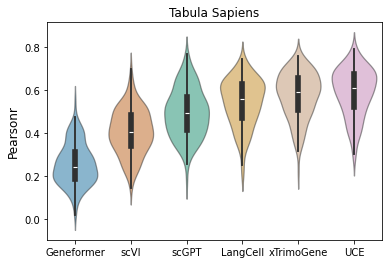

In [71]:
rwr_detailed = pd.melt(rwr_detailed, var_name='Model', value_name='Pearsonr')
medians = rwr_detailed.groupby('Model')['Pearsonr'].median().sort_values()
ordered_models = medians.index.tolist()
sns.violinplot(rwr_detailed, x="Model", y="Pearsonr", hue="Model", 
               palette="colorblind", alpha=0.5,
               order=ordered_models)
plt.xticks(fontsize=10)
plt.xlabel("")
plt.ylabel("Pearsonr", fontsize=12)
plt.title("Tabula Sapiens")
plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/clustering/tabula_spearmanr_violinplot.png", dpi=300)

In [5]:
adata_sc = sc.read_h5ad("/data2/zhuyiheng/wjl/scFoundation/data/datasets/pancreas_scib.h5ad")
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    embedding_key = f"X_{model.lower()}"
    if model.lower() == "xtrimogene":
        embedding_file = "mapping_01B-resolution_singlecell_cell_embedding_t4.5_resolution.npy"
    else:
        embedding_file = "cell_emb.npy"
    output_dir = os.path.join("/data2/zhuyiheng/wjl/scFoundation/output", "pancreas_scib", model)
    embedding_path = os.path.join(output_dir, embedding_file)
    adata_sc.obsm[embedding_key] = np.load(embedding_path)

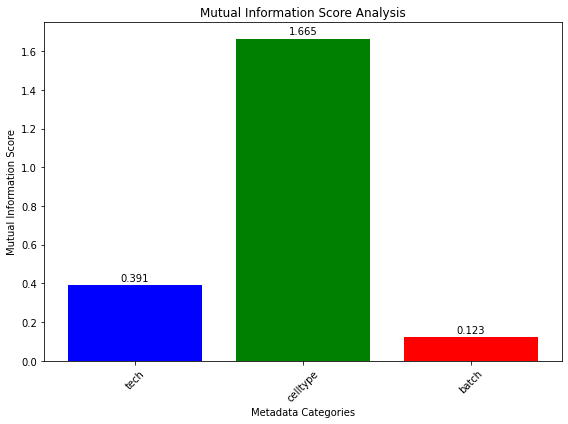

In [11]:
model = "scvi"
sc.pp.neighbors(adata_sc, use_rep=f'X_{model}')
sc.tl.leiden(adata_sc, key_added = f'leiden_{model}')
leiden_labels = adata_sc.obs[f'leiden_{model}']
label_key1 =  adata_sc.obs['tech']
label_key2 =  adata_sc.obs['celltype']
label_key3 =  adata_sc.obs['batch']

mutual_info = mutual_info_score(leiden_labels, label_key1)
mutual_info2 = mutual_info_score(leiden_labels, label_key2)
mutual_info3 = mutual_info_score(leiden_labels, label_key3)

mutual_info_scores = [mutual_info, mutual_info2, mutual_info3]
# metadata_categories = ['Organ', 'Donor', 'Method', 'Cell Types']
# colors = ['blue', 'green', 'red', 'orange']
metadata_categories = ['tech', 'celltype', 'batch']
colors = ['blue', 'green', 'red']
plt.figure(figsize=(8, 6))
plt.bar(metadata_categories, mutual_info_scores, color=colors)
plt.xlabel('Metadata Categories')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Analysis')

for i, score in enumerate(mutual_info_scores):
    plt.text(i, score + 0.02, f'{score:.3f}', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

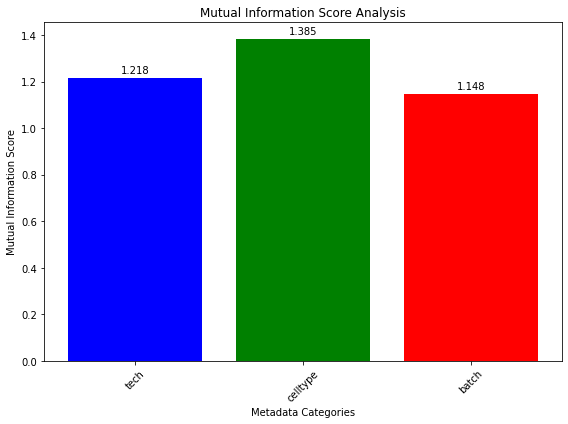

In [12]:
model = "scgpt"
sc.pp.neighbors(adata_sc, use_rep=f'X_{model}')
sc.tl.leiden(adata_sc, key_added = f'leiden_{model}')
leiden_labels = adata_sc.obs[f'leiden_{model}']
label_key1 =  adata_sc.obs['tech']
label_key2 =  adata_sc.obs['celltype']
label_key3 =  adata_sc.obs['batch']

mutual_info = mutual_info_score(leiden_labels, label_key1)
mutual_info2 = mutual_info_score(leiden_labels, label_key2)
mutual_info3 = mutual_info_score(leiden_labels, label_key3)

mutual_info_scores = [mutual_info, mutual_info2, mutual_info3]
# metadata_categories = ['Organ', 'Donor', 'Method', 'Cell Types']
# colors = ['blue', 'green', 'red', 'orange']
metadata_categories = ['tech', 'celltype', 'batch']
colors = ['blue', 'green', 'red']
plt.figure(figsize=(8, 6))
plt.bar(metadata_categories, mutual_info_scores, color=colors)
plt.xlabel('Metadata Categories')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Analysis')

for i, score in enumerate(mutual_info_scores):
    plt.text(i, score + 0.02, f'{score:.3f}', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

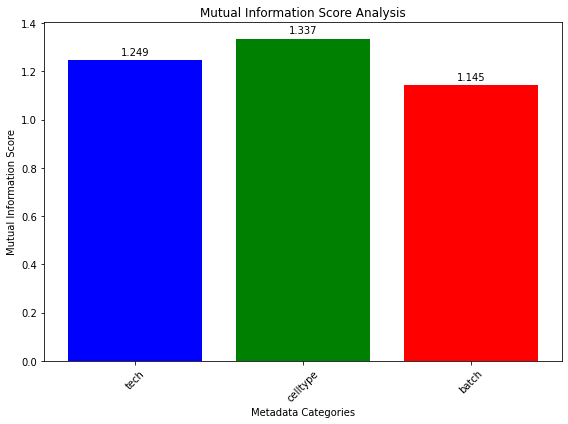

In [13]:
model = "uce"
sc.pp.neighbors(adata_sc, use_rep=f'X_{model}')
sc.tl.leiden(adata_sc, key_added = f'leiden_{model}')
leiden_labels = adata_sc.obs[f'leiden_{model}']
label_key1 =  adata_sc.obs['tech']
label_key2 =  adata_sc.obs['celltype']
label_key3 =  adata_sc.obs['batch']

mutual_info = mutual_info_score(leiden_labels, label_key1)
mutual_info2 = mutual_info_score(leiden_labels, label_key2)
mutual_info3 = mutual_info_score(leiden_labels, label_key3)

mutual_info_scores = [mutual_info, mutual_info2, mutual_info3]
# metadata_categories = ['Organ', 'Donor', 'Method', 'Cell Types']
# colors = ['blue', 'green', 'red', 'orange']
metadata_categories = ['tech', 'celltype', 'batch']
colors = ['blue', 'green', 'red']
plt.figure(figsize=(8, 6))
plt.bar(metadata_categories, mutual_info_scores, color=colors)
plt.xlabel('Metadata Categories')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Analysis')

for i, score in enumerate(mutual_info_scores):
    plt.text(i, score + 0.02, f'{score:.3f}', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

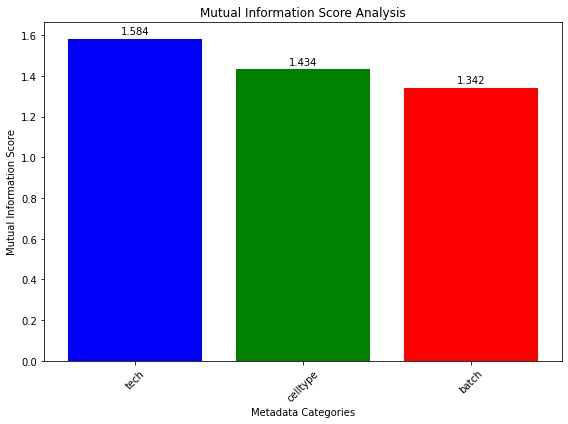

In [14]:
model = "xtrimogene"
sc.pp.neighbors(adata_sc, use_rep=f'X_{model}')
sc.tl.leiden(adata_sc, key_added = f'leiden_{model}')
leiden_labels = adata_sc.obs[f'leiden_{model}']
label_key1 =  adata_sc.obs['tech']
label_key2 =  adata_sc.obs['celltype']
label_key3 =  adata_sc.obs['batch']

mutual_info = mutual_info_score(leiden_labels, label_key1)
mutual_info2 = mutual_info_score(leiden_labels, label_key2)
mutual_info3 = mutual_info_score(leiden_labels, label_key3)

mutual_info_scores = [mutual_info, mutual_info2, mutual_info3]
# metadata_categories = ['Organ', 'Donor', 'Method', 'Cell Types']
# colors = ['blue', 'green', 'red', 'orange']
metadata_categories = ['tech', 'celltype', 'batch']
colors = ['blue', 'green', 'red']
plt.figure(figsize=(8, 6))
plt.bar(metadata_categories, mutual_info_scores, color=colors)
plt.xlabel('Metadata Categories')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Score Analysis')

for i, score in enumerate(mutual_info_scores):
    plt.text(i, score + 0.02, f'{score:.3f}', ha='center')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Embedding distance analysis

#### Case study of the proposed metric

In [71]:
def get_ontology_name(obo_file, lower=True):
	fin = open(obo_file)
	co2name = {}
	name2co = {}
	tag_is_syn = {}
	for line in fin:
		if line.startswith('id: '):
			co = line.strip().split('id: ')[1]
		if line.startswith('name: '):
			if lower:
				name = line.strip().lower().split('name: ')[1]
			else:
				name = line.strip().split('name: ')[1]
			co2name[co] = name
			name2co[name] = co
		if line.startswith('synonym: '):
			if lower:
				syn = line.strip().lower().split('synonym: "')[1].split('" ')[0]
			else:
				syn = line.strip().split('synonym: "')[1].split('" ')[0]
			if syn in name2co:
				continue
			name2co[syn] = co
	fin.close()
	return co2name, name2co

In [72]:
co2name, name2co = get_ontology_name("/data2/zhuyiheng/wjl/scFoundation/data/OnClass_data_public/Ontology_data/cl.obo")
co2name

{'CL:0000000': 'cell',
 'CL:0000001': 'primary cultured cell',
 'CL:0000002': 'obsolete immortal cell line cell',
 'CL:0000003': 'obsolete native cell',
 'CL:0000004': 'obsolete cell by organism',
 'CL:0000005': 'neural crest derived fibroblast',
 'CL:0000006': 'neuronal receptor cell',
 'CL:0000007': 'early embryonic cell (metazoa)',
 'CL:0000008': 'migratory cranial neural crest cell',
 'CL:0000009': 'obsolete fusiform initial',
 'CL:0000010': 'cultured cell',
 'CL:0000011': 'migratory trunk neural crest cell',
 'CL:0000012': 'obsolete cell by class',
 'CL:0000013': 'obsolete dentine secreting cell',
 'CL:0000014': 'germ line stem cell',
 'CL:0000015': 'male germ cell',
 'CL:0000016': 'male germ line stem cell',
 'CL:0000017': 'spermatocyte',
 'CL:0000018': 'spermatid',
 'CL:0000019': 'sperm',
 'CL:0000020': 'spermatogonium',
 'CL:0000021': 'female germ cell',
 'CL:0000022': 'female germ line stem cell',
 'CL:0000023': 'oocyte',
 'CL:0000024': 'oogonial cell',
 'CL:0000025': 'egg cel

In [67]:
# create ontology graph
onto_sp = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/data/OnClass_data_public/Ontology_data/cl.ontology.sp.csv", index_col=0)
onto_nlp = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/data/OnClass_data_public/Ontology_data/cl.ontology.nlp.csv", index_col=0)
onto_rwr = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/data/OnClass_data_public/Ontology_data/cl.ontology.rwr.csv", index_col=0)
onto_nlp

CL:0000000  CL:0000001  CL:0000005  CL:0000006  CL:0000007  \
CL:0000000    0.000000    0.672232    1.041984    1.256473    1.071841   
CL:0000001    0.672232    0.000000    0.913770    1.103122    0.989414   
CL:0000005    1.041984    0.913770    0.000000    1.074516    1.315732   
CL:0000006    1.256473    1.103122    1.074516    0.000000    1.177925   
CL:0000007    1.071841    0.989414    1.315732    1.177925    0.000000   
...                ...         ...         ...         ...         ...   
CL:4042007    1.217550    1.180351    1.133911    1.117037    1.302860   
CL:4042008    1.206490    1.165423    1.176370    1.145368    1.212929   
CL:4042009    1.183404    1.197557    1.166826    1.202255    1.281575   
CL:4042010    1.149285    1.148786    1.115774    1.076025    1.283402   
CL:4042011    1.157841    1.180082    1.139462    1.118687    1.297147   

            CL:0000008  CL:0000010  CL:0000011  CL:0000014  CL:0000015  ...  \
CL:0000000    1.139974    0.911691    1.193805    1.164662    1.184962  ...   
CL:0000001    0.967440    0.475365    0.958533    1.037907    1.117927  ...   
CL:0000005    0.830141    1.032640    0.826486    1.227876    1.294531  ...   
CL:0000006    0.836709    1.114970    0.959024    1.065092    1.214365  ...   
CL:0000007    1.140832    0.978524    1.122769    1.110488    0.956397  ...   
...                ...         ...         ...         ...         ...  ...   
CL:4042007    1.061198    1.274433    1.097722    1.283574    1.297264  ...   
CL:4042008    0.990784    1.266793    1.074108    1.217526    1.261928  ...   
CL:4042009    1.066361    1.292603    1.116678    1.282309    1.297275  ...   
CL:4042010    0.958520    1.245792    1.054815    1.196449    1.324542  ...   
CL:4042011    0.950785    1.272522    1.060971    1.199360    1.334960  ...   

            CL:4042002  CL:4042003  CL:4042004  CL:4042005  CL:4042006  \
CL:0000000    1.331425    1.036765    1.046754    1.030395    0.843450   
CL:0000001    1.187999    0.960066    0.988999    0.964015    0.853606   
CL:0000005    1.155228    0.876500    0.985932    0.885159    1.042170   
CL:0000006    0.782866    1.075460    1.119810    1.124066    1.219153   
CL:0000007    1.207877    1.213567    1.233261    1.240722    1.240959   
...                ...         ...         ...         ...         ...   
CL:4042007    1.132991    1.158146    1.262508    1.211515    1.239539   
CL:4042008    1.158793    1.064450    1.177082    1.113149    1.226485   
CL:4042009    1.233138    1.148845    1.260349    1.191595    1.255516   
CL:4042010    1.193491    0.991243    1.129390    1.033005    1.203898   
CL:4042011    1.194104    0.998761    1.143810    1.040012    1.202195   

            CL:4042007  CL:4042008  CL:4042009  CL:4042010  CL:4042011  
CL:0000000    1.217550    1.206490    1.183404    1.149285    1.157841  
CL:0000001    1.180351    1.165423    1.197557    1.148786    1.180082  
CL:0000005    1.133911    1.176370    1.166826    1.115774    1.139462  
CL:0000006    1.117037    1.145368    1.202255    1.076025    1.118687  
CL:0000007    1.302860    1.212929    1.281575    1.283402    1.297147  
...                ...         ...         ...         ...         ...  
CL:4042007    0.000000    0.456455    0.306484    0.566029    0.619029  
CL:4042008    0.456455    0.000000    0.380536    0.529810    0.560025  
CL:4042009    0.306484    0.380536    0.000000    0.444268    0.491837  
CL:4042010    0.566029    0.529810    0.444268    0.000000    0.207506  
CL:4042011    0.619029    0.560025    0.491837    0.207506    0.000000  

[2743 rows x 2743 columns]

In [14]:
reference_graph_pca = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/scGraph/reference_graph/Tabula_Sapiens_all/concensus_df_pca.csv", index_col=0)
reference_graph_pca = reference_graph_pca.sort_index(axis=1)
reference_graph_pca

CL:0000019  CL:0000034  CL:0000037  CL:0000038  CL:0000049  \
CL:0000019    0.000000         NaN         NaN     0.40779         NaN   
CL:0000034         NaN         0.0         NaN         NaN         NaN   
CL:0000037         NaN         NaN    0.000000     1.00000    0.467688   
CL:0000038    0.382993         NaN    1.000000     0.00000    1.000000   
CL:0000049         NaN         NaN    0.292375     0.59977    0.000000   
...                ...         ...         ...         ...         ...   
CL:1001516         NaN         NaN         NaN         NaN         NaN   
CL:1001589         NaN         NaN         NaN         NaN         NaN   
CL:2000016         NaN         NaN         NaN         NaN         NaN   
CL:2000055         NaN         NaN         NaN         NaN         NaN   
CL:4006000         NaN         NaN         NaN         NaN         NaN   

            CL:0000057  CL:0000064  CL:0000066  CL:0000067  CL:0000068  ...  \
CL:0000019    0.415651         NaN    0.266934         NaN         NaN  ...   
CL:0000034    0.135622         NaN         NaN         NaN         NaN  ...   
CL:0000037         NaN         NaN         NaN         NaN         NaN  ...   
CL:0000038    0.011590         NaN    0.345214         NaN         NaN  ...   
CL:0000049         NaN         NaN         NaN         NaN         NaN  ...   
...                ...         ...         ...         ...         ...  ...   
CL:1001516    0.296374         NaN         NaN         NaN         NaN  ...   
CL:1001589    0.172356         NaN         NaN         NaN         NaN  ...   
CL:2000016    0.038861         NaN         NaN         NaN         NaN  ...   
CL:2000055    0.005730         NaN         NaN         NaN         NaN  ...   
CL:4006000         NaN         NaN         NaN         NaN         NaN  ...   

            CL:1000413  CL:1000432  CL:1000436  CL:1000495  CL:1001428  \
CL:0000019         NaN         NaN         NaN         NaN         NaN   
CL:0000034         NaN    0.159094    0.122399         NaN         NaN   
CL:0000037         NaN         NaN         NaN         NaN         NaN   
CL:0000038         NaN         NaN         NaN         NaN         NaN   
CL:0000049         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
CL:1001516         NaN         NaN         NaN    0.121405         NaN   
CL:1001589         NaN         NaN         NaN    0.239375         NaN   
CL:2000016    0.000001         NaN         NaN         NaN         NaN   
CL:2000055         NaN         NaN         NaN         NaN         NaN   
CL:4006000    0.667519         NaN         NaN         NaN         NaN   

            CL:1001516  CL:1001589  CL:2000016  CL:2000055  CL:4006000  
CL:0000019         NaN         NaN         NaN         NaN         NaN  
CL:0000034         NaN         NaN         NaN         NaN         NaN  
CL:0000037         NaN         NaN         NaN         NaN         NaN  
CL:0000038         NaN         NaN         NaN         NaN         NaN  
CL:0000049         NaN         NaN         NaN         NaN         NaN  
...                ...         ...         ...         ...         ...  
CL:1001516    0.000000    0.150902         NaN         NaN         NaN  
CL:1001589    0.151678    0.000000         NaN         NaN         NaN  
CL:2000016         NaN         NaN         0.0         NaN         NaN  
CL:2000055         NaN         NaN         NaN         0.0         NaN  
CL:4006000         NaN         NaN         NaN         NaN         0.0  

[155 rows x 155 columns]

In [77]:
name2co["plasma cell"]

'CL:0000786'

In [69]:
remain_celltypes = np.load("/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/Tabula_Sapiens_all_remained_celltypes.npy")
target_celltype = 'CL:0000786'
co2distance = {x: onto_sp.loc[target_celltype, x] for x in remain_celltypes}
co2distance

{'CL:0000019': 8.0,
 'CL:0000037': 8.0,
 'CL:0000038': 8.0,
 'CL:0000049': 9.0,
 'CL:0000077': 10.0,
 'CL:0000097': 7.0,
 'CL:0000114': 10.0,
 'CL:0000129': 8.0,
 'CL:0000131': 10.0,
 'CL:0000134': 8.0,
 'CL:0000136': 9.0,
 'CL:0000148': 9.0,
 'CL:0000158': 8.0,
 'CL:0000169': 11.0,
 'CL:0000171': 11.0,
 'CL:0000173': 11.0,
 'CL:0000182': 9.0,
 'CL:0000185': 9.0,
 'CL:0000186': 9.0,
 'CL:0000189': 11.0,
 'CL:0000190': 11.0,
 'CL:0000232': 8.0,
 'CL:0000233': 8.0,
 'CL:0000287': 11.0,
 'CL:0000312': 9.0,
 'CL:0000359': 9.0,
 'CL:0000388': 10.0,
 'CL:0000453': 7.0,
 'CL:0000575': 10.0,
 'CL:0000636': 10.0,
 'CL:0000646': 9.0,
 'CL:0000669': 9.0,
 'CL:0000740': 10.0,
 'CL:0000745': 10.0,
 'CL:0000746': 9.0,
 'CL:0000748': 9.0,
 'CL:0000767': 8.0,
 'CL:0000775': 8.0,
 'CL:0000786': 0.0,
 'CL:0000787': 4.0,
 'CL:0000788': 4.0,
 'CL:0000794': 8.0,
 'CL:0000807': 8.0,
 'CL:0000808': 8.0,
 'CL:0000809': 7.0,
 'CL:0000823': 6.0,
 'CL:0000841': 7.0,
 'CL:0000860': 7.0,
 'CL:0000875': 7.0,
 'CL:0

In [73]:
co2distance_df = pd.DataFrame()
co2distance_df["Cell ontology id"] = co2distance.keys()
co2distance_df["Cell name"] = co2distance_df["Cell ontology id"].apply(lambda x: co2name[x])
co2distance_df["DAG distance"] = co2distance.values()
co2distance_df

Cell ontology id                            Cell name  DAG distance
0         CL:0000019                                sperm           8.0
1         CL:0000037              hematopoietic stem cell           8.0
2         CL:0000038            erythroid progenitor cell           8.0
3         CL:0000049            common myeloid progenitor           9.0
4         CL:0000077                     mesothelial cell          10.0
..               ...                                  ...           ...
115       CL:1001516      intestinal enteroendocrine cell          11.0
116       CL:1001589              duodenum glandular cell          11.0
117       CL:2000016  lung microvascular endothelial cell          11.0
118       CL:2000055                 liver dendritic cell           6.0
119       CL:4006000                 fibroblast of breast          10.0

[120 rows x 3 columns]

In [46]:
co2distance_df["DAG distance"].value_counts()

DAG distance
11.0    27
10.0    25
9.0     22
8.0     18
7.0     15
12.0     6
4.0      2
6.0      2
0.0      1
2.0      1
13.0     1
Name: count, dtype: int64

In [74]:
selected_cells = co2distance_df[co2distance_df["DAG distance"]<=6].sort_values("DAG distance").reset_index(drop=True)
selected_cells

Cell ontology id                     Cell name  DAG distance
0       CL:0000786                   plasma cell           0.0
1       CL:0000980                   plasmablast           2.0
2       CL:0000787                 memory b cell           4.0
3       CL:0000788                  naive b cell           4.0
4       CL:0000823  immature natural killer cell           6.0
5       CL:2000055          liver dendritic cell           6.0

In [76]:
selected_cells["Cell name"].tolist()

['plasma cell',
 'plasmablast',
 'memory b cell',
 'naive b cell',
 'immature natural killer cell',
 'liver dendritic cell']

In [62]:
selected_cells["PCA distance"] = reference_graph_pca.loc[target_celltype, selected_cells["Cell ontology id"]].values
selected_cells

Cell ontology id                     Cell name  DAG distance  PCA distance
0       CL:0000786                   plasma cell           0.0      0.000000
1       CL:0000980                   plasmablast           2.0      0.005752
2       CL:0000787                 memory b cell           4.0      0.177644
3       CL:0000788                  naive b cell           4.0      0.192075
4       CL:0000823  immature natural killer cell           6.0      0.129257
5       CL:2000055          liver dendritic cell           6.0      0.111784

In [63]:
selected_cells["OntoRWR distance"] = onto_rwr.loc[target_celltype, selected_cells["Cell ontology id"]].values
selected_cells

Cell ontology id                     Cell name  DAG distance  PCA distance  \
0       CL:0000786                   plasma cell           0.0      0.000000   
1       CL:0000980                   plasmablast           2.0      0.005752   
2       CL:0000787                 memory b cell           4.0      0.177644   
3       CL:0000788                  naive b cell           4.0      0.192075   
4       CL:0000823  immature natural killer cell           6.0      0.129257   
5       CL:2000055          liver dendritic cell           6.0      0.111784   

   OntoRWR distance  
0          0.000000  
1          3.022473  
2          5.066945  
3          4.768262  
4          5.111935  
5          5.153073

In [64]:
selected_cells.to_csv("/data2/zhuyiheng/wjl/scFoundation/figures/clustering/metric_case_study.csv", index=False)

#### Visualization of pairwise distance distribution

In [25]:
# load dataset and embeddings
adata = sc.read("/data2/zhuyiheng/wjl/scFoundation/data/datasets/Tabula_Sapiens_all.h5ad")
embed_dir = "/data2/zhuyiheng/wjl/scFoundation/output/Tabula_Sapiens_all"
for model in ["scVI", "Geneformer", "LangCell", "scGPT", "UCE", "xTrimoGene"]:
    if model == "xTrimoGene":
        adata.obsm[model] = np.load(os.path.join(embed_dir, model, "mapping_01B-resolution_singlecell_cell_embedding_t4.5_resolution.npy"))
    else:
        adata.obsm[model] = np.load(os.path.join(embed_dir, model, "cell_emb.npy"))

In [5]:
# randomly select 1000 cells
selected_cells = np.random.choice(len(adata), 1000, replace=False)
adata_selected = adata[selected_cells]
selected_celltypes = adata_selected.obs["cell_type_ontology_term_id"]
onto_sp_distance = onto_sp.loc[selected_celltypes, selected_celltypes].values
result_df = pd.DataFrame()
indices = np.tril_indices(1000, k=-1)
result_df["DAG distance"] = onto_sp_distance[indices].reshape(-1).astype("int")

# calculate pairwise distance
for model in ["scVI", "Geneformer", "LangCell", "scGPT", "UCE", "xTrimoGene"]:
    cell_emb = adata_selected.obsm[model]
    emb_distance = cdist(cell_emb, cell_emb, "euclidean")
    result_df[model] = emb_distance[indices].reshape(-1)

In [7]:
result_df.head()

DAG distance      scVI  Geneformer  LangCell     scGPT       UCE  \
0             7  6.323477    0.447283  1.077100  0.532719  1.083990   
1             9  6.405595    0.540779  1.035065  0.592614  1.116328   
2             4  6.410125    0.472058  1.158995  0.552126  1.132162   
3             6  5.811950    0.497231  1.114900  0.560171  1.102675   
4             4  7.331806    0.463645  1.026358  0.620442  1.125608   

   xTrimoGene  
0   55.997218  
1   57.657733  
2   53.717109  
3   54.391390  
4   59.992206

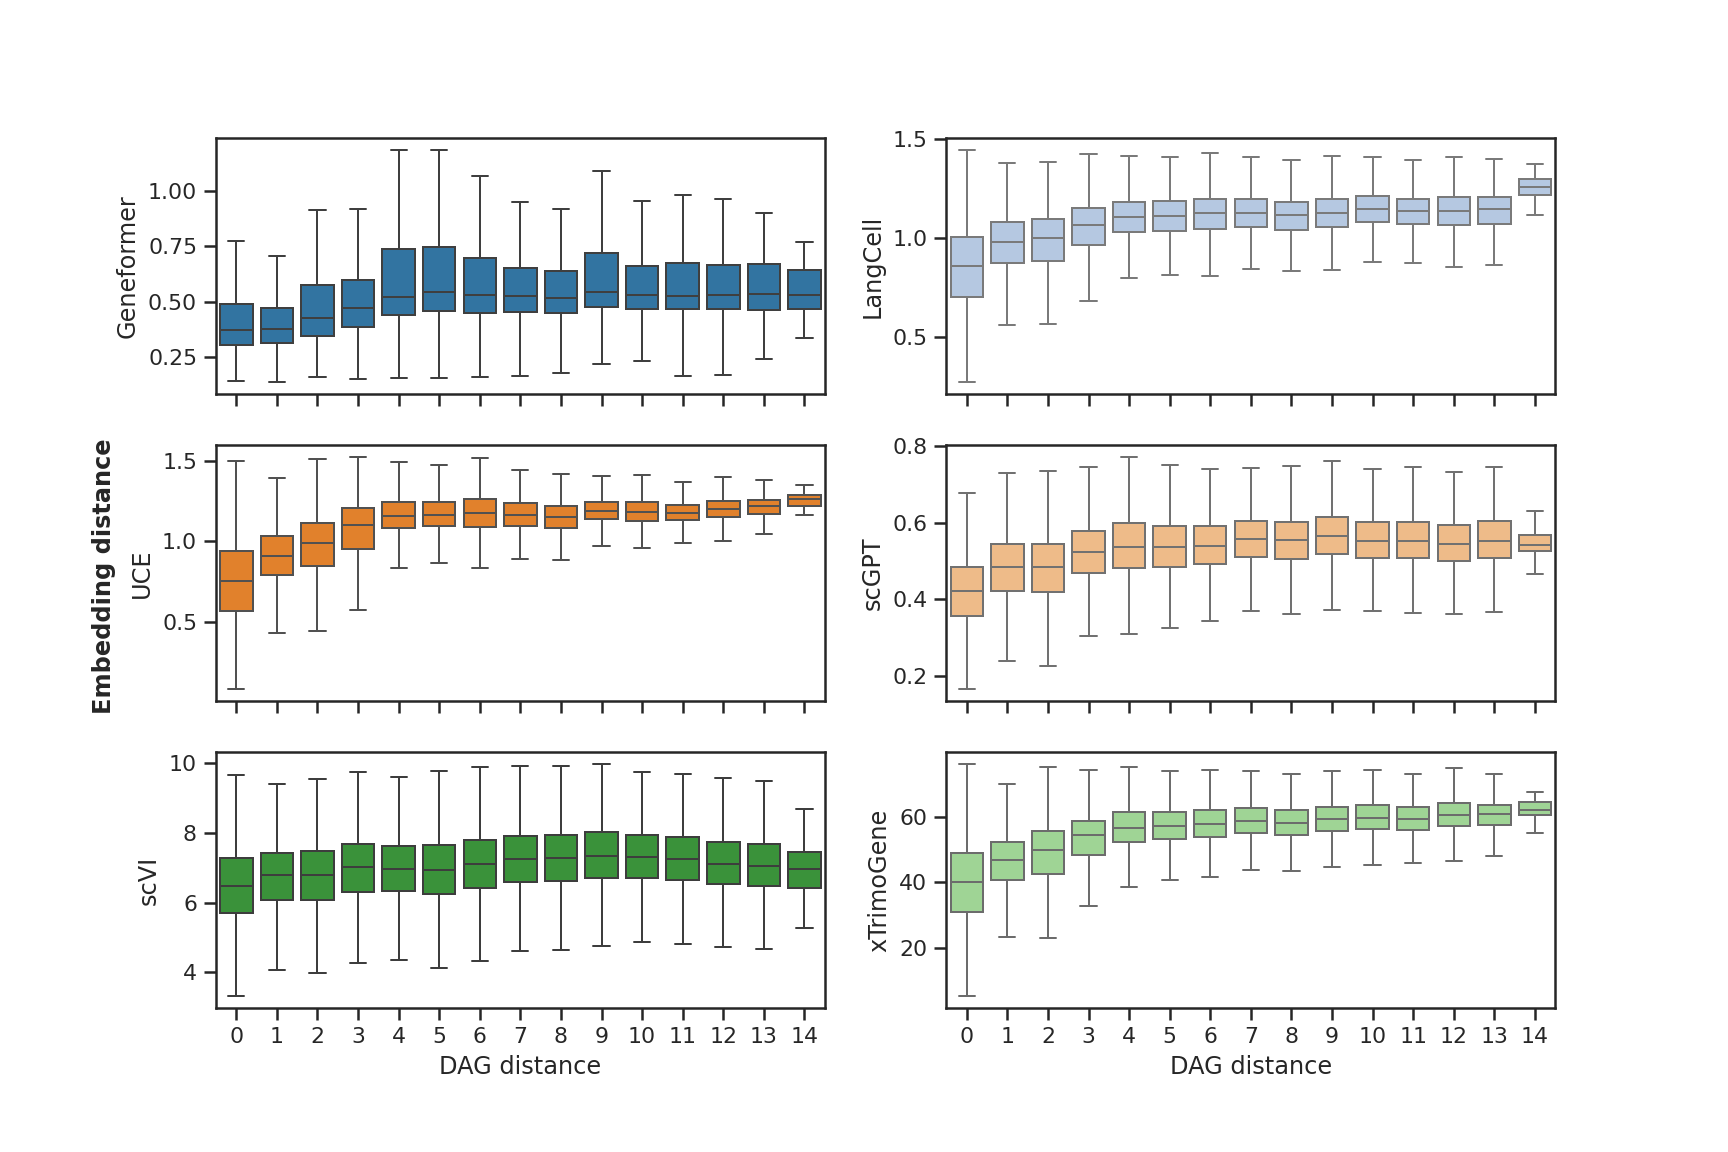

In [39]:
sns.set_theme(style="ticks")
fig, axes = plt.subplots(3, 2, figsize=(12, 8), sharex=True, sharey=False)
# pal = sns.cubehelix_palette(15, rot=-.25, light=.9)
pal = sns.color_palette("tab20", 20)
for i, model in enumerate(["Geneformer", "LangCell", "UCE", "scGPT", "scVI", "xTrimoGene"]):
    sns.boxplot(result_df, y=model, x="DAG distance", showfliers=False, ax=axes[i//2,i%2], 
                # hue="DAG distance", palette=pal, legend=False,
                color=pal[i]
                )
    # axes[i//3,i%3].set_ylabel(f"Embedding distance in {model}")
fig.text(0.06, 0.5, 'Embedding distance', ha='center', va='center', rotation='vertical', fontsize=12, fontweight="bold")
plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/clustering/emb_distance_distribution.png", dpi=300)

In [68]:
df = pd.DataFrame()
for model in ["scVI", "Geneformer", "LangCell", "scGPT", "UCE", "xTrimoGene"]:
    # get embeddings
    target_emb = adata[adata.obs["cell_type_ontology_term_id"]==target_celltype].obsm[model][:100]
    print(target_emb.shape)
    # calculate distribution of cell embedding similarities
    for distance in [2, 4, 6, 8, 10, 12]:
        query_celltype = co2distance_df[co2distance_df["DAG distance"]==distance]["Cell ontology id"].tolist()
        query_emb = adata[adata.obs["cell_type_ontology_term_id"].isin(query_celltype)].obsm[model]
        if query_emb.shape[0] > 100:
            query_emb = query_emb[:100, :]
        # len_query = query_emb.shape[0]
        # selected_cells = np.random.choice(np.arange(len_query), 100, replace=False)
        # query_emb = query_emb[selected_cells]

        # pairwise = cosine_similarity(query_emb, target_emb).reshape(-1)
        pairwise = cdist(query_emb, target_emb, "euclidean").reshape(-1)

        df_ = pd.DataFrame()
        df_["pairwise"] = pairwise
        df_["model"] = model
        df_["distance"] = distance
        df = pd.concat([df, df_], axis=0)     

(100, 30)
(100, 512)
(100, 256)
(100, 512)
(100, 1280)
(100, 3072)


In [81]:
df.head()

pairwise model  distance
0   7.167434  scVI         2
1  10.639982  scVI         2
2   9.607413  scVI         2
3   8.756878  scVI         2
4   8.538164  scVI         2

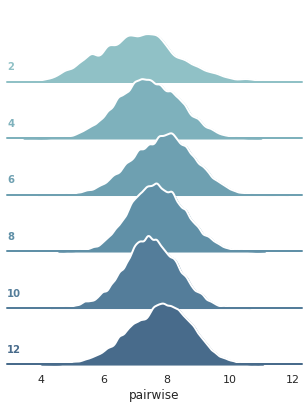

In [69]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df[df["model"]=="scVI"], row="distance", hue="distance", aspect=5, height=1, palette=pal)

# Draw the densities in a few steps
g.map(sns.kdeplot, "pairwise",
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)
g.map(sns.kdeplot, "pairwise", clip_on=False, color="w", lw=2, bw_adjust=.5)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "pairwise")
      
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

In [88]:
# one-sided t-test
def ttest(data1, data2, side=None):
    t_stat, p_value_two_sided = stats.ttest_ind(data1, data2, equal_var=False)

    print(f"t-statistic: {t_stat}")
    if side is None:
        print(f"Two-sided p-value: {p_value_two_sided}")
    elif side == "right":
        # μ1 > μ2
        p_value_one_sided_right = p_value_two_sided / 2 if t_stat > 0 else 1 - p_value_two_sided / 2
        print(f"One-sided p-value (right tail): {p_value_one_sided_right}")
    else:
        # u1 < u2
        p_value_one_sided_left = p_value_two_sided / 2 if t_stat < 0 else 1 - p_value_two_sided / 2
        print(f"One-sided p-value (left tail): {p_value_one_sided_left}")

In [92]:
distances = [2,4,6,8,10,12] 
model_ls = ["scVI", "Geneformer", "LangCell", "scGPT", "UCE", "xTrimoGene"]
for model in model_ls:
      print(f"========== {model} ==========")
      for i in range(len(distances)-1):
            ttest(data1=df[(df["model"]==model)&(df["distance"]==distances[i])].pairwise,
                  data2=df[(df["model"]==model)&(df["distance"]==distances[i+1])].pairwise,
                  side="left")

========== scVI ==========
t-statistic: -9.326353017069131
One-sided p-value (left tail): 1.702231962641682e-20
t-statistic: -29.461427682151882
One-sided p-value (left tail): 2.4671058846498384e-186
t-statistic: 10.773787965055972
One-sided p-value (left tail): 1.0
t-statistic: 19.430366881028338
One-sided p-value (left tail): 1.0
t-statistic: -22.31838425857581
One-sided p-value (left tail): 2.777096764538966e-109
========== Geneformer ==========
t-statistic: 27.329863095731223
One-sided p-value (left tail): 1.0
t-statistic: -10.00260125225141
One-sided p-value (left tail): 9.854706924975477e-24
t-statistic: 0.6230436420924389
One-sided p-value (left tail): 0.7333639257241027
t-statistic: -25.281409562082775
One-sided p-value (left tail): 1.8563604166355358e-138
t-statistic: 20.493028346120838
One-sided p-value (left tail): 1.0
========== LangCell ==========
t-statistic: -29.809108477952375
One-sided p-value (left tail): 6.499359867316263e-155
t-statistic: 39.785878406577595
One-side

# Cell type annotation

## HLCA

### unseen_ratio = 0

In [124]:
dataset_name = "HLCA_core"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    # for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
    for unseen_ratio in [0]:
        result_path = os.path.join(output_folder, model, dataset_name, f"lr_0.0005_l2_1e-05/all_metrics_unseen_{unseen_ratio}.csv")
        df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
        df["model"] = model
        df["unseen_ratio"] = unseen_ratio
        df_all = pd.concat([df_all, df])
df_all.head()

AUROC(seen)  AUPRC(seen)   AUROC   AUPRC  AUROC(unseen)  AUPRC(unseen)  \
0       0.9979       0.9947  0.9979  0.9947            NaN            NaN   
1       0.9981       0.9954  0.9981  0.9954            NaN            NaN   
2       0.9980       0.9950  0.9980  0.9950            NaN            NaN   
3       0.9980       0.9949  0.9980  0.9949            NaN            NaN   
4       0.9967       0.9936  0.9967  0.9936            NaN            NaN   

   Accuracy@3  Accuracy@5  Accuracy@1  Accuracy@1(nonleaf)    LCAD  \
0      0.9895      0.9961      0.9189               0.5510  0.2031   
1      0.9899      0.9960      0.9195               0.5771  0.2028   
2      0.9902      0.9963      0.9225               0.5738  0.1961   
3      0.9900      0.9960      0.9224               0.5631  0.1967   
4      0.9896      0.9962      0.9215               0.5829  0.1970   

   LCAD(incorrect) model  unseen_ratio  
0           2.5032  scVI             0  
1           2.5195  scVI             0  
2           2.5301  scVI             0  
3           2.5345  scVI             0  
4           2.5100  scVI             0

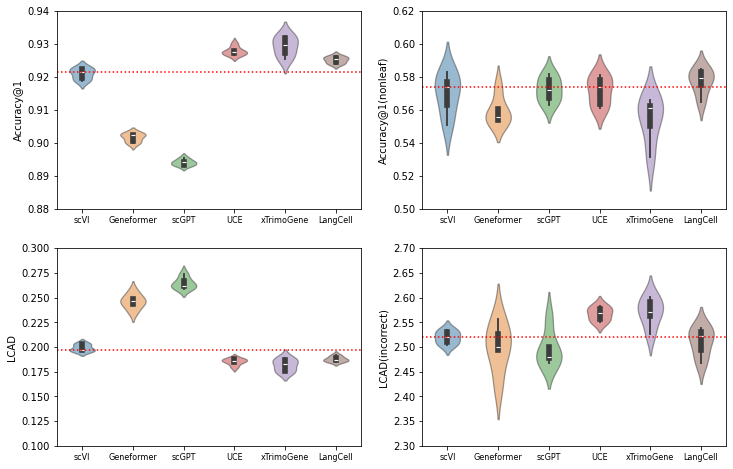

In [34]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# sns.barplot(x='model', y='Accuracy@1', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0, 0])
sns.violinplot(x='model', y='Accuracy@1', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,0], inner="box")
axes[0,0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1'].median(), color='r', linestyle=':')
axes[0,0].set_xlabel("")
axes[0,0].tick_params(axis='x', labelsize=8)
axes[0,0].set_ylabel('Accuracy@1')
axes[0,0].set_ylim(0.88, 0.94)
# for p in axes[0,0].patches: 
#     height = p.get_height()
#     axes[0,0].text(p.get_x() + p.get_width() / 2., height+0.005,
#             '{:.3f}'.format(height),
#             ha='center', va='bottom', fontsize=8)

# sns.barplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0,1])
sns.violinplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,1])
axes[0,1].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1(nonleaf)'].median(), color='r', linestyle=':')
axes[0,1].set_xlabel("")
axes[0,1].tick_params(axis='x', labelsize=8)
axes[0,1].set_ylabel('Accuracy@1(nonleaf)')
axes[0,1].set_ylim(0.5, 0.62)

# sns.barplot(x='model', y='LCAD', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,0])
sns.violinplot(x='model', y='LCAD', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,0])
axes[1,0].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD'].median(), color='r', linestyle=':')
axes[1,0].set_xlabel("")
axes[1,0].tick_params(axis='x', labelsize=8)
axes[1,0].set_ylabel('LCAD')
axes[1,0].set_ylim(0.1, 0.3)

# sns.barplot(x='model', y='LCAD(incorrect)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,1])
sns.violinplot(x='model', y='LCAD(incorrect)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,1])
axes[1,1].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD(incorrect)'].median(), color='r', linestyle=':')
axes[1,1].set_xlabel("")
axes[1,1].tick_params(axis='x', labelsize=8)
axes[1,1].set_ylabel('LCAD(incorrect)')
axes[1,1].set_ylim(2.3, 2.7)

plt.savefig("figures/cell_annotation/HLCA_MLP.png", dpi=300, bbox_inches="tight")

In [86]:
dataset_name = "HLCA_core"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    # for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
    for unseen_ratio in [0]:
        result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.0005_l2_1e-05/all_metrics_unseen_{unseen_ratio}.csv")
        df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
        df["model"] = model
        df["unseen_ratio"] = unseen_ratio
        df_all = pd.concat([df_all, df])
df_all.head()

AUROC(seen)  AUPRC(seen)   AUROC   AUPRC  AUROC(unseen)  AUPRC(unseen)  \
0       0.9992       0.9979  0.9992  0.9979            NaN            NaN   
1       0.9991       0.9976  0.9991  0.9976            NaN            NaN   
2       0.9992       0.9979  0.9992  0.9979            NaN            NaN   
3       0.9992       0.9979  0.9992  0.9979            NaN            NaN   
4       0.9991       0.9976  0.9991  0.9976            NaN            NaN   

   Accuracy@3  Accuracy@5  Accuracy@1  Accuracy@1(nonleaf)    LCAD  \
0      0.9963      0.9991      0.9402               0.5787  0.1416   
1      0.9962      0.9991      0.9380               0.5898  0.1470   
2      0.9963      0.9992      0.9403               0.5827  0.1416   
3      0.9961      0.9992      0.9384               0.5797  0.1443   
4      0.9964      0.9993      0.9395               0.5741  0.1440   

   LCAD(incorrect) model  unseen_ratio  
0           2.3686  scVI             0  
1           2.3693  scVI             0  
2           2.3711  scVI             0  
3           2.3433  scVI             0  
4           2.3796  scVI             0

#### calculate F1 score

In [129]:
dataset_name = "HLCA_core"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
macro_f1_ls = []
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    for iter in range(5):
        result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.0005_l2_1e-05/{iter}/0/pred_label.csv")
        df = pd.read_csv(result_path)
        y_true = df["y_true"]
        y_pred = df["y_pred"]
        macro_f1 = f1_score(y_true, y_pred, average="macro")
        macro_f1_ls.append(macro_f1)
df_all["Macro F1"] = macro_f1_ls
df_all.head()

AUROC(seen)  AUPRC(seen)   AUROC   AUPRC  AUROC(unseen)  AUPRC(unseen)  \
0       0.9979       0.9947  0.9979  0.9947            NaN            NaN   
1       0.9981       0.9954  0.9981  0.9954            NaN            NaN   
2       0.9980       0.9950  0.9980  0.9950            NaN            NaN   
3       0.9980       0.9949  0.9980  0.9949            NaN            NaN   
4       0.9967       0.9936  0.9967  0.9936            NaN            NaN   

   Accuracy@3  Accuracy@5  Accuracy@1  Accuracy@1(nonleaf)    LCAD  \
0      0.9895      0.9961      0.9189               0.5510  0.2031   
1      0.9899      0.9960      0.9195               0.5771  0.2028   
2      0.9902      0.9963      0.9225               0.5738  0.1961   
3      0.9900      0.9960      0.9224               0.5631  0.1967   
4      0.9896      0.9962      0.9215               0.5829  0.1970   

   LCAD(incorrect) model  unseen_ratio  LCAD_rank  Macro F1  
0           2.5032  scVI             0     0.3995    0.9085  
1           2.5195  scVI             0     0.3969    0.9143  
2           2.5301  scVI             0     0.3952    0.9164  
3           2.5345  scVI             0     0.3945    0.9125  
4           2.5100  scVI             0     0.3984    0.9101

In [130]:
df_all["LCAD_rank"] = 1 / df_all["LCAD(incorrect)"]
df_grouped = df_all.groupby("model").agg("mean")
df_grouped

AUROC(seen)  AUPRC(seen)   AUROC   AUPRC  AUROC(unseen)  \
model                                                                 
Geneformer       0.9962       0.9907  0.9962  0.9907            NaN   
LangCell         0.9976       0.9944  0.9976  0.9944            NaN   
UCE              0.9981       0.9953  0.9981  0.9953            NaN   
scGPT            0.9963       0.9908  0.9963  0.9908            NaN   
scVI             0.9977       0.9947  0.9977  0.9947            NaN   
xTrimoGene       0.9979       0.9951  0.9979  0.9951            NaN   

            AUPRC(unseen)  Accuracy@3  Accuracy@5  Accuracy@1  \
model                                                           
Geneformer            NaN      0.9872      0.9950      0.9016   
LangCell              NaN      0.9906      0.9962      0.9252   
UCE                   NaN      0.9912      0.9965      0.9278   
scGPT                 NaN      0.9853      0.9941      0.8940   
scVI                  NaN      0.9898      0.9961      0.9210   
xTrimoGene            NaN      0.9898      0.9956      0.9293   

            Accuracy@1(nonleaf)    LCAD  LCAD(incorrect)  unseen_ratio  \
model                                                                    
Geneformer               0.5594  0.2461           2.5006           0.0   
LangCell                 0.5773  0.1879           2.5103           0.0   
UCE                      0.5715  0.1853           2.5670           0.0   
scGPT                    0.5723  0.2646           2.4967           0.0   
scVI                     0.5696  0.1991           2.5194           0.0   
xTrimoGene               0.5541  0.1817           2.5705           0.0   

            LCAD_rank  Macro F1  
model                            
Geneformer     0.4000    0.8781  
LangCell       0.3984    0.9144  
UCE            0.3896    0.9223  
scGPT          0.4006    0.8810  
scVI           0.3969    0.9124  
xTrimoGene     0.3891    0.9013

In [133]:
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "Macro F1"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.90160209, 0.87806745]), 'LangCell': array([0.92516043, 0.91441295]), 'UCE': array([0.92783207, 0.92229443]), 'scGPT': array([0.8940434 , 0.88104676]), 'scVI': array([0.92095682, 0.91236055]), 'xTrimoGene': array([0.92928061, 0.90126334])}
Front 1: ['UCE', 'xTrimoGene']
Front 2: ['LangCell']
Front 3: ['scVI']
Front 4: ['Geneformer', 'scGPT']


In [134]:
keys = df_grouped.index
values = df_grouped.loc[:, ["Accuracy@1", "LCAD_rank"]].values
population = {k:v for k,v in zip(keys, values)}
print(population)
fronts = non_dominated_sort(population)
for i, front in enumerate(fronts):
    print(f"Front {i + 1}: {front}")

{'Geneformer': array([0.90160209, 0.40002793]), 'LangCell': array([0.92516043, 0.39839607]), 'UCE': array([0.92783207, 0.3895633 ]), 'scGPT': array([0.8940434 , 0.40059644]), 'scVI': array([0.92095682, 0.39692074]), 'xTrimoGene': array([0.92928061, 0.389069  ])}
Front 1: ['Geneformer', 'LangCell', 'UCE', 'scGPT', 'xTrimoGene']
Front 2: ['scVI']


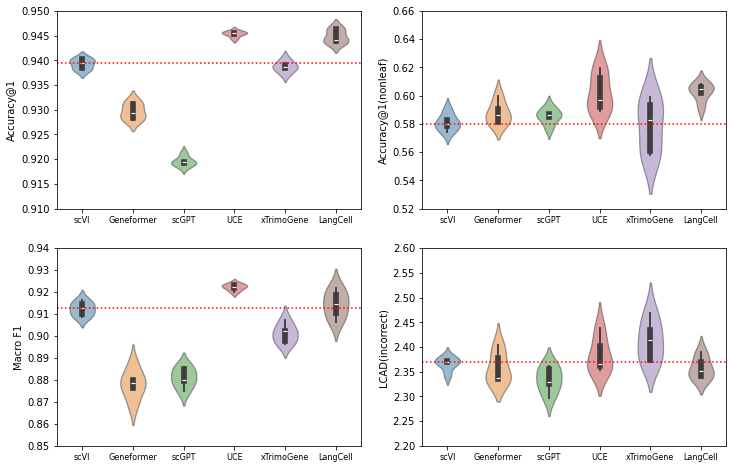

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# sns.barplot(x='model', y='Accuracy@1', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0, 0])
sns.violinplot(x='model', y='Accuracy@1', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,0], inner="box")
axes[0,0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1'].median(), color='r', linestyle=':')
axes[0,0].set_xlabel("")
axes[0,0].tick_params(axis='x', labelsize=8)
axes[0,0].set_ylabel('Accuracy@1')
axes[0,0].set_ylim(0.91, 0.95)
# for p in axes[0,0].patches: 
#     height = p.get_height()
#     axes[0,0].text(p.get_x() + p.get_width() / 2., height+0.005,
#             '{:.3f}'.format(height),
#             ha='center', va='bottom', fontsize=8)

# sns.barplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0,1])
sns.violinplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,1])
axes[0,1].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1(nonleaf)'].median(), color='r', linestyle=':')
axes[0,1].set_xlabel("")
axes[0,1].tick_params(axis='x', labelsize=8)
axes[0,1].set_ylabel('Accuracy@1(nonleaf)')
axes[0,1].set_ylim(0.52, 0.66)

# sns.barplot(x='model', y='LCAD', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,0])
sns.violinplot(x='model', y='Macro F1', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,0])
axes[1,0].axhline(y=df_all[df_all["model"]=="scVI"]['Macro F1'].median(), color='r', linestyle=':')
axes[1,0].set_xlabel("")
axes[1,0].tick_params(axis='x', labelsize=8)
axes[1,0].set_ylabel('Macro F1')
axes[1,0].set_ylim(0.85, 0.94)

# sns.barplot(x='model', y='LCAD(incorrect)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,1])
sns.violinplot(x='model', y='LCAD(incorrect)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,1])
axes[1,1].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD(incorrect)'].median(), color='r', linestyle=':')
axes[1,1].set_xlabel("")
axes[1,1].tick_params(axis='x', labelsize=8)
axes[1,1].set_ylabel('LCAD(incorrect)')
axes[1,1].set_ylim(2.2, 2.6)

plt.savefig("figures/cell_annotation/HLCA_Onclass_Yemb.png", dpi=300, bbox_inches="tight")

In [ ]:
dataset_name = "HLCA_core"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    # for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
    for unseen_ratio in [0]:
        result_path = os.path.join(output_folder, model, "DAGFormer_dot_product", dataset_name, f"lr_0.0005_l2_1e-05/all_metrics_unseen_{unseen_ratio}.csv")
        df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
        df["model"] = model
        df["unseen_ratio"] = unseen_ratio
        df_all = pd.concat([df_all, df])
df_all.head()

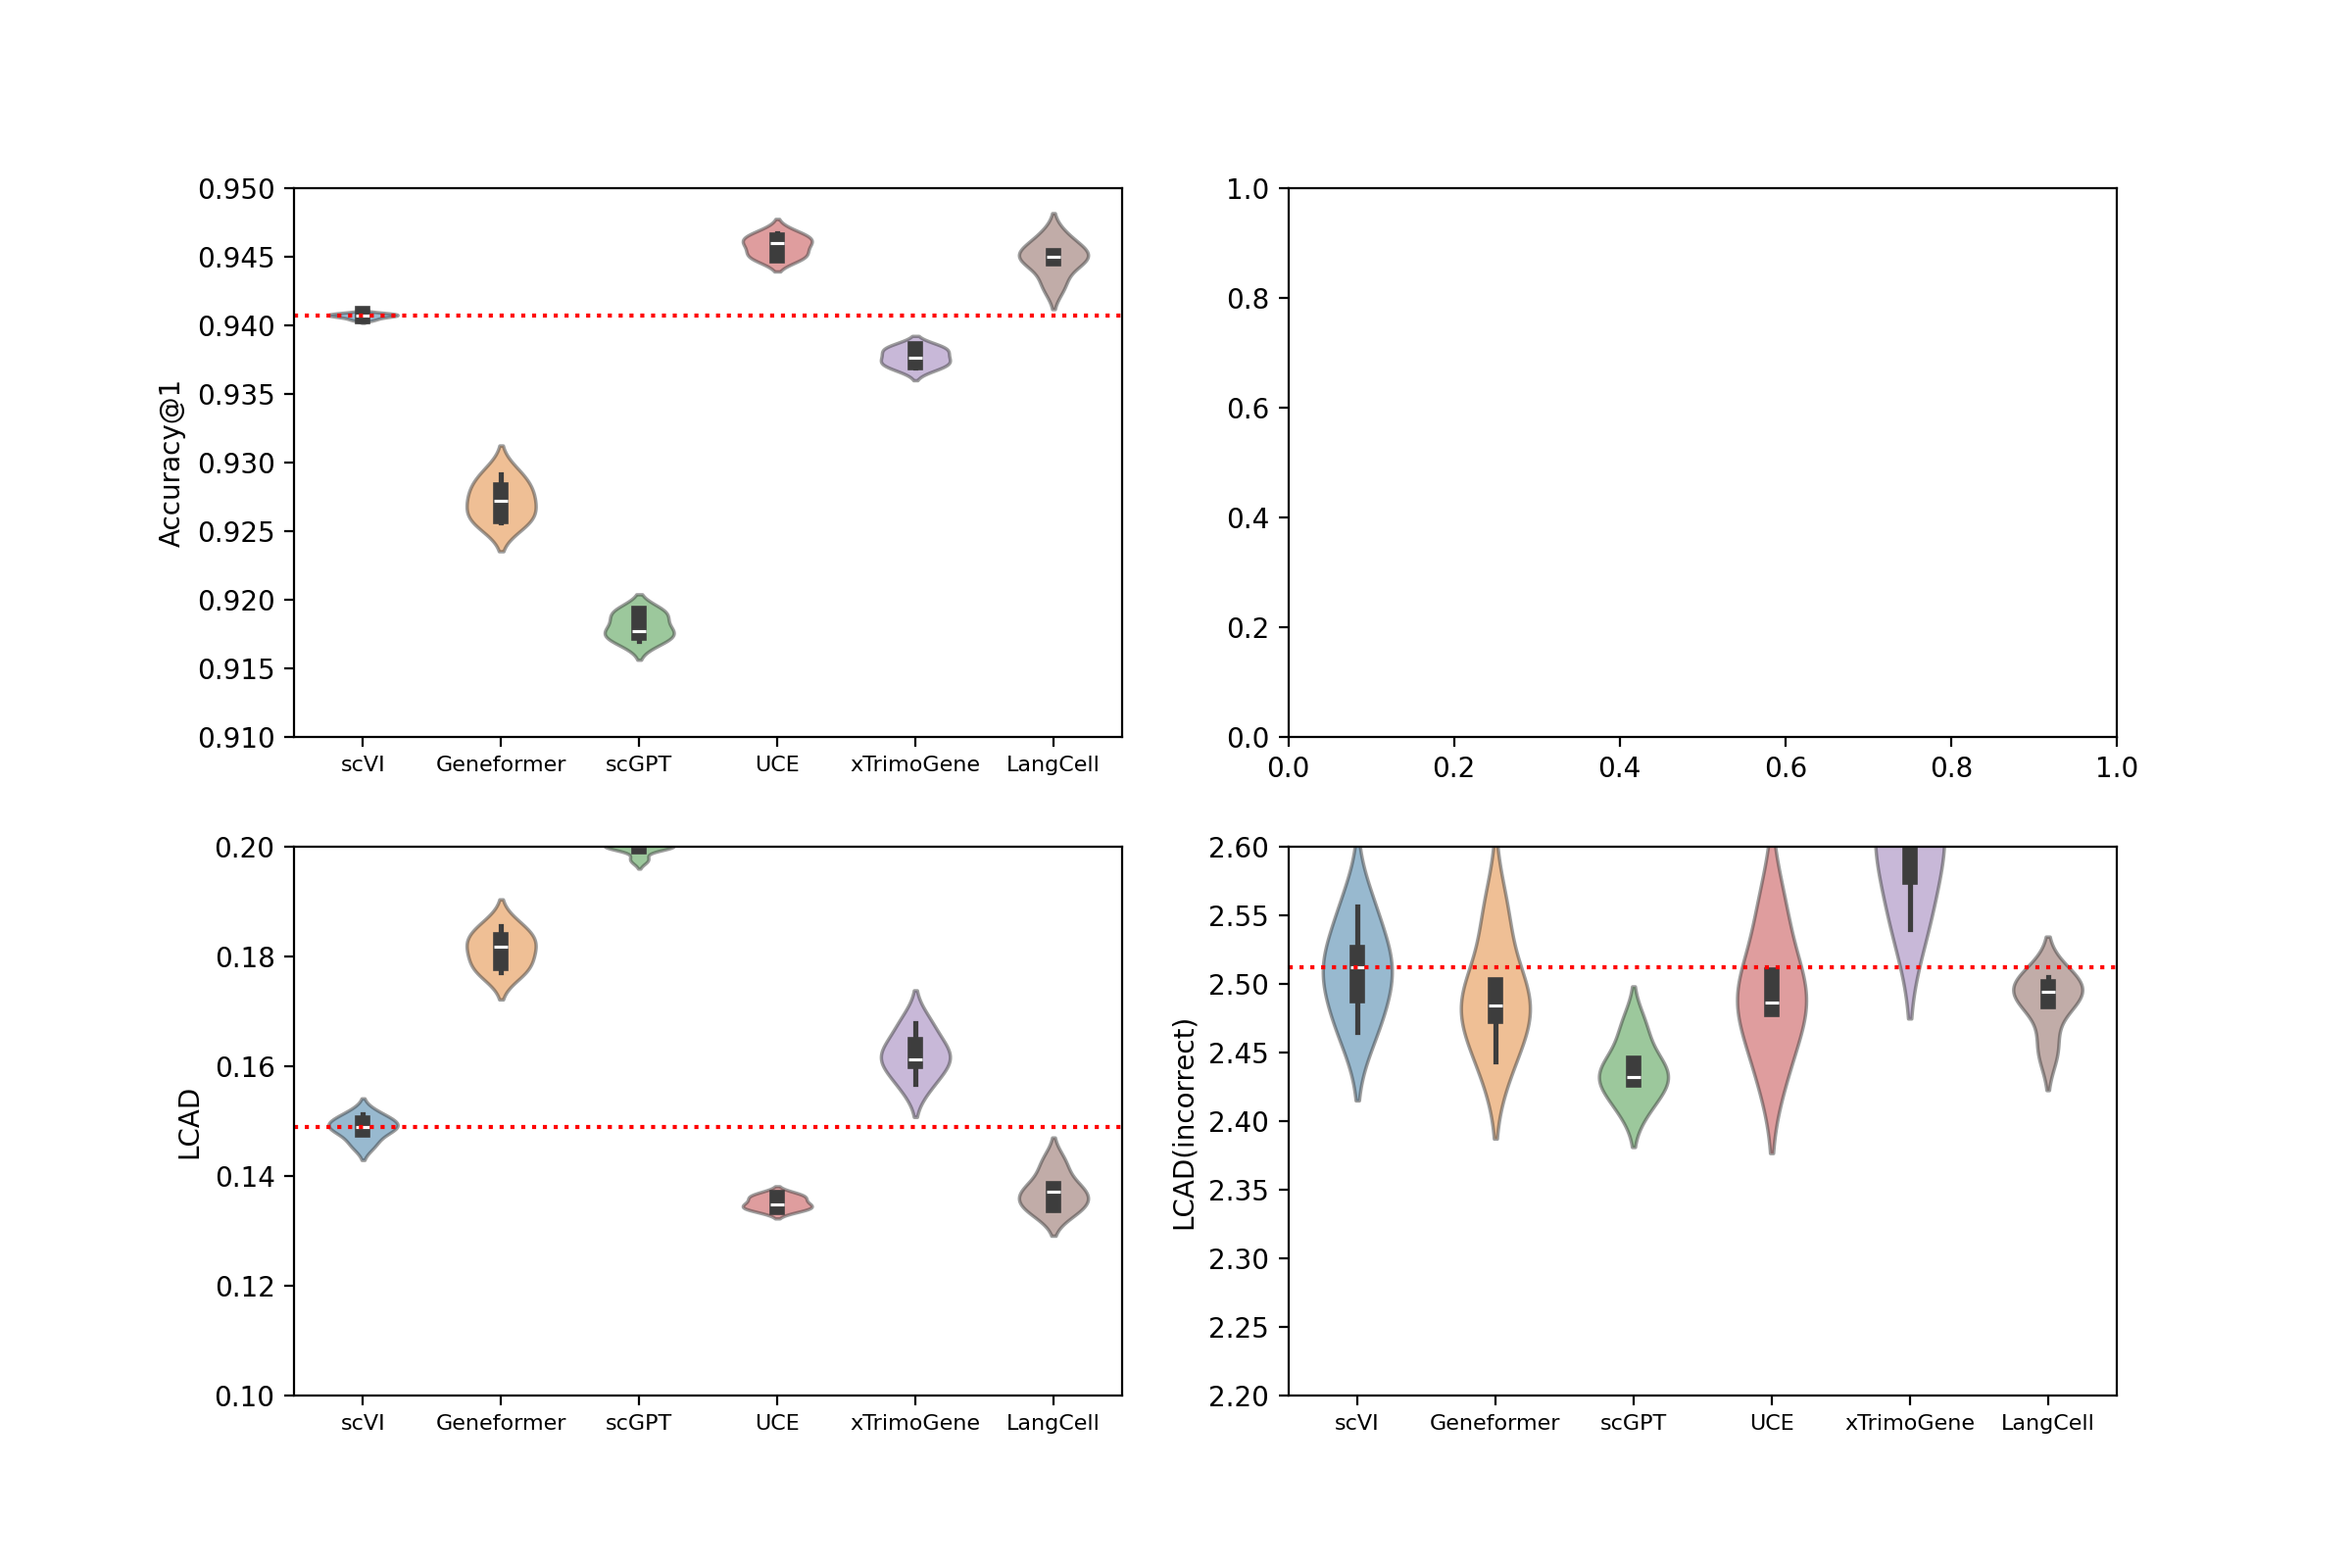

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# sns.barplot(x='model', y='Accuracy@1', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0, 0])
sns.violinplot(x='model', y='Accuracy@1', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,0], inner="box")
axes[0,0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1'].median(), color='r', linestyle=':')
axes[0,0].set_xlabel("")
axes[0,0].tick_params(axis='x', labelsize=8)
axes[0,0].set_ylabel('Accuracy@1')
axes[0,0].set_ylim(0.91, 0.95)
# for p in axes[0,0].patches: 
#     height = p.get_height()
#     axes[0,0].text(p.get_x() + p.get_width() / 2., height+0.005,
#             '{:.3f}'.format(height),
#             ha='center', va='bottom', fontsize=8)

# sns.barplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0,1])
sns.violinplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,1])
axes[0,1].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1(nonleaf)'].median(), color='r', linestyle=':')
axes[0,1].set_xlabel("")
axes[0,1].tick_params(axis='x', labelsize=8)
axes[0,1].set_ylabel('Accuracy@1(nonleaf)')
axes[0,1].set_ylim(0.52, 0.66)

# sns.barplot(x='model', y='LCAD', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,0])
sns.violinplot(x='model', y='LCAD', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,0])
axes[1,0].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD'].median(), color='r', linestyle=':')
axes[1,0].set_xlabel("")
axes[1,0].tick_params(axis='x', labelsize=8)
axes[1,0].set_ylabel('LCAD')
axes[1,0].set_ylim(0.1, 0.2)

# sns.barplot(x='model', y='LCAD(incorrect)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,1])
sns.violinplot(x='model', y='LCAD(incorrect)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,1])
axes[1,1].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD(incorrect)'].median(), color='r', linestyle=':')
axes[1,1].set_xlabel("")
axes[1,1].tick_params(axis='x', labelsize=8)
axes[1,1].set_ylabel('LCAD(incorrect)')
axes[1,1].set_ylim(2.2, 2.6)

plt.savefig("figures/cell_annotation/HLCA_DAG_Yemb.png", dpi=300, bbox_inches="tight")

### unseen_ratio > 0

In [23]:
dataset_name = "HLCA_core"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_unseen_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
        # result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/all_metrics_unseen_{unseen_ratio}.csv")
        result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/softmaxOOD_metrics_unseen_{unseen_ratio}.csv")
        df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
        df["model"] = model
        df["unseen_ratio"] = unseen_ratio
        df_unseen_all = pd.concat([df_unseen_all, df])
df_unseen_all.head()

AUROC(seen)  AUPRC(seen)     AUROC     AUPRC  AUROC(unseen)  AUPRC(unseen)  \
0     0.932356     0.938733  0.922959  0.929848       0.603465       0.627728   
1     0.926634     0.935642  0.916748  0.927144       0.580621       0.638221   
2     0.913683     0.925991  0.904969  0.913931       0.608718       0.503866   
3     0.990564     0.987714  0.980047  0.982195       0.622450       0.794541   
4     0.931864     0.938796  0.923144  0.928084       0.626666       0.563885   

   Accuracy@3  Accuracy@5  Accuracy@1  AUROC_in  AUPRC_in  AUROC_out  \
0    0.784723    0.786982    0.734882  0.819002  0.919845   0.819002   
1    0.755019    0.758250    0.703819  0.721831  0.837942   0.721831   
2    0.871507    0.875602    0.801067  0.797988  0.948157   0.797988   
3    0.705289    0.707495    0.667816  0.886875  0.918259   0.886875   
4    0.850782    0.853592    0.793049  0.850811  0.956454   0.850811   

   AUPRC_out model  unseen_ratio  
0   0.622648  scVI           0.1  
1   0.548131  scVI           0.1  
2   0.432511  scVI           0.1  
3   0.846652  scVI           0.1  
4   0.571888  scVI           0.1

In [24]:
df_grouped = df_unseen_all.groupby(['model', 'unseen_ratio'])['Accuracy@1'].agg(['mean', 'std']).reset_index()
model_mean = df_grouped.pivot(index='unseen_ratio', columns='model', values='mean')
model_std = df_grouped.pivot(index='unseen_ratio', columns='model', values='std')
model_mean

model         Geneformer  LangCell       UCE     scGPT      scVI  xTrimoGene
unseen_ratio                                                                
0.1             0.723953  0.745297  0.749582  0.724088  0.740126    0.737298
0.3             0.564002  0.575836  0.585755  0.562966  0.584044    0.578240
0.5             0.633529  0.653677  0.639539  0.630671  0.654383    0.626644
0.7             0.735319  0.744808  0.754164  0.747958  0.758323    0.737244
0.9             0.898249  0.898261  0.901972  0.901535  0.894897    0.889808

In [25]:
model_mean = model_mean.reset_index().melt(id_vars=['unseen_ratio'])
model_mean

unseen_ratio       model     value
0            0.1  Geneformer  0.723953
1            0.3  Geneformer  0.564002
2            0.5  Geneformer  0.633529
3            0.7  Geneformer  0.735319
4            0.9  Geneformer  0.898249
5            0.1    LangCell  0.745297
6            0.3    LangCell  0.575836
7            0.5    LangCell  0.653677
8            0.7    LangCell  0.744808
9            0.9    LangCell  0.898261
10           0.1         UCE  0.749582
11           0.3         UCE  0.585755
12           0.5         UCE  0.639539
13           0.7         UCE  0.754164
14           0.9         UCE  0.901972
15           0.1       scGPT  0.724088
16           0.3       scGPT  0.562966
17           0.5       scGPT  0.630671
18           0.7       scGPT  0.747958
19           0.9       scGPT  0.901535
20           0.1        scVI  0.740126
21           0.3        scVI  0.584044
22           0.5        scVI  0.654383
23           0.7        scVI  0.758323
24           0.9        scVI  0.894897
25           0.1  xTrimoGene  0.737298
26           0.3  xTrimoGene  0.578240
27           0.5  xTrimoGene  0.626644
28           0.7  xTrimoGene  0.737244
29           0.9  xTrimoGene  0.889808

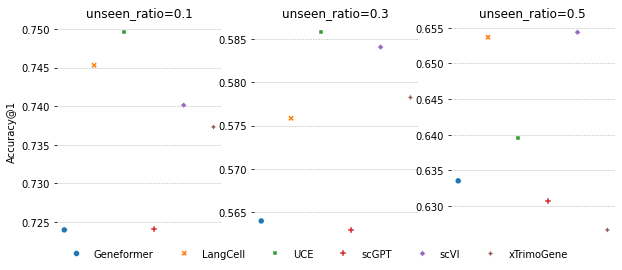

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=False)
df_grouped = model_mean.groupby("unseen_ratio")
for i, unseen_r in enumerate([0.1, 0.3, 0.5]):
    df_model = df_grouped.get_group(unseen_r)
    if i > 0:
        sns.scatterplot(data=df_model, x="model", y="value", hue="model", style="model", ax=axes[i], legend=False)
        axes[i].set_ylabel("")
    else:
        sns.scatterplot(data=df_model, x="model", y="value", hue="model", style="model", ax=axes[i], legend=True)
        # sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1), title=None, frameon=False, fontsize=6) # title_fontsize
        axes[i].legend(loc='upper left', bbox_to_anchor=(0, 0), ncol=6, title=None, frameon=False, fontsize=10)
        axes[i].set_ylabel("Accuracy@1")
    
    # mean_value = df_model["Pearson-PCA"].mean()
    # axes[i].axhline(y=mean_value, color='purple', linestyle='--')
    # axes[i].text(1, mean_value+0.01, f'{mean_value:.3f}', color='purple', fontsize=8) 
    
    # axes[i].set_xticklabels([])
    # axes[i].set_xlabel("")
    axes[i].xaxis.set_visible(False)
    axes[i].set_title(f"unseen_ratio={unseen_r}")
    # 删除子图边框
    for spine in ['top', 'right', 'bottom', 'left']:
        axes[i].spines[spine].set_visible(False)

    # 添加网格线
    axes[i].grid(True, which='major', linestyle='--', linewidth=0.5, axis="y")

Text(0, 0.5, 'Accuracy@1')

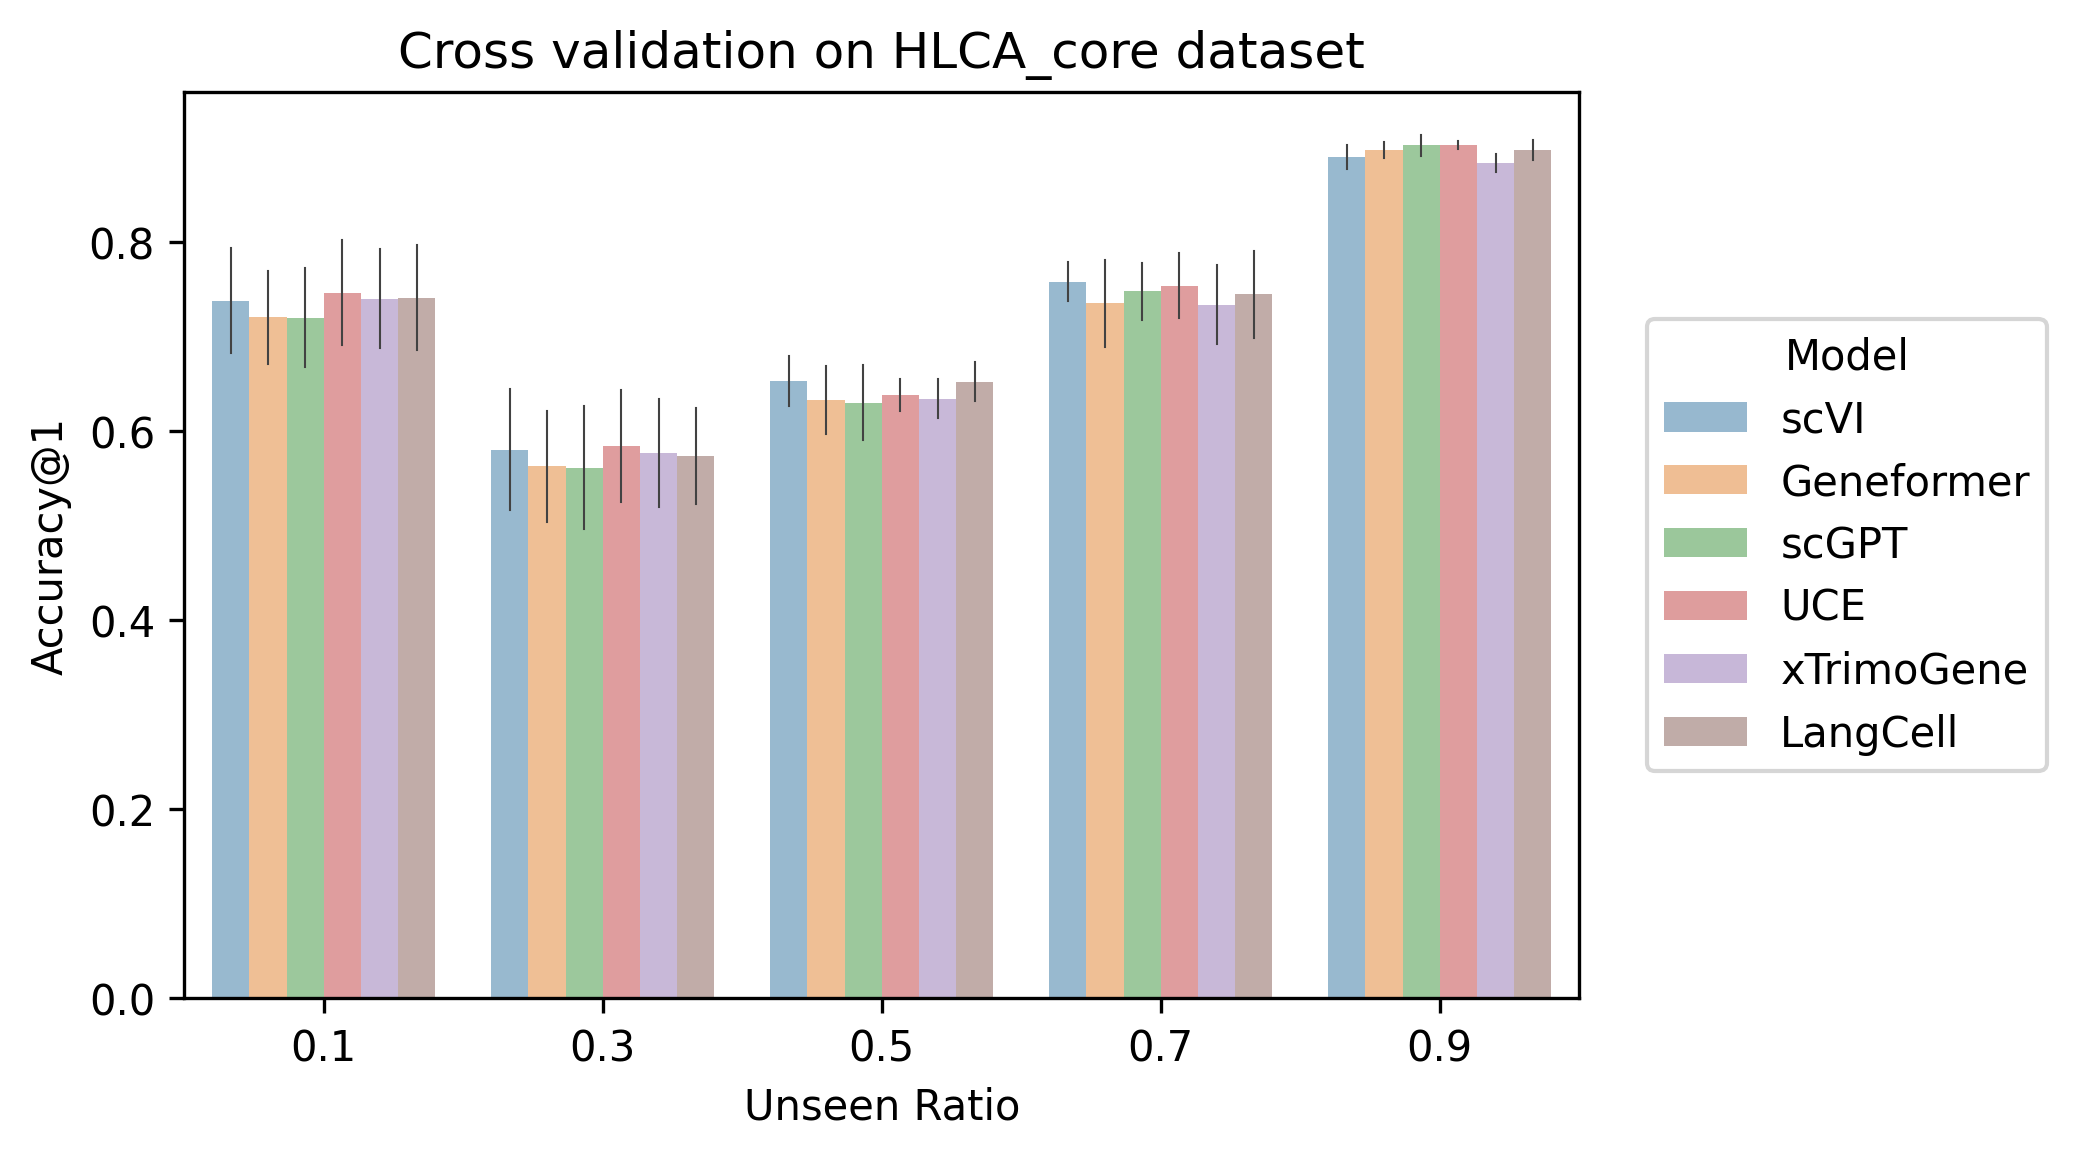

In [16]:
plt.figure(dpi=300)
sns.barplot(x='unseen_ratio', y='Accuracy@1', hue='model', data=df_unseen_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 0.5})
plt.legend(title='Model', loc='right', bbox_to_anchor=(1.35, 0.5))
plt.title('Cross validation on HLCA_core dataset')
plt.xlabel('Unseen Ratio')
plt.ylabel('Accuracy@1')

Text(0, 0.5, 'Accuracy@3')

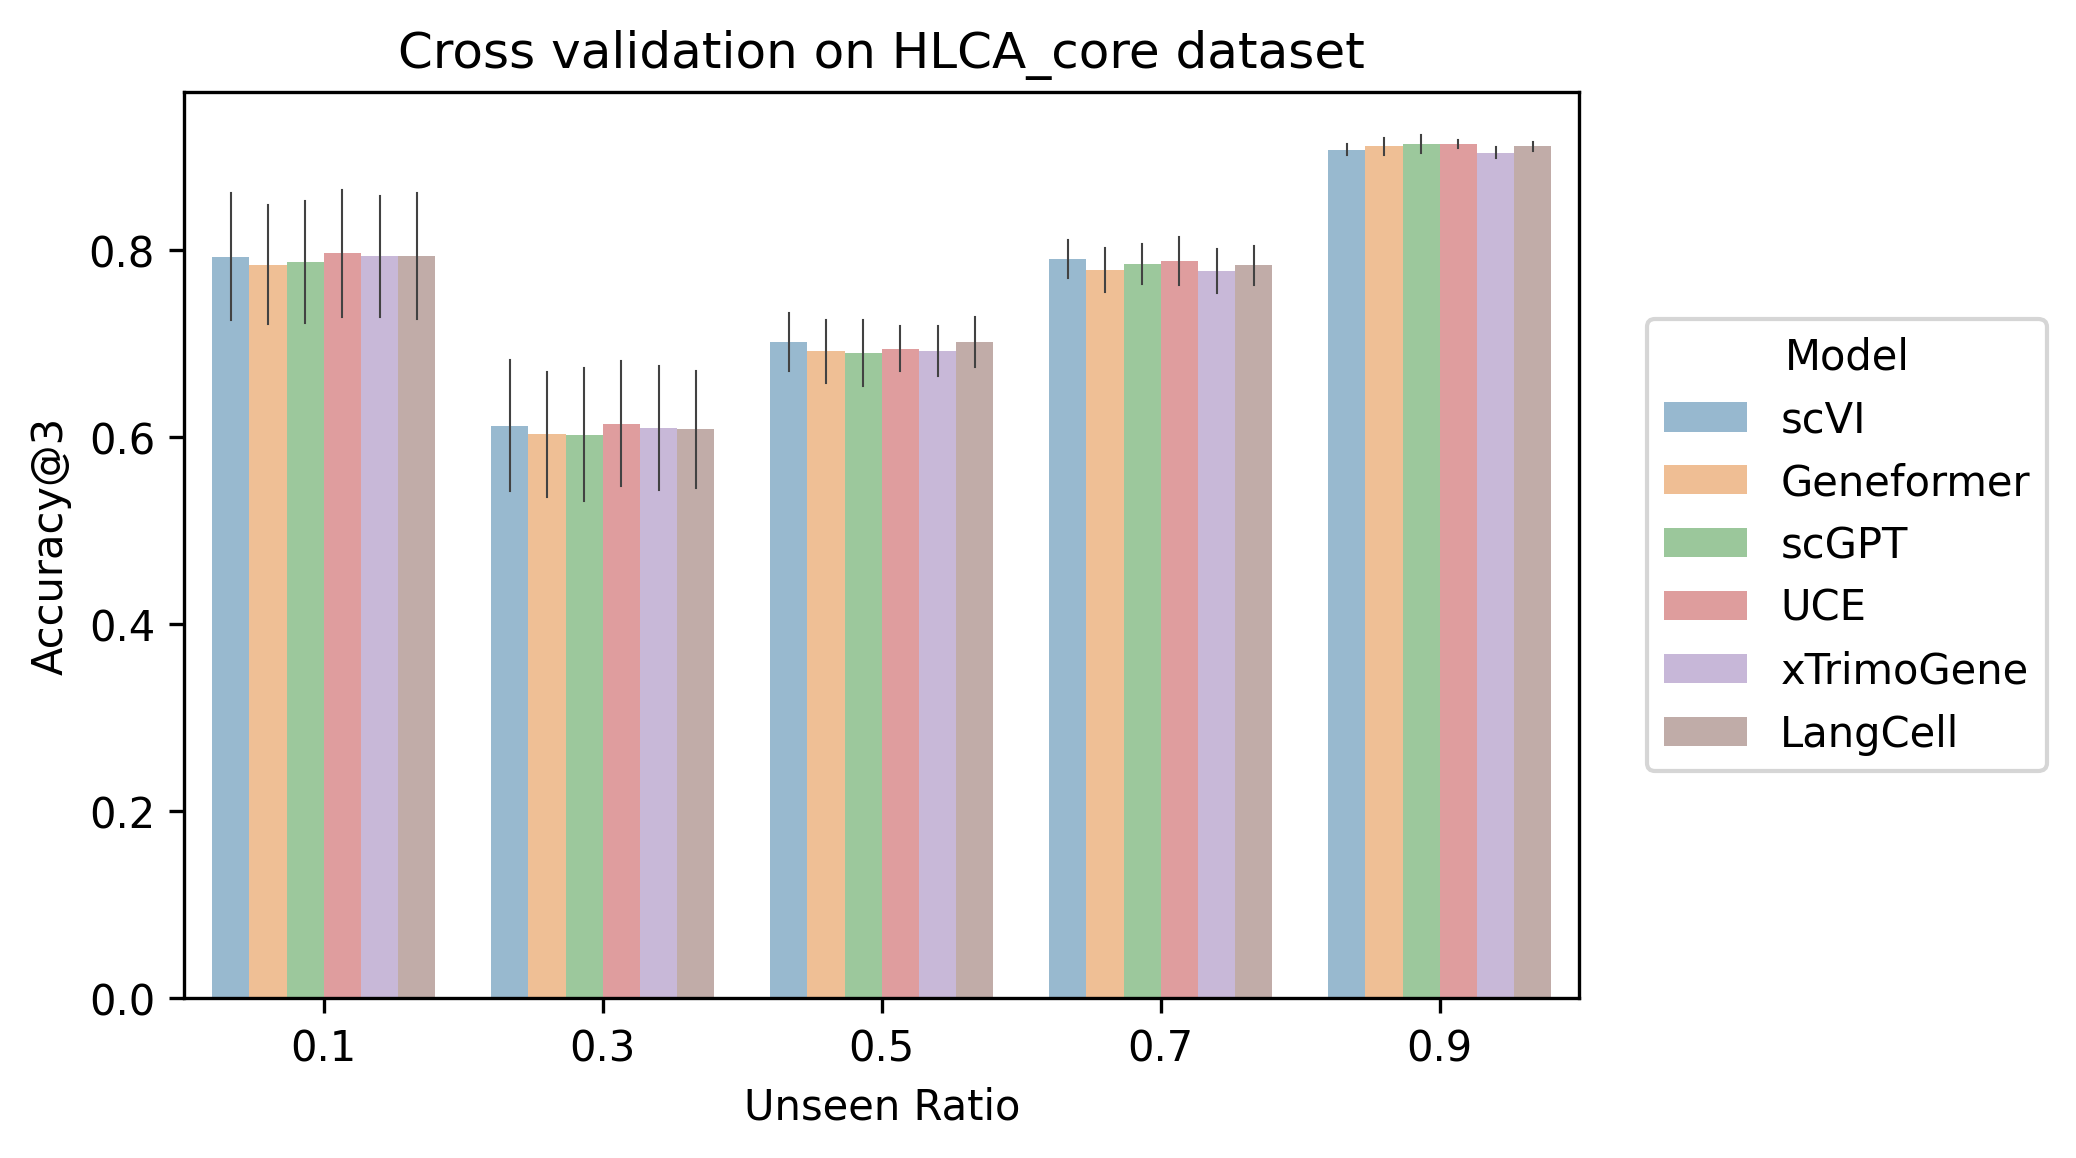

In [17]:
plt.figure(dpi=300)
sns.barplot(x='unseen_ratio', y='Accuracy@3', hue='model', data=df_unseen_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 0.5})
plt.legend(title='Model', loc='right', bbox_to_anchor=(1.35, 0.5))
plt.title('Cross validation on HLCA_core dataset')
plt.xlabel('Unseen Ratio')
plt.ylabel('Accuracy@3')

Text(0, 0.5, 'AUROC(unseen)')

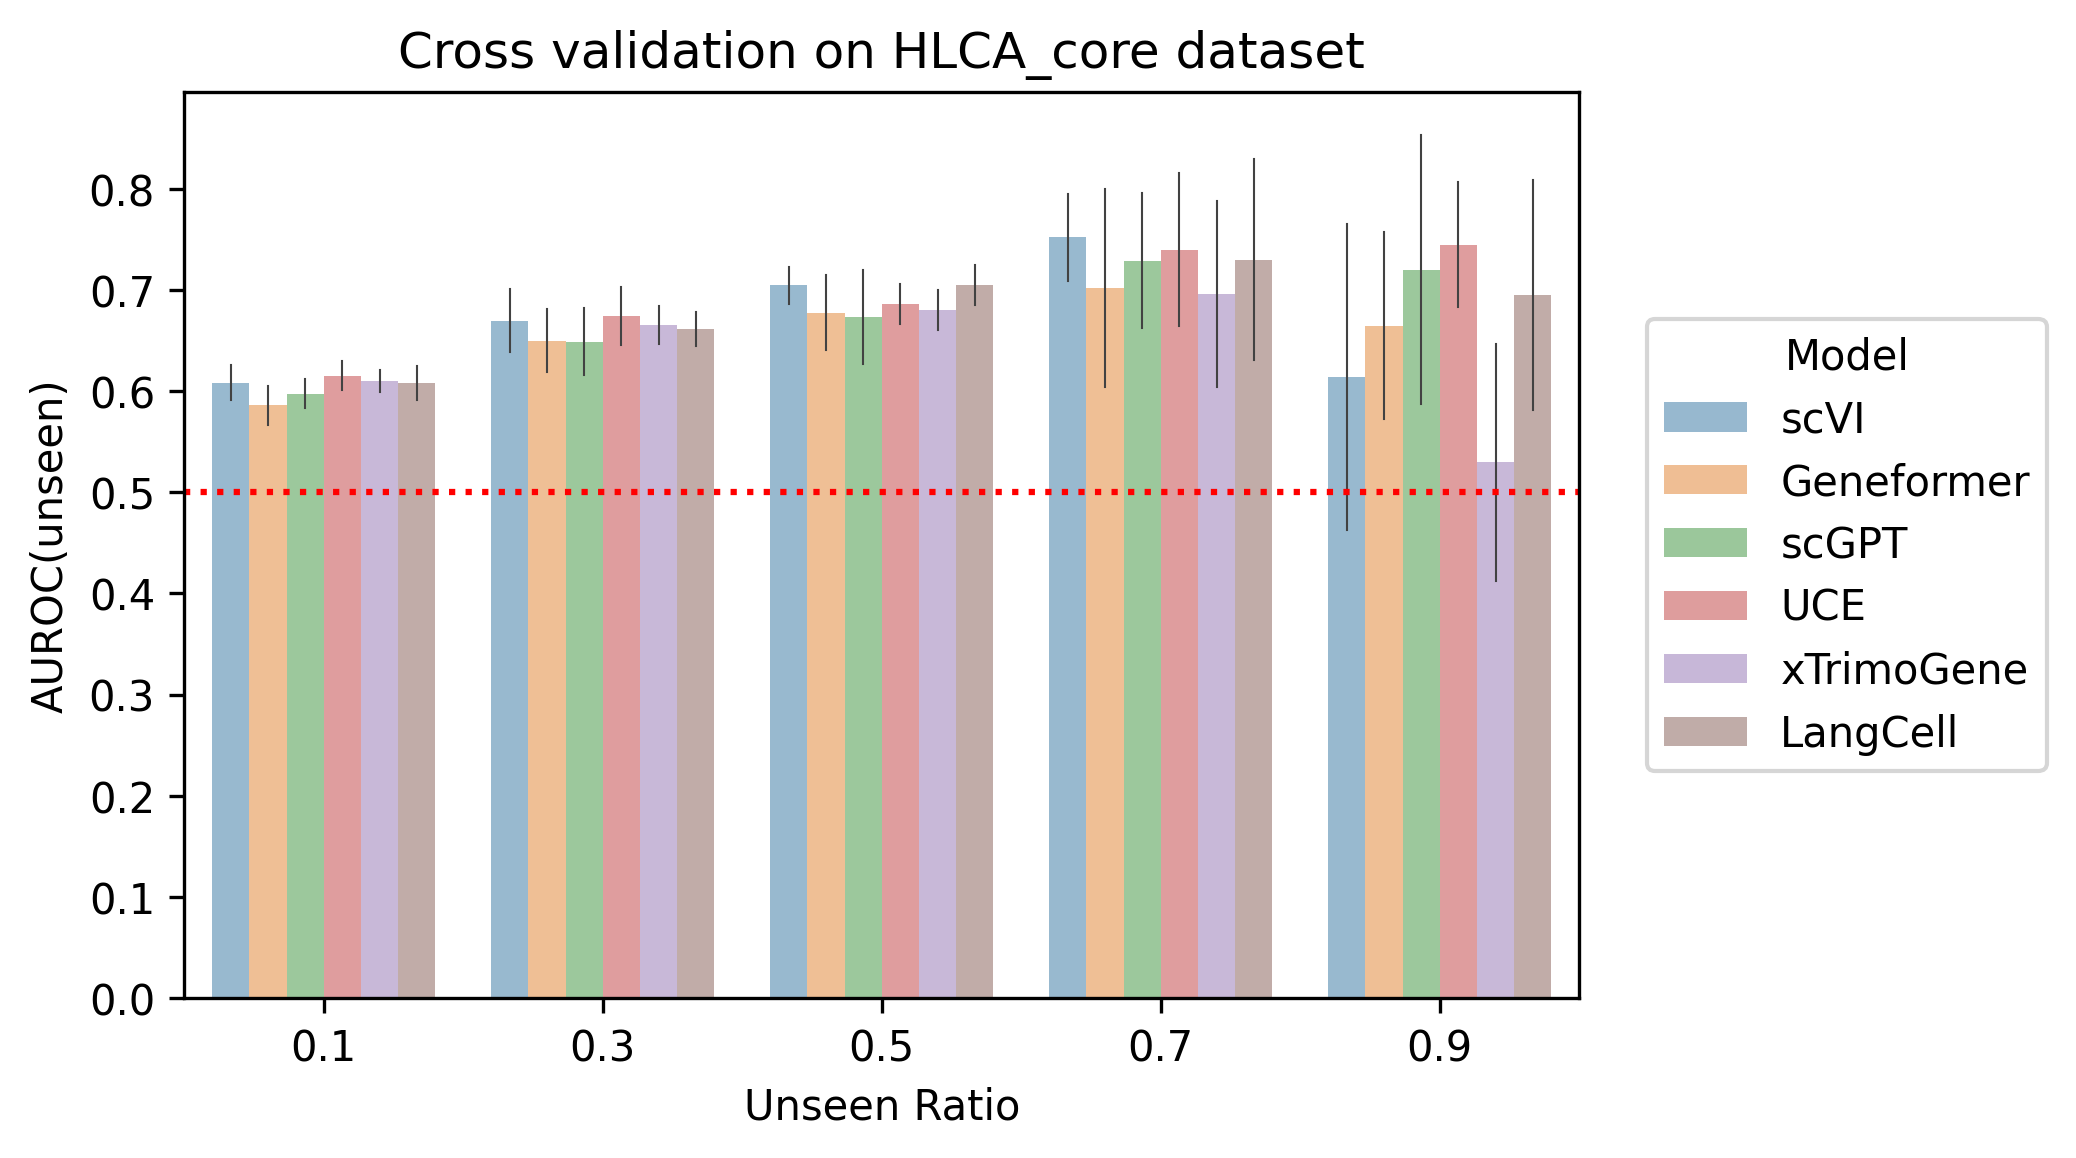

In [9]:
plt.figure(dpi=300)
sns.barplot(x='unseen_ratio', y='AUROC(unseen)', hue='model', data=df_unseen_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 0.5})
plt.axhline(y=0.5, color='r', linestyle=':')
plt.legend(title='Model', loc='right', bbox_to_anchor=(1.35, 0.5))
plt.title('Cross validation on HLCA_core dataset')
plt.xlabel('Unseen Ratio')
plt.ylabel('AUROC(unseen)')

Text(0, 0.5, 'AUPRC(unseen)')

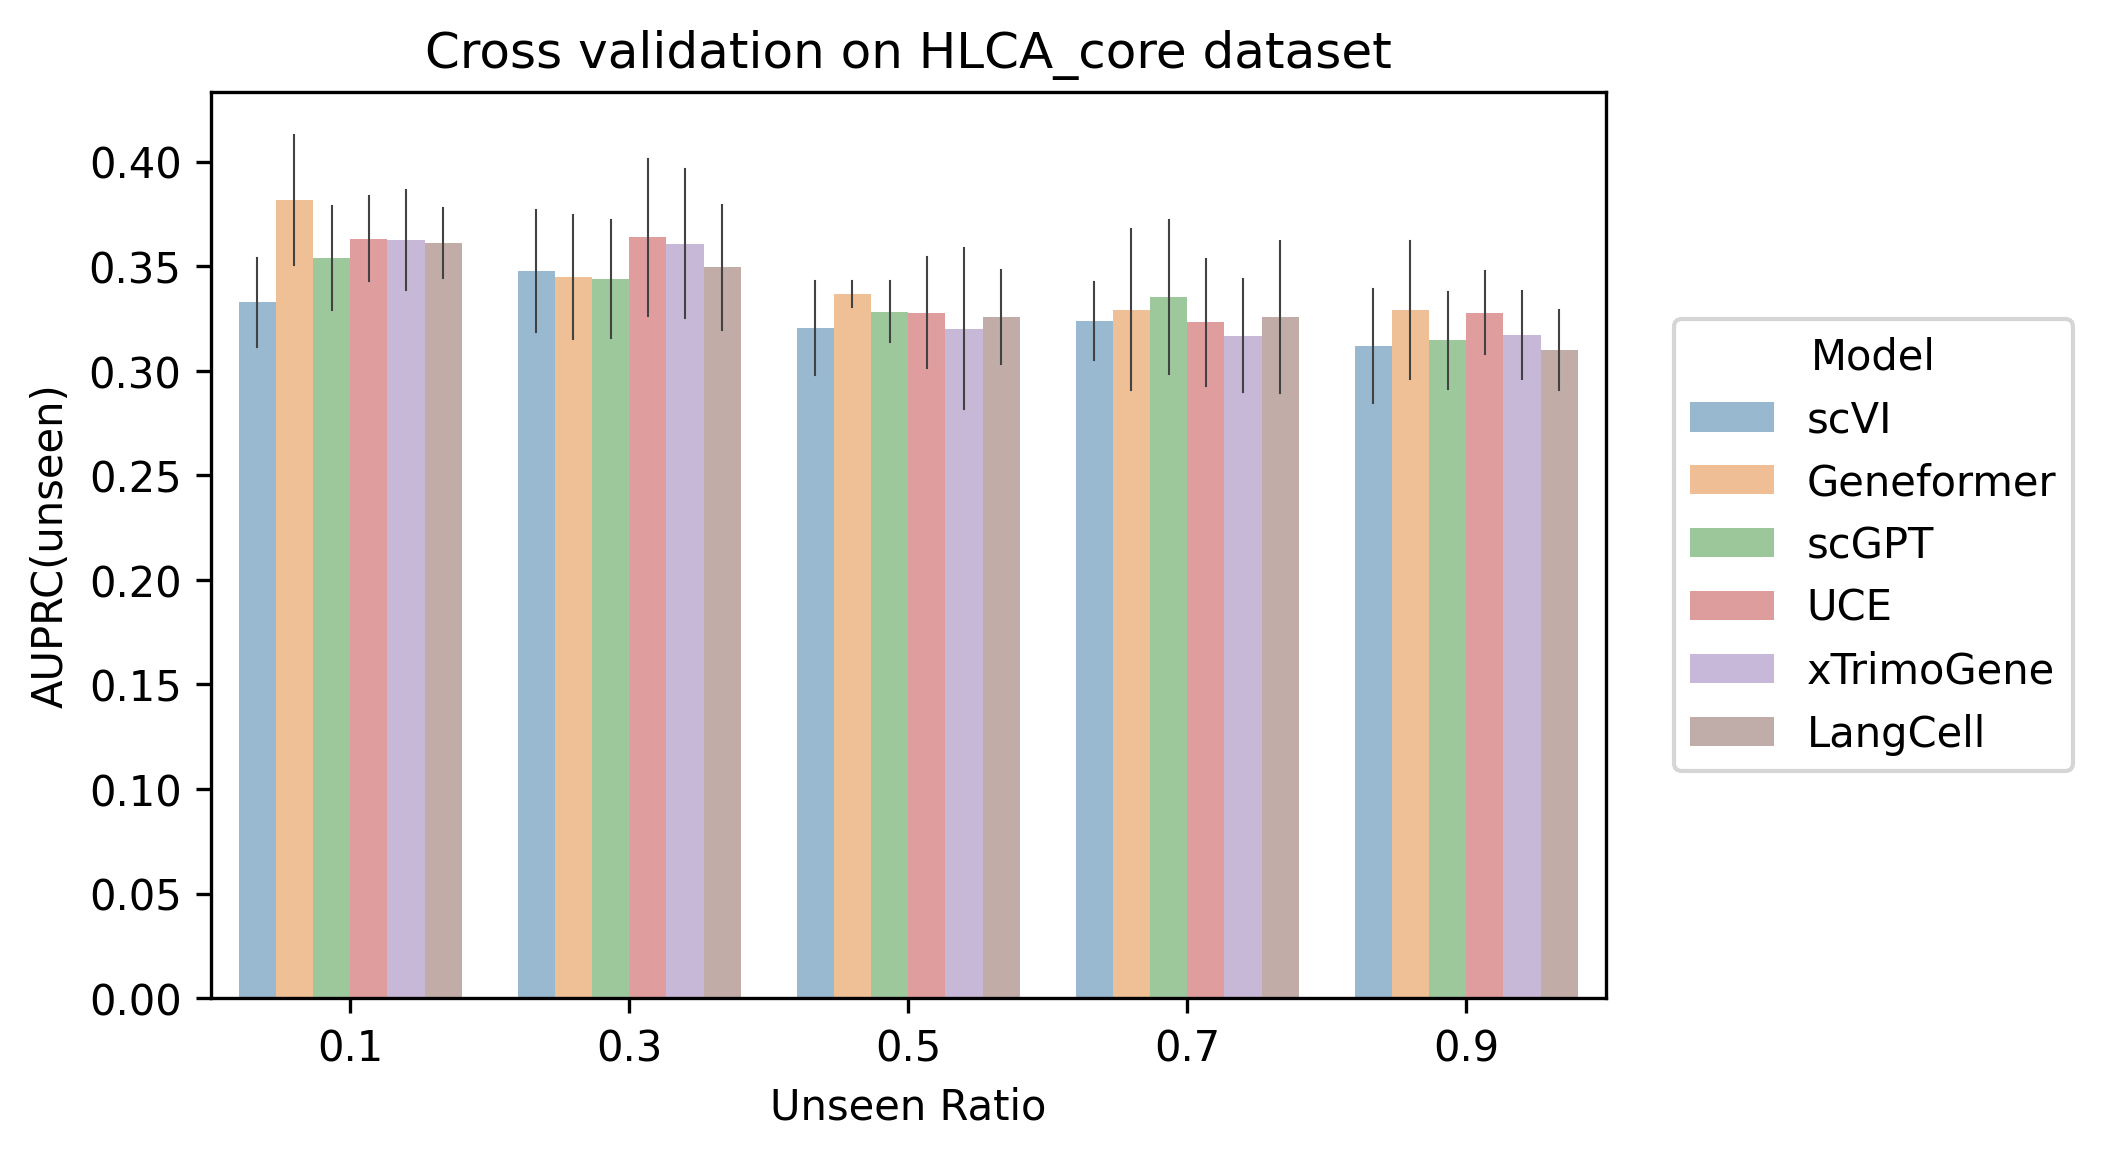

In [122]:
plt.figure(dpi=300)
sns.barplot(x='unseen_ratio', y='AUPRC(unseen)', hue='model', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 0.5})
plt.legend(title='Model', loc='right', bbox_to_anchor=(1.35, 0.5))
plt.title('Cross validation on HLCA_core dataset')
plt.xlabel('Unseen Ratio')
plt.ylabel('AUPRC(unseen)')

#### Accuracy under specified FPR

In [37]:
model_ls = ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
result_ls = []
dataset_name = "HLCA_core"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
for unseen_ratio in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y_pred_ls = []
    unseen_confidence_ls = []
    for model in model_ls:
        for iter in range(5):
            result_file = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/{iter}/{unseen_ratio}/pred_label.csv")
            df = pd.read_csv(result_file)
            unseen_label = df["unseen"]
            y_true = df["y_true"]
            unseen_pred = 1-df["prob"]
            y_pred = df["y_pred"]

            result = {
                "model": model,
                "unseen_ratio": unseen_ratio,
                "iter": iter,
            }

            for FPR in [0.05, 0.1, 0.2]:
                cut_off_ratio, number_unkonw = get_FPR(df[df["unseen"]==1].prob, FPR=FPR)
                acc_unknown = accuracy_for_unkonw(y_pred, df["prob"], y_true, number_unkonw, cut_off_ratio=cut_off_ratio)
                result.update({f"Accuracy(FPR={FPR})": acc_unknown})

            result_ls.append(result)
result_df = pd.DataFrame(result_ls)
result_df

model  unseen_ratio  iter  Accuracy(FPR=0.05)  Accuracy(FPR=0.1)  \
0        scVI           0.1     0            0.453457           0.578037   
1        scVI           0.1     1            0.168819           0.291152   
2        scVI           0.1     2            0.385059           0.508362   
3        scVI           0.1     3            0.471084           0.631628   
4        scVI           0.1     4            0.597406           0.696709   
..        ...           ...   ...                 ...                ...   
145  LangCell           0.9     0            0.000000           0.607005   
146  LangCell           0.9     1            0.359336           0.624478   
147  LangCell           0.9     2            0.621171           0.694561   
148  LangCell           0.9     3            0.000000           0.594219   
149  LangCell           0.9     4            0.765233           0.863082   

     Accuracy(FPR=0.2)  
0             0.710785  
1             0.485179  
2             0.650819  
3             0.777612  
4             0.791845  
..                 ...  
145           0.913308  
146           0.801587  
147           0.783045  
148           0.859342  
149           0.918160  

[150 rows x 6 columns]

In [38]:
result_df.to_csv("./figures/hlca_accuracy_unseen.csv",index=False)

/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


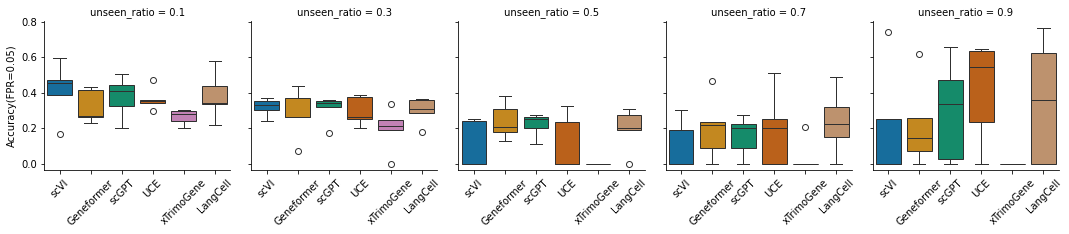

In [39]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.05)", data=result_df, hue="model", palette="colorblind")
# grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('', "Accuracy(FPR=0.05)")
grid.set_xticklabels(rotation=45)

/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


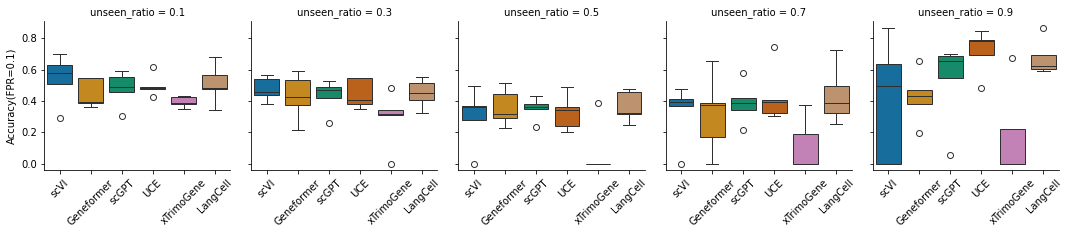

In [40]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.1)", data=result_df, hue="model", palette="colorblind")
# grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('', "Accuracy(FPR=0.1)")
grid.set_xticklabels(rotation=45)

/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


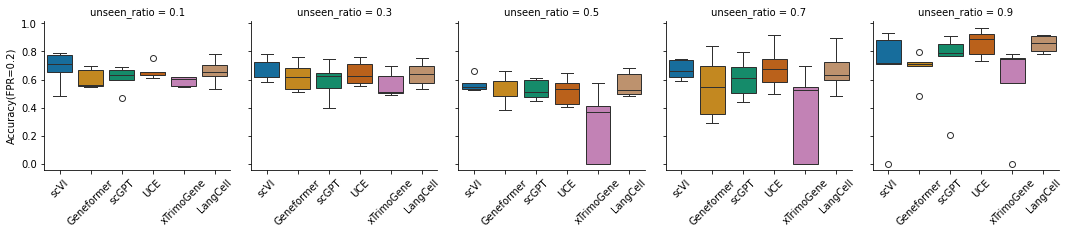

In [41]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.2)", data=result_df, hue="model", palette="colorblind")
# grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('', "Accuracy(FPR=0.2)")
grid.set_xticklabels(rotation=45)

## Tabula Sapiens

### unseen_ratio = 0

In [ ]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    # for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
    for unseen_ratio in [0]:
        result_path = os.path.join(output_folder, model, dataset_name, f"lr_0.0005_l2_1e-05/all_metrics_unseen_{unseen_ratio}.csv")
        df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
        df["model"] = model
        df["unseen_ratio"] = unseen_ratio
        df_all = pd.concat([df_all, df])
df_all.head()

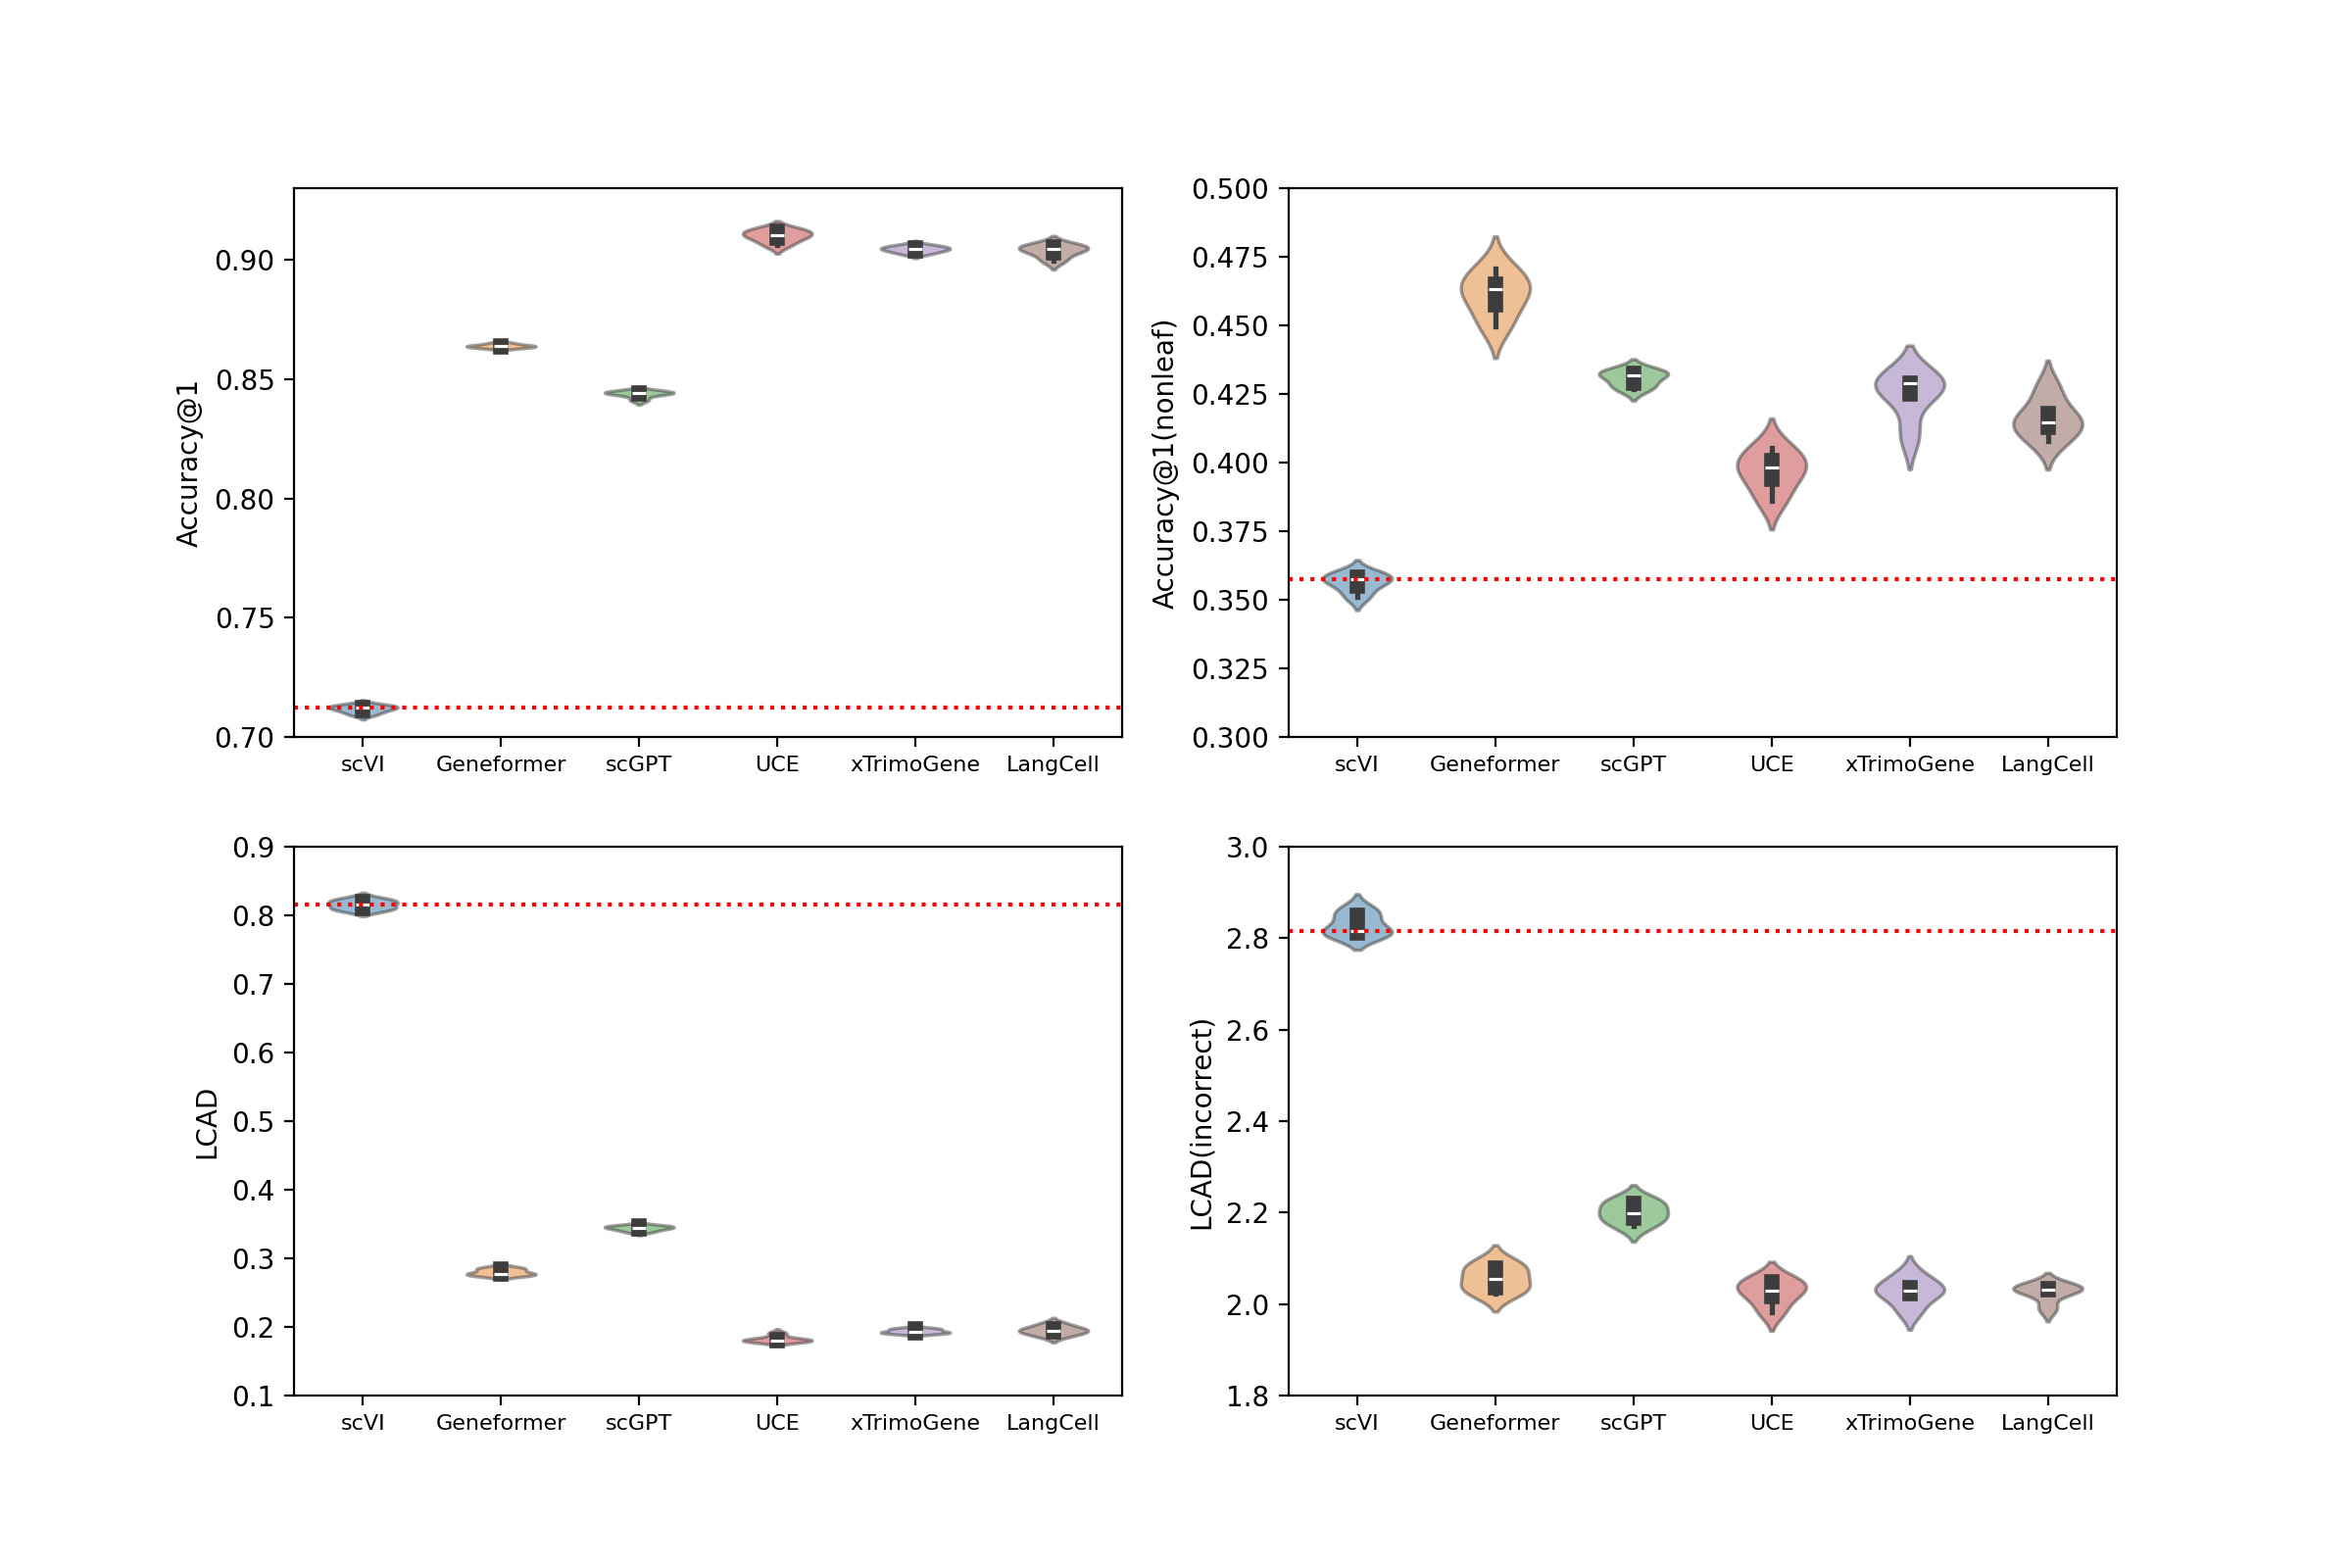

In [35]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# sns.barplot(x='model', y='Accuracy@1', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0, 0])
sns.violinplot(x='model', y='Accuracy@1', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,0], inner="box")
axes[0,0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1'].median(), color='r', linestyle=':')
axes[0,0].set_xlabel("")
axes[0,0].tick_params(axis='x', labelsize=8)
axes[0,0].set_ylabel('Accuracy@1')
axes[0,0].set_ylim(0.7, 0.93)
# for p in axes[0,0].patches: 
#     height = p.get_height()
#     axes[0,0].text(p.get_x() + p.get_width() / 2., height+0.005,
#             '{:.3f}'.format(height),
#             ha='center', va='bottom', fontsize=8)

# sns.barplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0,1])
sns.violinplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,1])
axes[0,1].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1(nonleaf)'].median(), color='r', linestyle=':')
axes[0,1].set_xlabel("")
axes[0,1].tick_params(axis='x', labelsize=8)
axes[0,1].set_ylabel('Accuracy@1(nonleaf)')
axes[0,1].set_ylim(0.3, 0.5)

# sns.barplot(x='model', y='LCAD', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,0])
sns.violinplot(x='model', y='LCAD', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,0])
axes[1,0].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD'].median(), color='r', linestyle=':')
axes[1,0].set_xlabel("")
axes[1,0].tick_params(axis='x', labelsize=8)
axes[1,0].set_ylabel('LCAD')
axes[1,0].set_ylim(0.1, 0.9)

# sns.barplot(x='model', y='LCAD(incorrect)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,1])
sns.violinplot(x='model', y='LCAD(incorrect)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,1])
axes[1,1].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD(incorrect)'].median(), color='r', linestyle=':')
axes[1,1].set_xlabel("")
axes[1,1].tick_params(axis='x', labelsize=8)
axes[1,1].set_ylabel('LCAD(incorrect)')
axes[1,1].set_ylim(1.8,3)

plt.savefig("figures/cell_annotation/Tabula_MLP.png", dpi=300, bbox_inches="tight")

In [89]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    # for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
    for unseen_ratio in [0]:
        result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.0005_l2_1e-05/all_metrics_unseen_{unseen_ratio}.csv")
        df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
        df["model"] = model
        df["unseen_ratio"] = unseen_ratio
        df_all = pd.concat([df_all, df])
df_all.head()

AUROC(seen)  AUPRC(seen)   AUROC   AUPRC  AUROC(unseen)  AUPRC(unseen)  \
0       0.9890       0.9677  0.9890  0.9677            NaN            NaN   
1       0.9890       0.9685  0.9890  0.9685            NaN            NaN   
2       0.9888       0.9685  0.9888  0.9685            NaN            NaN   
3       0.9888       0.9696  0.9888  0.9696            NaN            NaN   
4       0.9886       0.9676  0.9886  0.9676            NaN            NaN   

   Accuracy@3  Accuracy@5  Accuracy@1  Accuracy@1(nonleaf)    LCAD  \
0      0.8897      0.9382      0.7295               0.3666  0.7640   
1      0.8904      0.9389      0.7283               0.3677  0.7641   
2      0.8899      0.9375      0.7297               0.3571  0.7722   
3      0.8887      0.9375      0.7245               0.3604  0.7820   
4      0.8900      0.9381      0.7307               0.3600  0.7643   

   LCAD(incorrect) model  unseen_ratio  
0           2.8249  scVI             0  
1           2.8121  scVI             0  
2           2.8569  scVI             0  
3           2.8390  scVI             0  
4           2.8387  scVI             0

#### calculate F1 score

In [90]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
macro_f1_ls = []
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    for iter in range(5):
        result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.0005_l2_1e-05/{iter}/0/pred_label.csv")
        df = pd.read_csv(result_path)
        y_true = df["y_true"]
        y_pred = df["y_pred"]
        macro_f1 = f1_score(y_true, y_pred, average="macro")
        macro_f1_ls.append(macro_f1)
df_all["Macro F1"] = macro_f1_ls
df_all.head()

AUROC(seen)  AUPRC(seen)   AUROC   AUPRC  AUROC(unseen)  AUPRC(unseen)  \
0       0.9890       0.9677  0.9890  0.9677            NaN            NaN   
1       0.9890       0.9685  0.9890  0.9685            NaN            NaN   
2       0.9888       0.9685  0.9888  0.9685            NaN            NaN   
3       0.9888       0.9696  0.9888  0.9696            NaN            NaN   
4       0.9886       0.9676  0.9886  0.9676            NaN            NaN   

   Accuracy@3  Accuracy@5  Accuracy@1  Accuracy@1(nonleaf)    LCAD  \
0      0.8897      0.9382      0.7295               0.3666  0.7640   
1      0.8904      0.9389      0.7283               0.3677  0.7641   
2      0.8899      0.9375      0.7297               0.3571  0.7722   
3      0.8887      0.9375      0.7245               0.3604  0.7820   
4      0.8900      0.9381      0.7307               0.3600  0.7643   

   LCAD(incorrect) model  unseen_ratio  Macro F1  
0           2.8249  scVI             0    0.5193  
1           2.8121  scVI             0    0.5082  
2           2.8569  scVI             0    0.4985  
3           2.8390  scVI             0    0.5041  
4           2.8387  scVI             0    0.5139

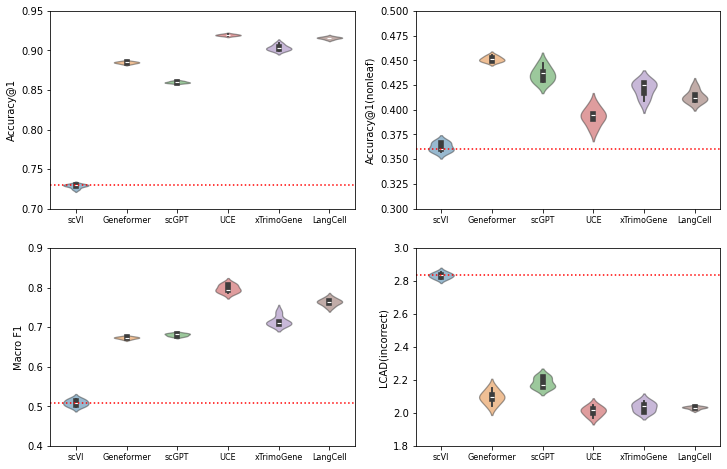

In [92]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# sns.barplot(x='model', y='Accuracy@1', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0, 0])
sns.violinplot(x='model', y='Accuracy@1', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,0], inner="box")
axes[0,0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1'].median(), color='r', linestyle=':')
axes[0,0].set_xlabel("")
axes[0,0].tick_params(axis='x', labelsize=8)
axes[0,0].set_ylabel('Accuracy@1')
axes[0,0].set_ylim(0.7, 0.95)
# for p in axes[0,0].patches: 
#     height = p.get_height()
#     axes[0,0].text(p.get_x() + p.get_width() / 2., height+0.005,
#             '{:.3f}'.format(height),
#             ha='center', va='bottom', fontsize=8)

# sns.barplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0,1])
sns.violinplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,1])
axes[0,1].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1(nonleaf)'].median(), color='r', linestyle=':')
axes[0,1].set_xlabel("")
axes[0,1].tick_params(axis='x', labelsize=8)
axes[0,1].set_ylabel('Accuracy@1(nonleaf)')
axes[0,1].set_ylim(0.3, 0.5)

# sns.barplot(x='model', y='LCAD', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,0])
sns.violinplot(x='model', y='Macro F1', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,0])
axes[1,0].axhline(y=df_all[df_all["model"]=="scVI"]['Macro F1'].median(), color='r', linestyle=':')
axes[1,0].set_xlabel("")
axes[1,0].tick_params(axis='x', labelsize=8)
axes[1,0].set_ylabel('Macro F1')
axes[1,0].set_ylim(0.4, 0.9)

# sns.barplot(x='model', y='LCAD(incorrect)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,1])
sns.violinplot(x='model', y='LCAD(incorrect)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,1])
axes[1,1].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD(incorrect)'].median(), color='r', linestyle=':')
axes[1,1].set_xlabel("")
axes[1,1].tick_params(axis='x', labelsize=8)
axes[1,1].set_ylabel('LCAD(incorrect)')
axes[1,1].set_ylim(1.8,3)

plt.savefig("figures/cell_annotation/Tabula_Onclass_Yemb.png", dpi=300, bbox_inches="tight")

In [32]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    # for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
    for unseen_ratio in [0]:
        result_path = os.path.join(output_folder, model, dataset_name, f"lr_0.0005_l2_1e-05/all_metrics_unseen_{unseen_ratio}.csv")
        df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
        df["model"] = model
        df["unseen_ratio"] = unseen_ratio
        df_all = pd.concat([df_all, df])
df_all.head()

AUROC(seen)  AUPRC(seen)     AUROC     AUPRC  AUROC(unseen)  AUPRC(unseen)  \
0     0.984392     0.957100  0.984392  0.957100            NaN            NaN   
1     0.984543     0.959149  0.984543  0.959149            NaN            NaN   
2     0.984825     0.959119  0.984825  0.959119            NaN            NaN   
3     0.983681     0.956171  0.983681  0.956171            NaN            NaN   
4     0.984161     0.957124  0.984161  0.957124            NaN            NaN   

   Accuracy@3  Accuracy@5  Accuracy@1  Accuracy@1(nonleaf)      LCAD  \
0    0.874868    0.924672    0.712480             0.351092  0.809452   
1    0.872752    0.923688    0.711013             0.355155  0.823430   
2    0.874478    0.924690    0.713297             0.359633  0.820330   
3    0.870338    0.921925    0.709510             0.358278  0.816228   
4    0.874088    0.925841    0.712368             0.357469  0.808450   

   LCAD(incorrect) model  unseen_ratio  
0         2.815288  scVI             0  
1         2.849371  scVI             0  
2         2.861250  scVI             0  
3         2.809828  scVI             0  
4         2.810713  scVI             0

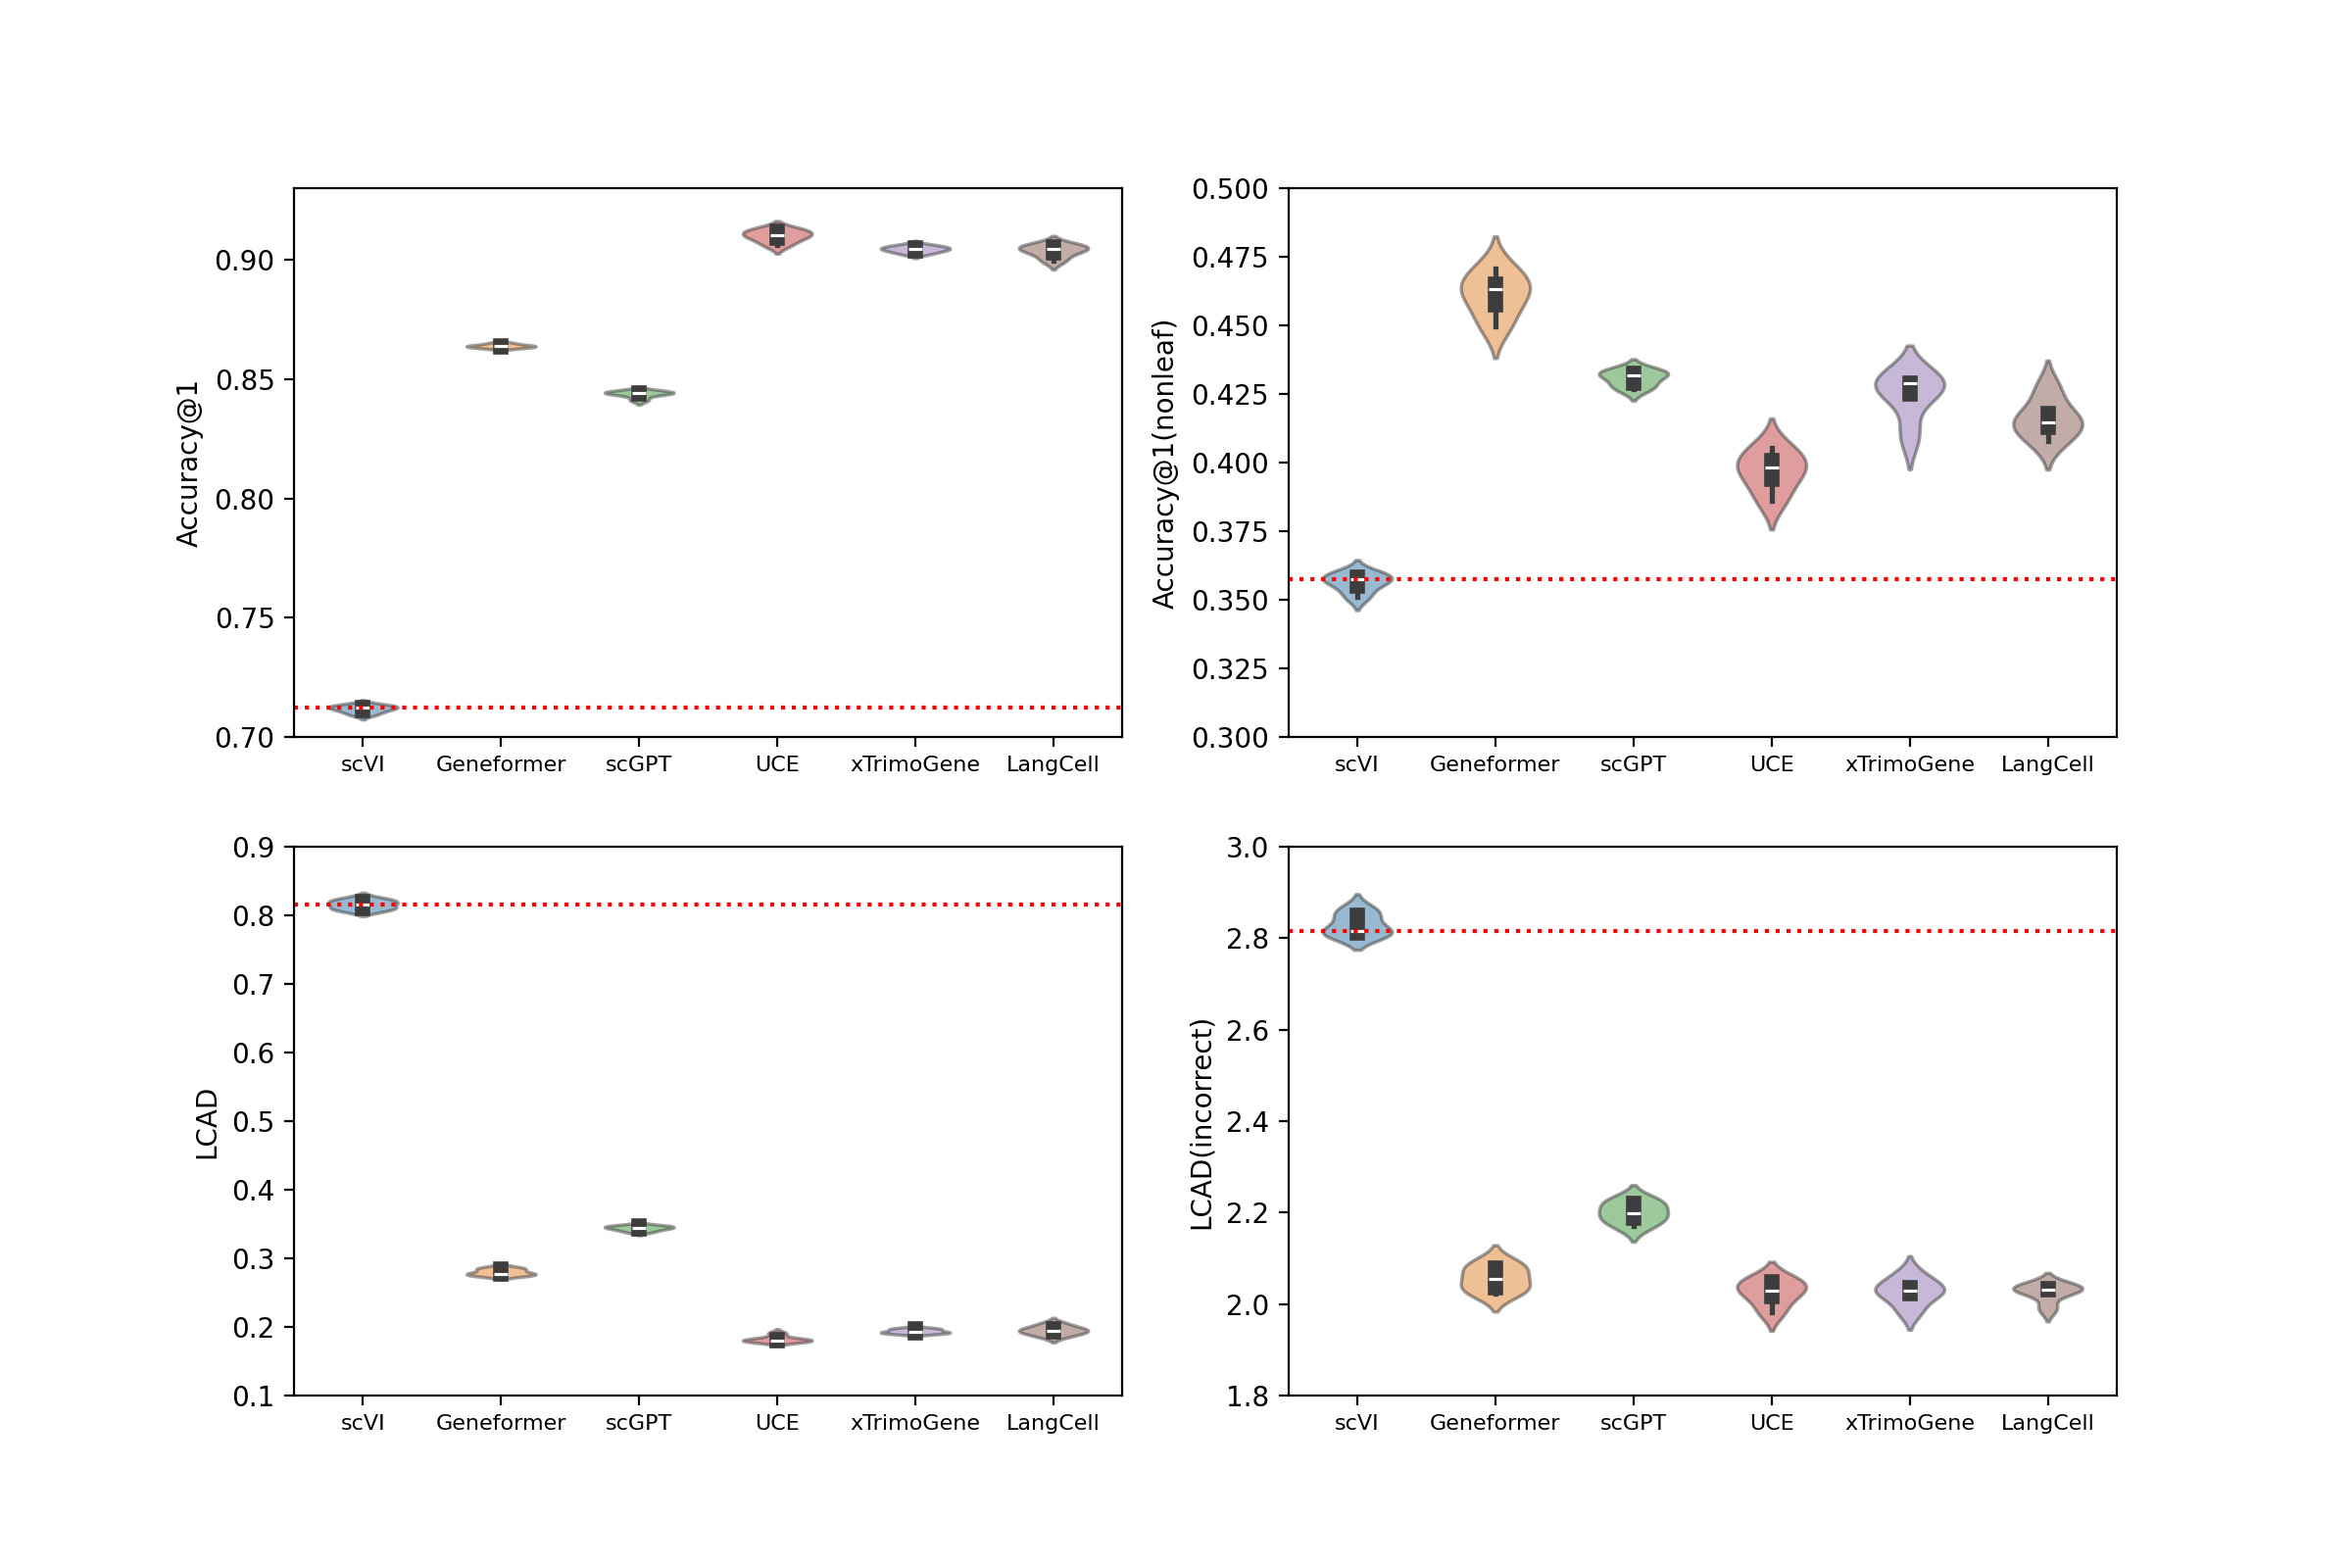

In [33]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
# sns.barplot(x='model', y='Accuracy@1', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0, 0])
sns.violinplot(x='model', y='Accuracy@1', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,0], inner="box")
axes[0,0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1'].median(), color='r', linestyle=':')
axes[0,0].set_xlabel("")
axes[0,0].tick_params(axis='x', labelsize=8)
axes[0,0].set_ylabel('Accuracy@1')
axes[0,0].set_ylim(0.7, 0.93)
# for p in axes[0,0].patches: 
#     height = p.get_height()
#     axes[0,0].text(p.get_x() + p.get_width() / 2., height+0.005,
#             '{:.3f}'.format(height),
#             ha='center', va='bottom', fontsize=8)

# sns.barplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[0,1])
sns.violinplot(x='model', y='Accuracy@1(nonleaf)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[0,1])
axes[0,1].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1(nonleaf)'].median(), color='r', linestyle=':')
axes[0,1].set_xlabel("")
axes[0,1].tick_params(axis='x', labelsize=8)
axes[0,1].set_ylabel('Accuracy@1(nonleaf)')
axes[0,1].set_ylim(0.3, 0.5)

# sns.barplot(x='model', y='LCAD', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,0])
sns.violinplot(x='model', y='LCAD', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,0])
axes[1,0].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD'].median(), color='r', linestyle=':')
axes[1,0].set_xlabel("")
axes[1,0].tick_params(axis='x', labelsize=8)
axes[1,0].set_ylabel('LCAD')
axes[1,0].set_ylim(0.1, 0.9)

# sns.barplot(x='model', y='LCAD(incorrect)', data=df_all, errorbar='sd', alpha=0.5, err_kws={'linewidth': 2}, hue="model", ax=axes[1,1])
sns.violinplot(x='model', y='LCAD(incorrect)', data=df_all, hue="model", width=0.5, alpha=0.5, ax=axes[1,1])
axes[1,1].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD(incorrect)'].median(), color='r', linestyle=':')
axes[1,1].set_xlabel("")
axes[1,1].tick_params(axis='x', labelsize=8)
axes[1,1].set_ylabel('LCAD(incorrect)')
axes[1,1].set_ylim(1.8,3)

plt.savefig("figures/cell_annotation/Tabula_DAG_Yemb.png", dpi=300, bbox_inches="tight")

### unseen_ratio > 0

#### Distribution of argmax probs

In [8]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
pred_df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
        for seed in range(5):
            result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/{seed}/{unseen_ratio}/pred_label.csv")
            df = pd.read_csv(result_path)
            df["model"] = model
            df["unseen_ratio"] = unseen_ratio
            df["seed"] = seed
            pred_df_all = pd.concat([pred_df_all, df])
pred_df_all.head()

y_true      y_pred  y_pred_all      prob  unseen model  unseen_ratio  \
0  CL:0002623  CL:0001044  CL:0001044  0.108354       1  scVI           0.1   
1  CL:0002623  CL:0000646  CL:0000646  0.947648       1  scVI           0.1   
2  CL:0000233  CL:4006000  CL:0000921  0.176319       1  scVI           0.1   
3  CL:0002623  CL:0000897  CL:0000897  0.162686       1  scVI           0.1   
4  CL:0002623  CL:0002341  CL:0002341  0.326142       1  scVI           0.1   

   seed  
0     0  
1     0  
2     0  
3     0  
4     0

In [86]:
#! select the best threshold for each model
unseen_ratio = 0.7
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/0/{unseen_ratio}/pred_label.csv")
    df = pd.read_csv(result_path)
    for threshold in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95]:
        selected_index = list(set(df[df["unseen"]==1].index).union(set(df[df["prob"]<threshold].index)))
        print(len(selected_index)/len(df))
        unseen_acc = accuracy_score(df.iloc[selected_index].unseen, df.iloc[selected_index]["prob"]<threshold)
        print(model, threshold, unseen_acc)

0.8728903781069995
scVI 0.2 0.003517713742834584
0.8734899253647713
scVI 0.3 0.03684649432292001
0.8751204697760944
scVI 0.4 0.11566707858190177
0.8785048299975345
scVI 0.5 0.23064068629014256
0.8842537597776632
scVI 0.6 0.35698398717453156
0.8898850214043974
scVI 0.7 0.46882555913761836
0.8965584866754824
scVI 0.8 0.5736749017230496
0.9063529596342201
scVI 0.9 0.6854687644895058
0.9162370845193536
scVI 0.95 0.7532335691876785
0.8728343456530022
Geneformer 0.2 0.0008217085117446541
0.872923997579398
Geneformer 0.3 0.012074023198043508
0.8731481273953874
Geneformer 0.4 0.04971475142624287
0.8736131967635654
Geneformer 0.5 0.11289701883113551
0.8754286482730798
Geneformer 0.6 0.1966384188023247
0.8772497030279938
Geneformer 0.7 0.2801272347519497
0.8795806531142838
Geneformer 0.8 0.370538359122674
0.8834244794585023
Geneformer 0.9 0.48882109309095984
0.8878622498150929
Geneformer 0.95 0.582714335300243
0.8728343456530022
scGPT 0.2 0.0011234296059008944
0.8728455521438017
scGPT 0.3 0.0144

In [94]:
#! one-sided ttest
for model in pred_df_all.model.unique():
    print(f"===== {model} =====")
    data=pred_df_all[(pred_df_all["unseen_ratio"]==0.9)&((pred_df_all["model"]==model))]
    ttest(data1=data[data["unseen"]==1].prob, data2=data[data["unseen"]==0].prob, side="left")

===== scVI =====
t-statistic: -167.96257635460563
One-sided p-value (left tail): 0.0
===== Geneformer =====
t-statistic: -316.5617973860697
One-sided p-value (left tail): 0.0
===== scGPT =====
t-statistic: -306.953101413055
One-sided p-value (left tail): 0.0
===== UCE =====
t-statistic: -522.1136775126579
One-sided p-value (left tail): 0.0
===== xTrimoGene =====
t-statistic: -494.0890887050588
One-sided p-value (left tail): 0.0
===== LangCell =====
t-statistic: -555.9012435434736
One-sided p-value (left tail): 0.0


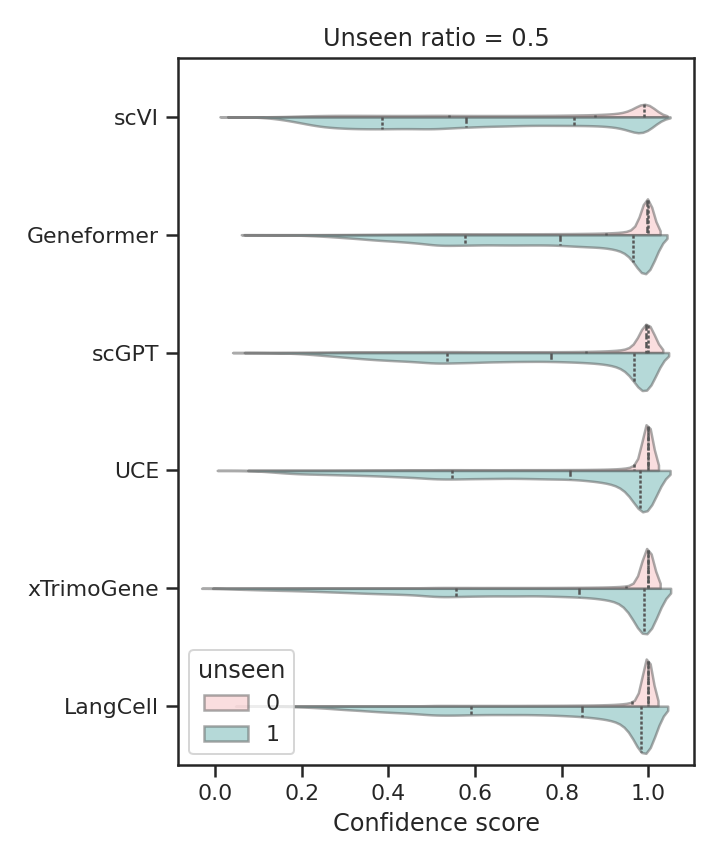

In [99]:
# visualize probs distribution
unseen_ratio = 0.5
plt.figure(figsize=(5,6))
sns.violinplot(data=pred_df_all[pred_df_all["unseen_ratio"]==unseen_ratio], x="prob", y="model", hue="unseen",
               split=True, 
               inner="quart", fill=True,
               palette={0: "#ffb6b9", 1: "#61c0bf"},
               alpha=0.5
               )
plt.xlabel("Confidence score")
plt.ylabel("")
plt.title(f"Unseen ratio = {unseen_ratio}")
plt.tight_layout()

#### Accuracy of seen and unseen classes
scBERT: evaluate the accuracy of novel cell type and known cell types, separately. Notably, we employed a strict evaluation method for novel cell types with the accuracy calculated on the union set of cells with the novel cell type label and the cells that are predicted as novel cell types

In [101]:
result_dir = "/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
        for seed in range(5):
            df = pd.read_csv(os.path.join(result_dir, f"{model}/onclass_dot_product/Tabula_Sapiens_all/lr_0.001_l2_1e-06/{seed}/{unseen_ratio}/metrics_origin_unseen_conf_before_refine.csv"))
            df["Model"] = model
            df["Unseen_ratio"] = unseen_ratio
            df["seed"] = seed
            df_all = pd.concat([df_all, df], axis=0)
df_all.head()

AUROC(seen)  AUPRC(seen)     AUROC     AUPRC  AUROC(unseen)  AUPRC(unseen)  \
0     0.928925     0.922967  0.892256  0.859412       0.595564       0.345196   
0     0.910551     0.906867  0.873354  0.838689       0.603670       0.344404   
0     0.901722     0.902169  0.871515  0.842210       0.650001       0.402505   
0     0.899329     0.895068  0.857929  0.825903       0.561229       0.330225   
0     0.874731     0.875984  0.826500  0.802277       0.476826       0.267906   

   Accuracy@3  Accuracy@5  Accuracy@1 Model  Unseen_ratio  seed  
0    0.667513    0.716649    0.553626  scVI           0.1     0  
0    0.597706    0.628690    0.502865  scVI           0.1     1  
0    0.660231    0.692273    0.548689  scVI           0.1     2  
0    0.570098    0.595249    0.484014  scVI           0.1     3  
0    0.651032    0.674073    0.557801  scVI           0.1     4

In [119]:
result_ls = []
threshold = 0.6
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
        for seed in range(5):
            # df = pred_df_all[(pred_df_all["model"]==model) & (pred_df_all["unseen_ratio"]==unseen_ratio) & (pred_df_all["seed"]==seed)]
            result_file = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/{seed}/{unseen_ratio}/pred_label.csv")
            df = pd.read_csv(result_file)
            seen_acc = accuracy_score(df[df["unseen"]==0].y_true, df[df["unseen"]==0].y_pred)
            selected_index = list(set(df[df["unseen"]==1].index).union(set(df[df["prob"]<threshold].index)))
            unseen_acc = accuracy_score(df.iloc[selected_index].unseen, df.iloc[selected_index]["prob"]<threshold)
            result_ls.append({"Model": model, "Unseen_ratio": unseen_ratio, "Seed": seed, "Accuracy(seen)": seen_acc, "Accuracy(unseen)": unseen_acc})
result_df = pd.DataFrame(result_ls)
result_df.head()

Model  Unseen_ratio  Seed  Accuracy(seen)  Accuracy(unseen)
0  scVI           0.1     0        0.747267          0.355842
1  scVI           0.1     1        0.763976          0.344377
2  scVI           0.1     2        0.758411          0.273814
3  scVI           0.1     3        0.751586          0.316622
4  scVI           0.1     4        0.746409          0.195547

#### Metrics for novel cell type identification

In [9]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_unseen_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    for unseen_ratio in [0.1,0.3,0.5,0.7,0.9]:
        result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/all_metrics_unseen_{unseen_ratio}.csv")
        # result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/softmaxOOD_metrics_unseen_{unseen_ratio}.csv")
        df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
        df["model"] = model
        df["unseen_ratio"] = unseen_ratio
        df_unseen_all = pd.concat([df_unseen_all, df])
df_unseen_all.head()

AUROC(seen)  AUPRC(seen)     AUROC     AUPRC  AUROC(unseen)  AUPRC(unseen)  \
0     0.927424     0.911038  0.882368  0.840867       0.517819       0.273125   
1     0.874368     0.862633  0.836639  0.796421       0.563111       0.316389   
2     0.948619     0.929124  0.904910  0.856546       0.584376       0.324305   
3     0.901402     0.883453  0.851689  0.809488       0.495417       0.279405   
4     0.904709     0.890386  0.850523  0.813877       0.457672       0.259189   

   Accuracy@3  Accuracy@5  Accuracy@1  AUROC(OOD)_with_refine  \
0    0.584261    0.619469    0.468252                0.297295   
1    0.543106    0.573872    0.438352                0.425334   
2    0.583369    0.614806    0.470206                0.335049   
3    0.505410    0.536120    0.409605                0.407642   
4    0.617489    0.651351    0.502039                0.487829   

   AUPRC(OOD)_with_refine  AUROC(OOD)_wo_refine  AUPRC(OOD)_wo_refine model  \
0                0.166736              0.765127              0.460745  scVI   
1                0.288440              0.711251              0.476128  scVI   
2                0.184462              0.669726              0.365312  scVI   
3                0.272793              0.667236              0.440002  scVI   
4                0.211295              0.600050              0.254657  scVI   

   unseen_ratio  
0           0.1  
1           0.1  
2           0.1  
3           0.1  
4           0.1

In [6]:
df_grouped = df_unseen_all.groupby(['model', 'unseen_ratio'])['Accuracy@1'].agg(['mean', 'std']).reset_index()
model_mean = df_grouped.pivot(index='unseen_ratio', columns='model', values='mean')
model_std = df_grouped.pivot(index='unseen_ratio', columns='model', values='std')
model_mean

model         Geneformer  LangCell       UCE     scGPT      scVI  xTrimoGene
unseen_ratio                                                                
0.1             0.558812  0.579147  0.576126  0.542182  0.457993    0.562976
0.3             0.209383  0.220871  0.215457  0.205055  0.150827    0.204453
0.5             0.072196  0.068137  0.063609  0.061305  0.058376    0.059911
0.7             0.026540  0.023153  0.020900  0.027449  0.023982    0.024414
0.9             0.008315  0.006994  0.012755  0.009395  0.007272    0.009137

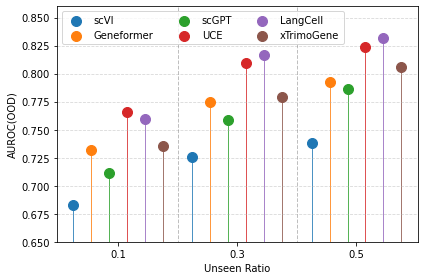

In [21]:
df_grouped = df_unseen_all.groupby(['model', 'unseen_ratio'])['AUROC(OOD)_wo_refine'].agg(['mean', 'std']).reset_index()
model_mean = df_grouped.pivot(index='unseen_ratio', columns='model', values='mean')
model_std = df_grouped.pivot(index='unseen_ratio', columns='model', values='std')
model_mean = model_mean.reset_index().melt(id_vars=['unseen_ratio'])
desired_order = ['scVI', 'Geneformer', 'scGPT', 'UCE', 'LangCell', 'xTrimoGene']  
model_mean['model'] = pd.Categorical(model_mean['model'], categories=desired_order, ordered=True)
model_mean = model_mean.sort_values('model')

df = model_mean[model_mean["unseen_ratio"]<0.7]
x = np.arange(len(df["unseen_ratio"].unique()))
width = 0.15  # Width of the bar (used as offset)

plt.vlines(0.5, ymin=0, ymax=1, linewidth=1, color="gray", alpha=0.5, ls="--")
plt.vlines(1.5, ymin=0, ymax=1, linewidth=1, color="gray", alpha=0.5, ls="--")
plt.grid(axis="y", ls="--", alpha=0.5, zorder=0)

# Plot each dataset
for i, model_name in enumerate(df["model"].unique()):
    color = f"C{i}"  
    x_pos = x + i * width - 2.5 * width  # Adjust x position for each dataset
    y = df[df["model"]==model_name].sort_values("unseen_ratio").value.tolist()
    
    # Plot vertical lines
    plt.vlines(x_pos, ymin=0, ymax=y, linewidth=1, color=color, alpha=0.8, zorder=1)
    
    # Plot dots at the end of the lines
    plt.scatter(x_pos, y, s=100, color=color, alpha=1, label=model_name, zorder=2)  # s controls the size of the dots
    
# sns.despine(top=True, right=True, left=False, bottom=False)
plt.ylim(0.65,0.86)
plt.xticks(x, sorted(df["unseen_ratio"].unique()))
plt.xlabel('Unseen Ratio')
plt.ylabel('AUROC(OOD)') 
plt.legend(ncol=3, loc="upper left")
plt.tight_layout()
plt.savefig("./figures/cell_annotation/unseen_auroc_out.png", dpi=300)

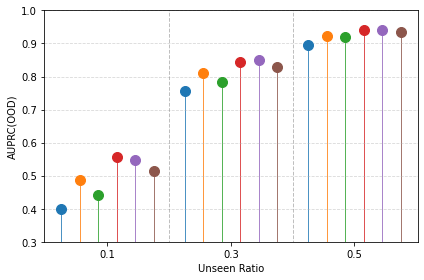

In [22]:
df_grouped = df_unseen_all.groupby(['model', 'unseen_ratio'])['AUPRC(OOD)_wo_refine'].agg(['mean', 'std']).reset_index()
model_mean = df_grouped.pivot(index='unseen_ratio', columns='model', values='mean')
model_std = df_grouped.pivot(index='unseen_ratio', columns='model', values='std')
model_mean = model_mean.reset_index().melt(id_vars=['unseen_ratio'])
desired_order = ['scVI', 'Geneformer', 'scGPT', 'UCE', 'LangCell', 'xTrimoGene']  
model_mean['model'] = pd.Categorical(model_mean['model'], categories=desired_order, ordered=True)
model_mean = model_mean.sort_values('model')

df = model_mean[model_mean["unseen_ratio"]<0.7]
x = np.arange(len(df["unseen_ratio"].unique()))
width = 0.15  # Width of the bar (used as offset)

plt.vlines(0.5, ymin=0, ymax=1, linewidth=1, color="gray", alpha=0.5, ls="--")
plt.vlines(1.5, ymin=0, ymax=1, linewidth=1, color="gray", alpha=0.5, ls="--")
plt.grid(axis="y", ls="--", alpha=0.5, zorder=0)

# Plot each dataset
for i, model_name in enumerate(df["model"].unique()):
    color = f"C{i}"  
    x_pos = x + i * width - 2.5 * width  # Adjust x position for each dataset
    y = df[df["model"]==model_name].sort_values("unseen_ratio").value.tolist()
    
    # Plot vertical lines
    plt.vlines(x_pos, ymin=0, ymax=y, linewidth=1, color=color, alpha=0.8, zorder=1)
    
    # Plot dots at the end of the lines
    plt.scatter(x_pos, y, s=100, color=color, alpha=1, label=model_name, zorder=2)  # s controls the size of the dots
    
# sns.despine(top=True, right=True, left=False, bottom=False)
plt.ylim(0.3,1)
plt.xticks(x, sorted(df["unseen_ratio"].unique()))
plt.xlabel('Unseen Ratio')
plt.ylabel('AUPRC(OOD)') 
plt.tight_layout()
# plt.legend(ncol=3, loc="upper left")
plt.savefig("./figures/cell_annotation/unseen_auprc_out.png", dpi=300)

In [7]:
def plot_auroc(y_true, y_pred_ls, unseen_label, unseen_pred_ls, model_ls):
    optimal_threshold_dict = {}
    # 绘制 ROC 曲线
    plt.figure(figsize=(8, 6))
    for unseen_pred, y_pred, model in zip(unseen_pred_ls, y_pred_ls, model_ls):
        # 计算 ROC 曲线
        fpr, tpr, thresholds = roc_curve(unseen_label, unseen_pred)

        # 计算 AUC
        roc_auc = auc(fpr, tpr)

        # 计算 Youden's J statistic
        J = tpr - fpr
        optimal_idx = np.argmax(J)
        optimal_threshold = thresholds[optimal_idx]
        print(f"========== {model} ==========")
        print(f"Optimal threshold:", optimal_threshold)
        optimal_threshold_dict[model] = optimal_threshold
        
        # calculate the binary classifictaion metrics using the optimal threshold
        # unseen_acc = accuracy_score(unseen_label, unseen_pred>optimal_threshold)
        # print("unseen_acc:", unseen_acc)

        # seen_acc_v1 = accuracy_score(y_true[unseen_label==0], y_pred[unseen_label==0])
        # seen_acc_v2 = accuracy_score(y_true[unseen_pred<=optimal_threshold], y_pred[unseen_pred<=optimal_threshold])
        # print("seen_acc(unseen=0):", seen_acc_v1)
        # print("seen_acc(pred_unseen=0):", seen_acc_v2)

        plt.plot(fpr, tpr, lw=2, label='{} (AUC = {:.2f})'.format(model, roc_auc))

    plt.plot([0, 1], [0, 1], color='red', linestyle='--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    return optimal_threshold_dict

========== scVI ==========
Optimal threshold: 0.10588140000000001
========== Geneformer ==========
Optimal threshold: 0.013735350000000035
========== scGPT ==========
Optimal threshold: 0.007738899999999993
========== UCE ==========
Optimal threshold: 0.004406869999999952
========== xTrimoGene ==========
Optimal threshold: 0.005380150000000028
========== LangCell ==========
Optimal threshold: 0.0039804599999999635


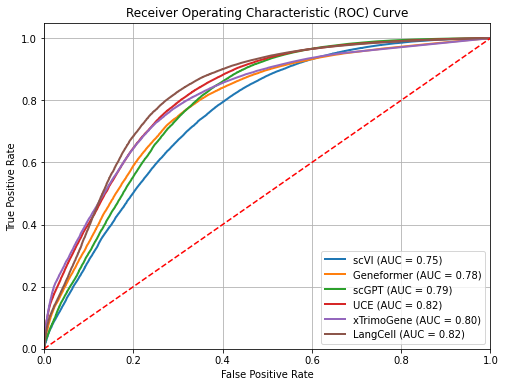

{'scVI': 0.10588140000000001,
 'Geneformer': 0.013735350000000035,
 'scGPT': 0.007738899999999993,
 'UCE': 0.004406869999999952,
 'xTrimoGene': 0.005380150000000028,
 'LangCell': 0.0039804599999999635}

In [8]:
# plot the AUROC/AUPRC curve
model_ls = ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
for unseen_ratio in [0.5]:
    y_pred_ls = []
    unseen_confidence_ls = []
    for model in model_ls:
        result_file = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/0/{unseen_ratio}/pred_label.csv")
        df = pd.read_csv(result_file)
        unseen_label = df["unseen"]
        y_true = df["y_true"]
        unseen_confidence_ls.append(1-df["prob"])
        y_pred_ls.append(df["y_pred"])
    optimal_threshold_dict = plot_auroc(y_true, y_pred_ls, unseen_label, unseen_confidence_ls, model_ls)
optimal_threshold_dict

In [32]:
model_ls = ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
result_ls = []
for unseen_ratio in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y_pred_ls = []
    unseen_confidence_ls = []
    for model in model_ls:
        for iter in range(5):
            result_file = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/{iter}/{unseen_ratio}/pred_label.csv")
            df = pd.read_csv(result_file)
            unseen_label = df["unseen"]
            y_true = df["y_true"]
            unseen_pred = 1-df["prob"]
            y_pred = df["y_pred"]

            result = {
                "model": model,
                "unseen_ratio": unseen_ratio,
                "iter": iter,
            }

            for FPR in [0.05, 0.1, 0.2]:
                cut_off_ratio, number_unkonw = get_FPR(df[df["unseen"]==1].prob, FPR=FPR)
                acc_unknown = accuracy_for_unkonw(y_pred, df["prob"], y_true, number_unkonw, cut_off_ratio=cut_off_ratio)
                result.update({f"Accuracy(FPR={FPR})": acc_unknown})

            result_ls.append(result)
result_df = pd.DataFrame(result_ls)
result_df

model  unseen_ratio  iter  Accuracy(FPR=0.05)  Accuracy(FPR=0.1)  \
0        scVI           0.1     0            0.385248           0.473301   
1        scVI           0.1     1            0.318628           0.413939   
2        scVI           0.1     2            0.214697           0.312651   
3        scVI           0.1     3            0.225171           0.336907   
4        scVI           0.1     4            0.155508           0.249563   
..        ...           ...   ...                 ...                ...   
145  LangCell           0.9     0            0.827434           0.904212   
146  LangCell           0.9     1            0.636160           0.787097   
147  LangCell           0.9     2            0.801795           0.904359   
148  LangCell           0.9     3            0.883852           0.950012   
149  LangCell           0.9     4            0.519233           0.601944   

     Accuracy(FPR=0.2)  
0             0.564340  
1             0.518897  
2             0.441589  
3             0.473565  
4             0.387521  
..                 ...  
145           0.955467  
146           0.903078  
147           0.972308  
148           0.985298  
149           0.717486  

[150 rows x 6 columns]

In [33]:
result_df.to_csv("./figures/tabula_accuracy_unseen.csv",index=False)

/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


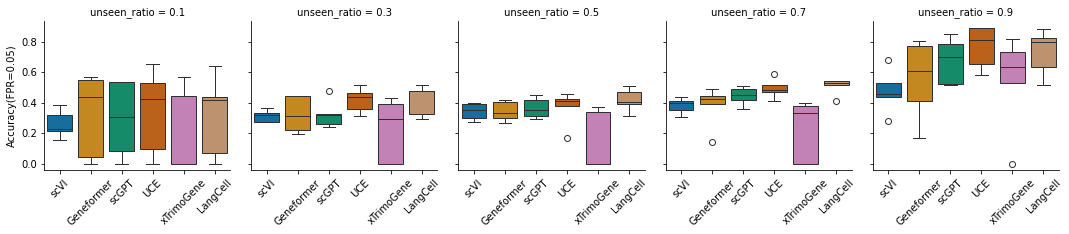

In [34]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.05)", data=result_df, hue="model", palette="colorblind")
# grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('', "Accuracy(FPR=0.05)")
grid.set_xticklabels(rotation=45)
# plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/cell_annotation/novel_cells/unseen_acc.png", dpi=300, bbox_inches='tight')

/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


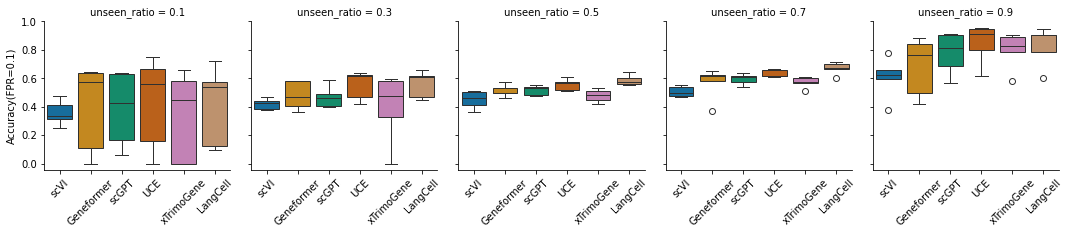

In [35]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.1)", data=result_df, hue="model", palette="colorblind")
# grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('', "Accuracy(FPR=0.1)")
grid.set_xticklabels(rotation=45)
# plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/cell_annotation/novel_cells/unseen_acc.png", dpi=300, bbox_inches='tight')

/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


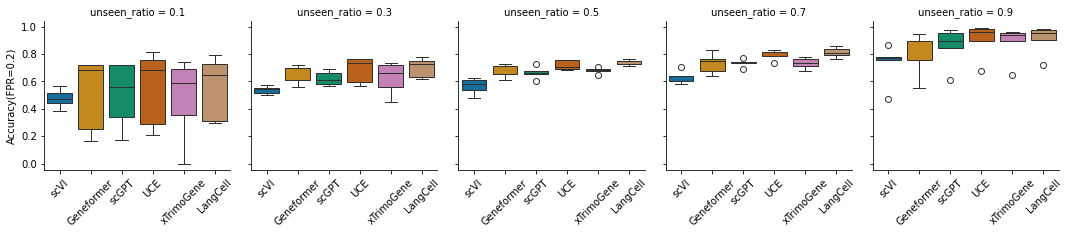

In [36]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(FPR=0.2)", data=result_df, hue="model", palette="colorblind")
# grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('', "Accuracy(FPR=0.2)")
grid.set_xticklabels(rotation=45)
# plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/cell_annotation/novel_cells/unseen_acc.png", dpi=300, bbox_inches='tight')

In [9]:
# plot the AUROC/AUPRC curve
model_ls = ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
result_ls = []
for unseen_ratio in [0.1, 0.3, 0.5, 0.7, 0.9]:
    y_pred_ls = []
    unseen_confidence_ls = []
    for model in model_ls:
        for iter in range(5):
            result_file = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06/{iter}/{unseen_ratio}/pred_label.csv")
            df = pd.read_csv(result_file)
            unseen_label = df["unseen"]
            y_true = df["y_true"]
            unseen_pred = 1-df["prob"]
            y_pred = df["y_pred"]

            unseen_acc = accuracy_score(unseen_label, unseen_pred>optimal_threshold_dict[model])
            # print("unseen_acc:", unseen_acc)

            seen_acc_v1 = accuracy_score(y_true[unseen_label==0], y_pred[unseen_label==0])
            seen_acc_v2 = accuracy_score(y_true[unseen_pred<=optimal_threshold_dict[model]], y_pred[unseen_pred<=optimal_threshold_dict[model]])
            # print("seen_acc(unseen=0):", seen_acc_v1)
            # print("seen_acc(pred_unseen=0):", seen_acc_v2)

            result_ls.append({
                "model": model,
                "unseen_ratio": unseen_ratio,
                "iter": iter,
                "Accuracy(seen v.s. unseen)": unseen_acc,
                "Accuracy(seen)": seen_acc_v1,
                "Accuracy(pred as seen)": seen_acc_v2,
            })
result_df = pd.DataFrame(result_ls)
result_df

model  unseen_ratio  iter  Accuracy(seen v.s. unseen)  Accuracy(seen)  \
0        scVI           0.1     0                    0.569825        0.746535   
1        scVI           0.1     1                    0.610819        0.761203   
2        scVI           0.1     2                    0.558092        0.757061   
3        scVI           0.1     3                    0.595520        0.751688   
4        scVI           0.1     4                    0.527759        0.748433   
..        ...           ...   ...                         ...             ...   
145  LangCell           0.9     0                    0.848201        0.995064   
146  LangCell           0.9     1                    0.778641        0.995210   
147  LangCell           0.9     2                    0.760801        1.000000   
148  LangCell           0.9     3                    0.857627        0.999265   
149  LangCell           0.9     4                    0.777061        0.964915   

     Accuracy(pred as seen)  
0                  0.916233  
1                  0.837931  
2                  0.831833  
3                  0.799836  
4                  0.831474  
..                      ...  
145                0.205712  
146                0.152829  
147                0.059401  
148                0.099677  
149                0.091446  

[150 rows x 6 columns]

/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


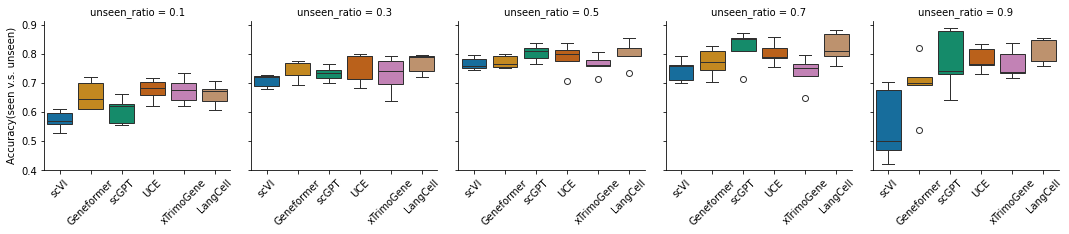

In [45]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(seen v.s. unseen)", data=result_df, hue="model", palette="colorblind")
# grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('', "Accuracy(seen v.s. unseen)")
grid.set_xticklabels(rotation=45)
plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/cell_annotation/novel_cells/unseen_acc.png", dpi=300, bbox_inches='tight')

/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


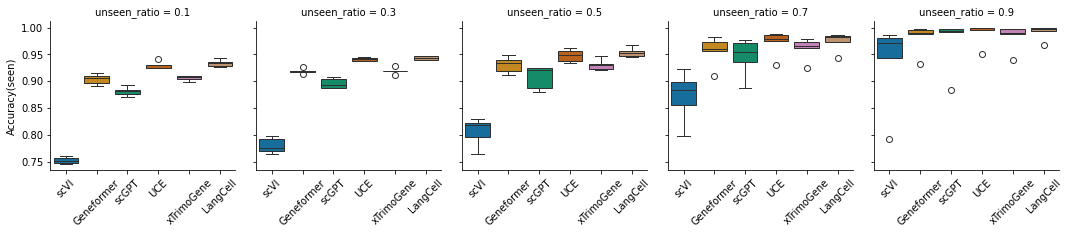

In [46]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(seen)", data=result_df, hue="model", palette="colorblind")
# grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('', "Accuracy(seen)")
grid.set_xticklabels(rotation=45)
plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/cell_annotation/novel_cells/seen_acc.png", dpi=300, bbox_inches='tight')

/data2/zhuyiheng/.conda/envs/singlecell/lib/python3.8/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.


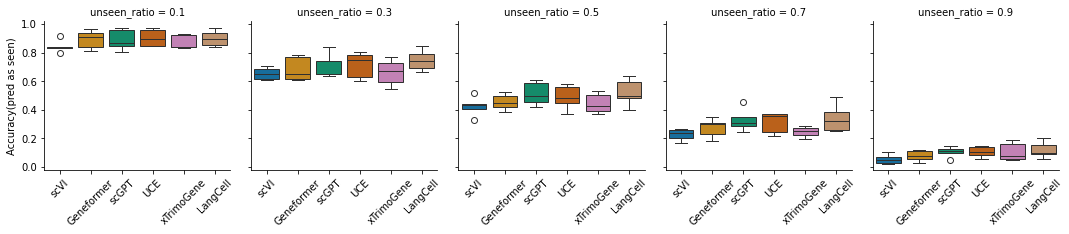

In [47]:
grid = sns.FacetGrid(result_df, col="unseen_ratio")
grid.map(sns.boxplot, "model", "Accuracy(pred as seen)", data=result_df, hue="model", palette="colorblind")
# grid.set_titles(row_template='{row_name}', col_template='{col_name}')
grid.set_axis_labels('', "Accuracy(pred as seen)")
grid.set_xticklabels(rotation=45)
plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/cell_annotation/novel_cells/pred_seen_acc.png", dpi=300, bbox_inches='tight')

##### plot version 2

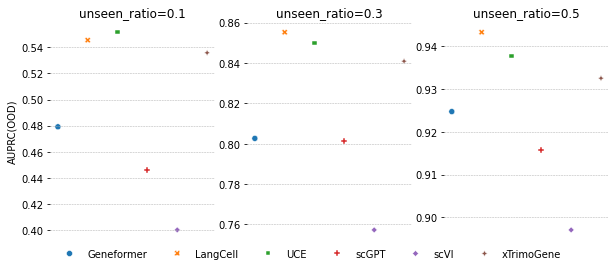

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=False)
df_grouped = model_mean.groupby("unseen_ratio")
for i, unseen_r in enumerate([0.1, 0.3, 0.5]):
    df_model = df_grouped.get_group(unseen_r)
    if i > 0:
        sns.scatterplot(data=df_model, x="model", y="value", hue="model", style="model", ax=axes[i], legend=False)
        axes[i].set_ylabel("")
    else:
        sns.scatterplot(data=df_model, x="model", y="value", hue="model", style="model", ax=axes[i], legend=True)
        # sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1), title=None, frameon=False, fontsize=6) # title_fontsize
        axes[i].legend(loc='upper left', bbox_to_anchor=(0, 0), ncol=6, title=None, frameon=False, fontsize=10)
        axes[i].set_ylabel("AUPRC(OOD)")
    
    # mean_value = df_model["Pearson-PCA"].mean()
    # axes[i].axhline(y=mean_value, color='purple', linestyle='--')
    # axes[i].text(1, mean_value+0.01, f'{mean_value:.3f}', color='purple', fontsize=8) 
    
    # axes[i].set_xticklabels([])
    # axes[i].set_xlabel("")
    axes[i].xaxis.set_visible(False)
    axes[i].set_title(f"unseen_ratio={unseen_r}")
    # 删除子图边框
    for spine in ['top', 'right', 'bottom', 'left']:
        axes[i].spines[spine].set_visible(False)

    # 添加网格线
    axes[i].grid(True, which='major', linestyle='--', linewidth=0.5, axis="y")

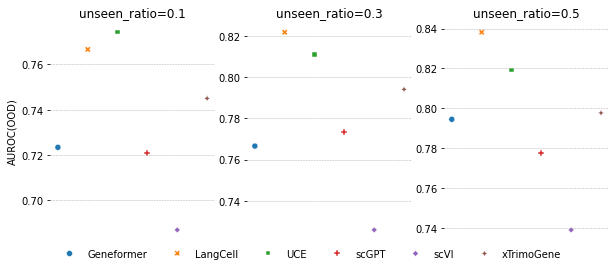

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharex=True, sharey=False)
df_grouped = model_mean.groupby("unseen_ratio")
for i, unseen_r in enumerate([0.1, 0.3, 0.5]):
    df_model = df_grouped.get_group(unseen_r)
    if i > 0:
        sns.scatterplot(data=df_model, x="model", y="value", hue="model", style="model", ax=axes[i], legend=False)
        axes[i].set_ylabel("")
    else:
        sns.scatterplot(data=df_model, x="model", y="value", hue="model", style="model", ax=axes[i], legend=True)
        # sns.move_legend(axes[i], "upper left", bbox_to_anchor=(1, 1), title=None, frameon=False, fontsize=6) # title_fontsize
        axes[i].legend(loc='upper left', bbox_to_anchor=(0, 0), ncol=6, title=None, frameon=False, fontsize=10)
        axes[i].set_ylabel("AUROC(OOD)")
    
    # mean_value = df_model["Pearson-PCA"].mean()
    # axes[i].axhline(y=mean_value, color='purple', linestyle='--')
    # axes[i].text(1, mean_value+0.01, f'{mean_value:.3f}', color='purple', fontsize=8) 
    
    # axes[i].set_xticklabels([])
    # axes[i].set_xlabel("")
    axes[i].xaxis.set_visible(False)
    axes[i].set_title(f"unseen_ratio={unseen_r}")
    # 删除子图边框
    for spine in ['top', 'right', 'bottom', 'left']:
        axes[i].spines[spine].set_visible(False)

    # 添加网格线
    axes[i].grid(True, which='major', linestyle='--', linewidth=0.5, axis="y")

## Cross dataset label transfer

In [91]:
source_dataset = "Tabula_Sapiens_all"
target_dataset = "HLCA_core"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "onclass_dot_product", 
                               source_dataset, f"lr_0.001_l2_1e-06/metrics_{target_dataset}.csv")
    df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
    df["model"] = model
    df_all = pd.concat([df_all, df])
df_all

unseen_ratio  Accuracy@1(nonleaf)      LCAD  LCAD(incorrect)       model
iter                                                                          
0.0            0.0             0.434018  1.946380         3.438943        scVI
1.0            0.0             0.445272  1.926105         3.472158        scVI
2.0            0.0             0.422931  1.954710         3.387306        scVI
3.0            0.0             0.444184  1.928576         3.469812        scVI
4.0            0.0             0.440147  1.902817         3.398779        scVI
0.0            0.0             0.668956  0.894289         2.701421  Geneformer
1.0            0.0             0.673123  0.950017         2.906346  Geneformer
2.0            0.0             0.663373  0.907687         2.696419  Geneformer
3.0            0.0             0.679039  0.927473         2.889674  Geneformer
4.0            0.0             0.662640  0.961962         2.851439  Geneformer
0.0            0.0             0.658488  0.809447         2.370186       scGPT
1.0            0.0             0.642333  0.890954         2.491018       scGPT
2.0            0.0             0.635221  0.909955         2.494537       scGPT
3.0            0.0             0.638369  0.867178         2.397960       scGPT
4.0            0.0             0.644326  0.849696         2.388973       scGPT
0.0            0.0             0.646558  0.847709         2.398437         UCE
1.0            0.0             0.640887  0.839930         2.338902         UCE
2.0            0.0             0.658753  0.789682         2.314108         UCE
3.0            0.0             0.661844  0.761405         2.251635         UCE
4.0            0.0             0.660293  0.811632         2.389215         UCE
0.0            0.0             0.650965  0.774261         2.218287  xTrimoGene
1.0            0.0             0.658634  0.783157         2.294184  xTrimoGene
2.0            0.0             0.658014  0.777856         2.274528  xTrimoGene
3.0            0.0             0.648556  0.803781         2.287080  xTrimoGene
4.0            0.0             0.658025  0.778579         2.276712  xTrimoGene
0.0            0.0             0.659013  0.935979         2.744915    LangCell
1.0            0.0             0.660507  0.966020         2.845476    LangCell
2.0            0.0             0.631834  1.018709         2.766983    LangCell
3.0            0.0             0.660470  0.925662         2.726306    LangCell
4.0            0.0             0.637578  0.975937         2.692818    LangCell

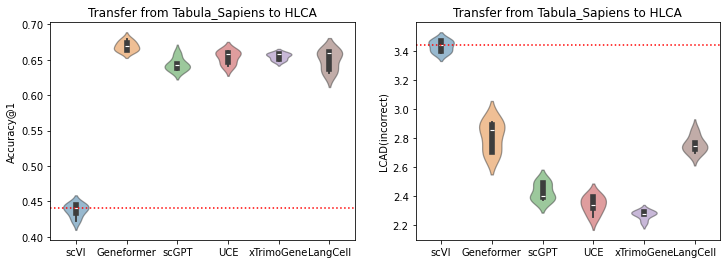

In [93]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.violinplot(df_all, x='model', y='Accuracy@1(nonleaf)', hue="model", width=0.5, alpha=0.5, ax=axes[0])
axes[0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1(nonleaf)'].median(), color='r', linestyle=':')
axes[0].set_xlabel("")
axes[0].set_ylabel("Accuracy@1")
axes[0].set_title("Transfer from Tabula_Sapiens to HLCA")

sns.violinplot(df_all, x='model', y='LCAD(incorrect)', hue="model", width=0.5, alpha=0.5, ax=axes[1])
axes[1].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD(incorrect)'].median(), color='r', linestyle=':')
axes[1].set_xlabel("")
axes[1].set_ylabel("LCAD(incorrect)")
axes[1].set_title("Transfer from Tabula_Sapiens to HLCA")

plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/cell_annotation/tabula_to_hlca.png", dpi=300)

In [94]:
source_dataset = "HLCA_core"
target_dataset = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    result_path = os.path.join(output_folder, model, "onclass_dot_product", 
                                source_dataset, f"lr_0.001_l2_1e-06/metrics_{target_dataset}.csv")
    df = pd.read_csv(result_path, index_col=0).iloc[:-2, :]
    df["model"] = model
    df_all = pd.concat([df_all, df])
df_all

unseen_ratio  Accuracy@1(nonleaf)      LCAD  LCAD(incorrect)       model
iter                                                                          
0.0            0.0             0.758452  0.526021         2.177711        scVI
1.0            0.0             0.768205  0.498970         2.152641        scVI
2.0            0.0             0.755588  0.533884         2.184360        scVI
3.0            0.0             0.768224  0.510895         2.204265        scVI
4.0            0.0             0.753173  0.519226         2.103603        scVI
0.0            0.0             0.779045  0.513179         2.322545  Geneformer
1.0            0.0             0.767438  0.531712         2.286324  Geneformer
2.0            0.0             0.774046  0.546894         2.420381  Geneformer
3.0            0.0             0.759238  0.578438         2.402535  Geneformer
4.0            0.0             0.774252  0.515388         2.283025  Geneformer
0.0            0.0             0.648733  0.752499         2.142240       scGPT
1.0            0.0             0.641638  0.733273         2.046179       scGPT
2.0            0.0             0.645550  0.729286         2.057516       scGPT
3.0            0.0             0.641563  0.718073         2.003343       scGPT
4.0            0.0             0.617526  0.813958         2.128139       scGPT
0.0            0.0             0.807087  0.442154         2.291994         UCE
1.0            0.0             0.817346  0.405837         2.221892         UCE
2.0            0.0             0.811019  0.420252         2.223774         UCE
3.0            0.0             0.797278  0.452170         2.230492         UCE
4.0            0.0             0.808229  0.407222         2.123487         UCE
0.0            0.0             0.768224  0.533472         2.301672  xTrimoGene
1.0            0.0             0.772998  0.516174         2.273874  xTrimoGene
2.0            0.0             0.762159  0.567150         2.384573  xTrimoGene
3.0            0.0             0.761784  0.524992         2.203851  xTrimoGene
4.0            0.0             0.768355  0.505785         2.183449  xTrimoGene
0.0            0.0             0.787375  0.482908         2.271175    LangCell
1.0            0.0             0.772155  0.513441         2.253471    LangCell
2.0            0.0             0.781572  0.472388         2.162667    LangCell
3.0            0.0             0.783126  0.478228         2.205093    LangCell
4.0            0.0             0.782058  0.478715         2.196530    LangCell

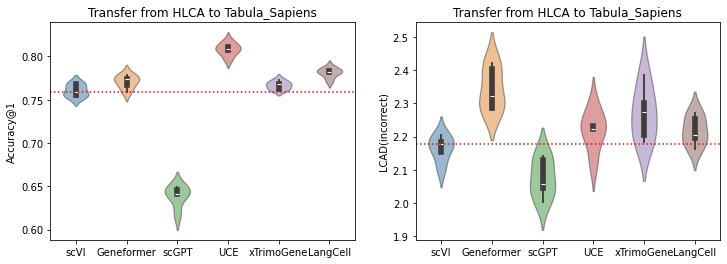

In [95]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.violinplot(df_all, x='model', y='Accuracy@1(nonleaf)', hue="model", width=0.5, alpha=0.5, ax=axes[0])
axes[0].axhline(y=df_all[df_all["model"]=="scVI"]['Accuracy@1(nonleaf)'].median(), color='r', linestyle=':')
axes[0].set_xlabel("")
axes[0].set_ylabel("Accuracy@1")
axes[0].set_title("Transfer from HLCA to Tabula_Sapiens")

sns.violinplot(df_all, x='model', y='LCAD(incorrect)', hue="model", width=0.5, alpha=0.5, ax=axes[1])
axes[1].axhline(y=df_all[df_all["model"]=="scVI"]['LCAD(incorrect)'].median(), color='r', linestyle=':')
axes[1].set_xlabel("")
axes[1].set_ylabel("LCAD(incorrect)")
axes[1].set_title("Transfer from HLCA to Tabula_Sapiens")

plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/cell_annotation/hlca_to_tabula.png", dpi=300)

### Tissue-specific performance

In [ ]:
target_labels = {'CL:0000860', 'CL:0002543', 'CL:0000875', 'CL:0000077', 'CL:0002062', 'CL:0000786', 'CL:0000186', 
                'CL:0002138', 'CL:0002063', 'CL:0000097', 'CL:0000158', 'CL:0002399', 'CL:0002144', 'CL:0000037'}
# read adata
adata = sc.read("/data2/zhuyiheng/wjl/scFoundation/data/datasets/Tabula_Sapiens_all.h5ad")

# select the subset with the target labels
adata_selected = adata[adata.obs["cell_type_ontology_term_id"].isin(target_labels)]

# report the tissue-specific accuracy
tissue = adata_selected.obs["tissue_in_publication"].to_list()

In [ ]:
value_counts = adata_selected.obs["tissue_in_publication"].value_counts().reset_index()
fig = px.pie(
    value_counts,
    names="tissue_in_publication",
    values="count"
)

In [47]:
fig.show()

In [3]:
source_dataset = "HLCA_core"
target_dataset = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
df_all = pd.DataFrame()
for model in ["scVI", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    df_model = pd.DataFrame()
    for iter in range(5):
        result_path = os.path.join(output_folder, model, "onclass_dot_product", 
                                    source_dataset, f"lr_0.001_l2_1e-06/{iter}/0/{target_dataset}/pred_label_nonleaf.csv")
        df = pd.read_csv(result_path)
        df["tissue"] = tissue
        df["iter"] = iter
        df_model = pd.concat([df_model, df], axis=0)
    accuracy_per_tissue = df_model.groupby(['tissue', 'iter']).apply(lambda x: (x['y_true'] == x['y_pred']).mean())
    accuracy_per_tissue = accuracy_per_tissue.groupby(['tissue']).agg("mean").reset_index().rename(columns={0: 'Accuracy'})
    accuracy_per_tissue["model"] = model
    df_all = pd.concat([df_all, accuracy_per_tissue], axis=0)
df_all

tissue  Accuracy     model
0       Bladder  0.556382      scVI
1         Blood  0.874759      scVI
2   Bone_Marrow  0.749653      scVI
3           Eye  0.937255      scVI
4           Fat  0.026680      scVI
..          ...       ...       ...
17       Thymus  0.792586  LangCell
18       Tongue  0.723989  LangCell
19      Trachea  0.971014  LangCell
20       Uterus  0.313953  LangCell
21  Vasculature  0.982199  LangCell

[132 rows x 3 columns]

In [64]:
df_all = df_all.reset_index(drop=True)
df_max_acc = df_all.loc[df_all.groupby('tissue')['Accuracy'].idxmax()].reset_index(drop=True)
df_max_acc.model.value_counts()

model
UCE           14
scGPT          3
LangCell       2
Geneformer     2
scVI           1
Name: count, dtype: int64

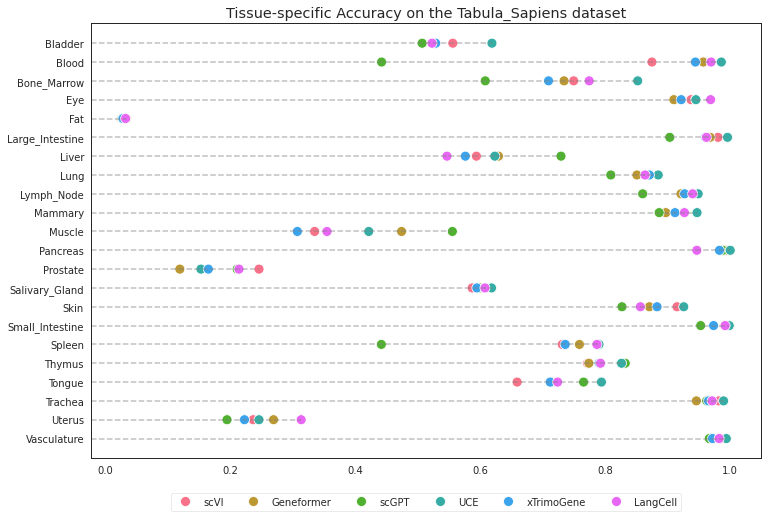

In [27]:
sns.set_style('white')
plt.figure(figsize=(12,8))
pal = sns.color_palette("husl", 6)  
scatter = sns.scatterplot(df_all, y="tissue", x="Accuracy", hue="model", s=100, palette=pal)
yticklabels = scatter.get_yticklabels()
max_values = df_all.groupby('tissue')['Accuracy'].max()
xlim = scatter.get_xlim()
ax = plt.gca()
for i, label in enumerate(scatter.get_yticklabels()):
    dataset = label.get_text()
    ax.axhline(y=i, xmin=0, xmax=(max_values[dataset] - xlim[0])/(xlim[1] - xlim[0]), color='gray', linestyle='--', alpha=0.5)
    # print(dataset, max_values[dataset])

# plt.xticks(rotation=90)
plt.xlabel("")
plt.ylabel("")
plt.legend(ncol=6, loc="center", bbox_to_anchor=(.5,-0.1))
plt.title("Tissue-specific Accuracy on the Tabula_Sapiens dataset")
plt.savefig("/data2/zhuyiheng/wjl/scFoundation/figures/cell_annotation/hlca_to_tabula_tissue_acc.png", dpi=300)

### TODO: Identify novel cell types

In [ ]:
# source dataset: Tabula
# target dataset: HLC1A
# number of overlapped cell types: 14
# number of novel cell types: 37-14 --> 还需要考虑会不会存在parent-child node的关系

## Model complementarity 

1. Dataset: Tabula_Sapiens_all
2. Setting: 20% training, 80% test, unseen_ratio=0
3. Plot: Heatmaps representing performance of pairwise model combinations in terms of Accuracy@1 or Macro F1

In [7]:
combinations = pd.read_csv("./figures/model_complement_tabula.csv")
combinations.head()

iter      model1      model2  Accuracy@1  Macro F1
0     0  Geneformer       scGPT    0.888646  0.686914
1     0  Geneformer         UCE    0.915735  0.753787
2     0  Geneformer    LangCell    0.908484  0.722134
3     0  Geneformer  xTrimoGene    0.895545  0.657975
4     0       scGPT         UCE    0.911914  0.756961

In [43]:
dataset_name = "Tabula_Sapiens_all"
output_folder = f"/data2/zhuyiheng/wjl/scFoundation/OnClass/result/SingleCell/OnClass/Reproduce/CompareBaselines/OneDatasetCrossValidation/"
single_model_result = []
single_model_acc = defaultdict(list)
single_model_f1 = defaultdict(list)
for model in ["Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]:
    for iter in range(5):
        result_path = os.path.join(output_folder, model, "onclass_dot_product", dataset_name, f"lr_0.001_l2_1e-06_testset_0.8/{iter}/0/metrics.csv")
        df = pd.read_csv(result_path)
        single_model_result.append(
			{
				"iter": iter,
				"model1": model,
				"model2": model,
				"Accuracy@1": df["Accuracy@1"].values[0],
				"Macro F1": df["Macro F1"].values[0],
			}
		)
        single_model_acc[model].append(df["Accuracy@1"].values[0])
        single_model_f1[model].append(df["Macro F1"].values[0])
single_model_result = pd.DataFrame.from_dict(single_model_result)

In [44]:
result = pd.concat([combinations, single_model_result],axis=0)
result_grouped = result.groupby(["model1", "model2"]).agg("mean").reset_index()
result_grouped

model1      model2  iter  Accuracy@1  Macro F1
0   Geneformer  Geneformer   2.0    0.853408  0.609915
1   Geneformer    LangCell   2.0    0.906368  0.707472
2   Geneformer         UCE   2.0    0.914763  0.749135
3   Geneformer       scGPT   2.0    0.888275  0.684421
4   Geneformer  xTrimoGene   2.0    0.893715  0.655154
5     LangCell    LangCell   2.0    0.894396  0.719058
6     LangCell  xTrimoGene   2.0    0.909687  0.699923
7          UCE    LangCell   2.0    0.925045  0.778185
8          UCE         UCE   2.0    0.905442  0.777954
9          UCE  xTrimoGene   2.0    0.914267  0.724379
10       scGPT    LangCell   2.0    0.910274  0.736492
11       scGPT         UCE   2.0    0.911477  0.757997
12       scGPT       scGPT   2.0    0.835922  0.645706
13       scGPT  xTrimoGene   2.0    0.893372  0.677662
14  xTrimoGene  xTrimoGene   2.0    0.860848  0.607027

In [45]:
result_grouped["acc_improve"] = result_grouped.apply(lambda x: x["Accuracy@1"]-max(np.mean(single_model_acc[x["model1"]]), np.mean(single_model_acc[x["model2"]])), axis=1)
result_grouped["f1_improve"] = result_grouped.apply(lambda x: x["Macro F1"]-max(np.mean(single_model_f1[x["model1"]]), np.mean(single_model_f1[x["model2"]])), axis=1)
result_grouped

model1      model2  iter  Accuracy@1  Macro F1   acc_improve  \
0   Geneformer  Geneformer   2.0    0.853408  0.609915  0.000000e+00   
1   Geneformer    LangCell   2.0    0.906368  0.707472  1.197285e-02   
2   Geneformer         UCE   2.0    0.914763  0.749135  9.321090e-03   
3   Geneformer       scGPT   2.0    0.888275  0.684421  3.486658e-02   
4   Geneformer  xTrimoGene   2.0    0.893715  0.655154  3.286661e-02   
5     LangCell    LangCell   2.0    0.894396  0.719058  2.220446e-16   
6     LangCell  xTrimoGene   2.0    0.909687  0.699923  1.529127e-02   
7          UCE    LangCell   2.0    0.925045  0.778185  1.960316e-02   
8          UCE         UCE   2.0    0.905442  0.777954  0.000000e+00   
9          UCE  xTrimoGene   2.0    0.914267  0.724379  8.825277e-03   
10       scGPT    LangCell   2.0    0.910274  0.736492  1.587807e-02   
11       scGPT         UCE   2.0    0.911477  0.757997  6.035171e-03   
12       scGPT       scGPT   2.0    0.835922  0.645706  0.000000e+00   
13       scGPT  xTrimoGene   2.0    0.893372  0.677662  3.252307e-02   
14  xTrimoGene  xTrimoGene   2.0    0.860848  0.607027  0.000000e+00   

      f1_improve  
0   0.000000e+00  
1  -1.158554e-02  
2  -2.881910e-02  
3   3.871547e-02  
4   4.523953e-02  
5   0.000000e+00  
6  -1.913546e-02  
7   2.307651e-04  
8   1.110223e-16  
9  -5.357500e-02  
10  1.743401e-02  
11 -1.995697e-02  
12  0.000000e+00  
13  3.195603e-02  
14  0.000000e+00

In [64]:
heatmap_df = result_grouped.pivot(index="model1", columns="model2", values="Accuracy@1")
for i, row in enumerate(heatmap_df.index):
    for j, col in enumerate(heatmap_df.columns):
        if i < j:  
            try:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==col)]["Accuracy@1"].values[0]
            except:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==col)&(result_grouped["model2"]==row)]["Accuracy@1"].values[0]
        elif i > j:
            try:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==col)]["acc_improve"].values[0]
            except:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==col)&(result_grouped["model2"]==row)]["acc_improve"].values[0]
        else:
            heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==row)]["Accuracy@1"].values[0]
heatmap_df = heatmap_df.astype(float)
heatmap_df

model2      Geneformer  LangCell       UCE     scGPT  xTrimoGene
model1                                                          
Geneformer    0.853408  0.906368  0.914763  0.888275    0.893715
LangCell      0.011973  0.894396  0.925045  0.910274    0.909687
UCE           0.009321  0.019603  0.905442  0.911477    0.914267
scGPT         0.034867  0.015878  0.006035  0.835922    0.893372
xTrimoGene    0.032867  0.015291  0.008825  0.032523    0.860848

<AxesSubplot: >

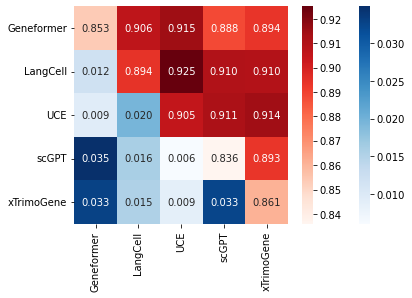

In [88]:
data = heatmap_df.values

mask_upper = np.triu(np.ones_like(data, dtype=bool))
mask_lower = np.tril(np.ones_like(data, dtype=bool),k=-1)

sns.heatmap(data, mask=mask_upper, cmap='Blues', annot=True, fmt=".3f")
sns.heatmap(data, mask=mask_lower, cmap='Reds', annot=True, fmt=".3f", xticklabels=heatmap_df.index, yticklabels=heatmap_df.index)

In [89]:
heatmap_df = result_grouped.pivot(index="model1", columns="model2", values="Macro F1")
for i, row in enumerate(heatmap_df.index):
    for j, col in enumerate(heatmap_df.columns):
        if i < j:  
            try:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==col)]["Macro F1"].values[0]
            except:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==col)&(result_grouped["model2"]==row)]["Macro F1"].values[0]
        elif i > j:
            try:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==col)]["f1_improve"].values[0]
            except:
                heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==col)&(result_grouped["model2"]==row)]["f1_improve"].values[0]
        else:
            heatmap_df.loc[row, col] = result_grouped[(result_grouped["model1"]==row)&(result_grouped["model2"]==row)]["Macro F1"].values[0]
heatmap_df = heatmap_df.astype(float)
heatmap_df

model2      Geneformer  LangCell       UCE     scGPT  xTrimoGene
model1                                                          
Geneformer    0.609915  0.707472  0.749135  0.684421    0.655154
LangCell     -0.011586  0.719058  0.778185  0.736492    0.699923
UCE          -0.028819  0.000231  0.777954  0.757997    0.724379
scGPT         0.038715  0.017434 -0.019957  0.645706    0.677662
xTrimoGene    0.045240 -0.019135 -0.053575  0.031956    0.607027

# CancerFinder (leave-one-tissue-out)

## Metrics

In [ ]:
result_dir = "/data2/zhuyiheng/wjl/scFoundation/SequencingCancerFinder/results"
model_list = ["X", "scVI", "scVI_integrated", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
xticklabels = ["Raw", "scVI", "scVI(wo batch)", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
tissue_list = ["Blood", "Brain", "Bone", "Eye"]

In [7]:
df_all = pd.DataFrame()
for tissue in tissue_list:
    df = pd.DataFrame()
    auroc_ls, auprc_ls = [], []
    for model in model_list:
        with open(os.path.join(result_dir, tissue, "ELU_log_0902", model, "dropout_0.1_decay_1e-06", "train_log_val.txt")) as f:
            res = f.readlines()[-2:]
            auroc, auprc = res[0].strip().split(": ")[1], res[1].strip().split(": ")[1]
            if model == "X":  
                auroc_base, auprc_base = float(auroc), float(auprc)
            else:
                auroc_ls.append(float(auroc)-auroc_base)
                auprc_ls.append(float(auprc)-auprc_base)
    df["Model"] = model_list[1:]
    df["AUROC"] = auroc_ls
    df["AUPRC"] = auprc_ls
    df["Tissue"] = tissue
    df_all = pd.concat([df_all, df], axis=0)
df_all

Model   AUROC   AUPRC Tissue
0             scVI -0.1271 -0.0797  Blood
1  scVI_integrated  0.1654  0.1651  Blood
2       Geneformer -0.0766 -0.0463  Blood
3            scGPT  0.2575  0.2571  Blood
4              UCE  0.1447  0.0785  Blood
5       xTrimoGene  0.0620  0.0073  Blood
6         LangCell -0.0042 -0.0072  Blood
0             scVI -0.3826 -0.1856  Brain
1  scVI_integrated -0.1258 -0.0975  Brain
2       Geneformer -0.1434 -0.0465  Brain
3            scGPT -0.1398 -0.0748  Brain
4              UCE  0.0099  0.0083  Brain
5       xTrimoGene  0.0371  0.0191  Brain
6         LangCell -0.1341 -0.0451  Brain
0             scVI  0.0612  0.0501   Bone
1  scVI_integrated  0.1656  0.1388   Bone
2       Geneformer  0.0678  0.0589   Bone
3            scGPT  0.2218  0.1765   Bone
4              UCE  0.0920  0.0627   Bone
5       xTrimoGene  0.1487  0.0821   Bone
6         LangCell  0.0527  0.0383   Bone
0             scVI -0.2009 -0.0916    Eye
1  scVI_integrated  0.0227  0.0128    Eye
2       Geneformer -0.0657 -0.0267    Eye
3            scGPT  0.0363  0.0162    Eye
4              UCE -0.0218 -0.0191    Eye
5       xTrimoGene  0.0200  0.0043    Eye
6         LangCell -0.1557 -0.0697    Eye

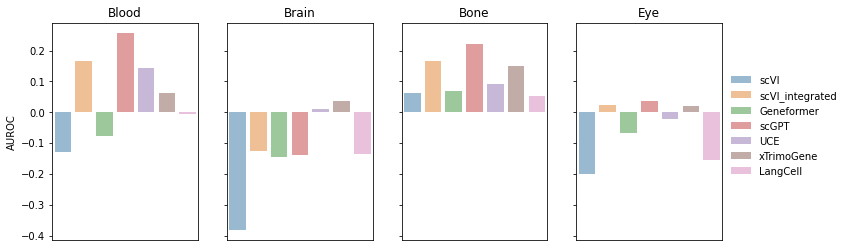

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)
for i, tissue in enumerate(tissue_list):
    if i == len(tissue_list) - 1: 
        sns.barplot(data=df_all[df_all["Tissue"]==tissue], x="Model", y="AUROC", hue="Model", ax=axes[i], alpha=0.5, legend="brief")
    else:
        sns.barplot(data=df_all[df_all["Tissue"]==tissue], x="Model", y="AUROC", hue="Model", ax=axes[i], alpha=0.5)
    axes[i].set_xticklabels([])
    axes[i].tick_params(bottom=False)
    axes[i].set_xlabel("")
    axes[i].set_title(tissue)
axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 0.8), ncol=1, title=None, frameon=False, fontsize=10)
plt.savefig("./figures/cancer_finder/auroc_all.png", dpi=300, bbox_inches='tight')

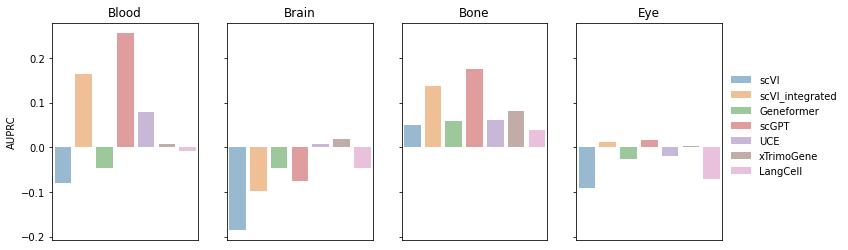

In [9]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4), sharex=True, sharey=True)
for i, tissue in enumerate(tissue_list):
    if i == len(tissue_list) - 1: 
        sns.barplot(data=df_all[df_all["Tissue"]==tissue], x="Model", y="AUPRC", hue="Model", ax=axes[i], alpha=0.5, legend="brief")
    else:
        sns.barplot(data=df_all[df_all["Tissue"]==tissue], x="Model", y="AUPRC", hue="Model", ax=axes[i], alpha=0.5)
    axes[i].set_xticklabels([])
    axes[i].tick_params(bottom=False)
    axes[i].set_xlabel("")
    axes[i].set_title(tissue)
axes[-1].legend(loc='upper left', bbox_to_anchor=(1, 0.8), ncol=1, title=None, frameon=False, fontsize=10)
plt.savefig("./figures/cancer_finder/auprc_all.png", dpi=300, bbox_inches='tight')

In [ ]:
sns.barplot(data=df, x="Model", y="AUPRC", hue="Model", alpha=0.5)
for index, value in enumerate(df["AUPRC"].values):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom', fontsize=8)
plt.title(f"Leave-one-tissue-out validation ({tissue})")
plt.ylim(0.6, 0.9)
plt.xticks(ticks=np.arange(len(model_list)),
           labels=["Raw", "scVI", "scVI(wo batch)", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"], 
           rotation=30)
plt.savefig(f"./figures/cancer_finder/{tissue}_auprc.png", dpi=300, bbox_inches='tight')

In [ ]:
sns.barplot(data=df, x="Model", y="AUROC", hue="Model", alpha=0.5)
for index, value in enumerate(df["AUROC"].values):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom')
plt.title(f"Leave-one-tissue-out validation ({tissue})")
plt.ylim(0.5, 0.8)
plt.xticks(ticks=np.arange(len(model_list)),
           labels=["Raw", "scVI", "scVI(wo batch)", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"], 
           rotation=30)
plt.savefig(f"./figures/cancer_finder/{tissue}_auroc.png", dpi=300, bbox_inches='tight')

In [81]:
tissue = "Blood"
df = pd.DataFrame()
auroc_ls, auprc_ls = [], []
for model in model_list:
    with open(os.path.join(result_dir, tissue, "ELU_log_0902", model, "dropout_0.1_decay_1e-06", "train_log_val.txt")) as f:
        res = f.readlines()[-2:]
        auroc, auprc = res[0].strip().split(": ")[1], res[1].strip().split(": ")[1]
        auroc_ls.append(float(auroc))
        auprc_ls.append(float(auprc))
df["Model"] = model_list
df["AUROC"] = auroc_ls
df["AUPRC"] = auprc_ls
df

Model   AUROC   AUPRC
0              X  0.5326  0.4597
1           scVI  0.4055  0.3800
2  scVI_wo_batch  0.5630  0.4860
3     Geneformer  0.4560  0.4134
4          scGPT  0.7901  0.7168
5            UCE  0.6773  0.5382
6     xTrimoGene  0.5946  0.4670
7       LangCell  0.5284  0.4525

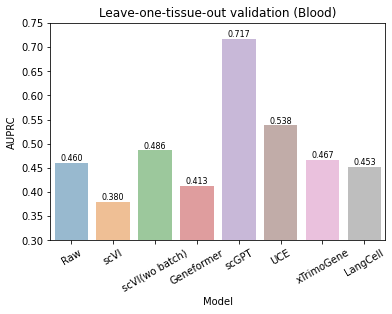

In [87]:
sns.barplot(data=df, x="Model", y="AUPRC", hue="Model", alpha=0.5)
for index, value in enumerate(df["AUPRC"].values):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom', fontsize=8)
plt.title(f"Leave-one-tissue-out validation ({tissue})")
plt.ylim(0.3, 0.75)
plt.xticks(ticks=np.arange(len(model_list)),
           labels=["Raw", "scVI", "scVI(wo batch)", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"], 
           rotation=30)
plt.savefig(f"./figures/cancer_finder/{tissue}_auprc.png", dpi=300)

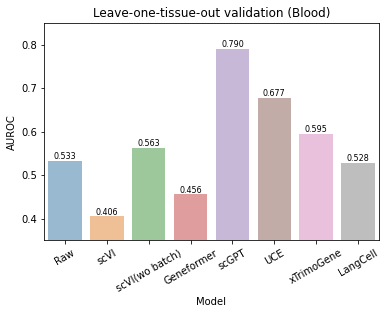

In [90]:
sns.barplot(data=df, x="Model", y="AUROC", hue="Model", alpha=0.5)
for index, value in enumerate(df["AUROC"].values):
    plt.text(index, value, f'{value:.3f}', ha='center', va='bottom', fontsize=8)
plt.title(f"Leave-one-tissue-out validation ({tissue})")
plt.ylim(0.35, 0.85)
plt.xticks(ticks=np.arange(len(model_list)),
           labels=["Raw", "scVI", "scVI(wo batch)", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"], 
           rotation=30)
plt.savefig(f"./figures/cancer_finder/{tissue}_auroc.png", dpi=300)

## Sankey plot of predictions 
threshold=0.5不一定合理？

In [149]:
tissue = "Bone"
adata = sc.read_h5ad(f"/data2/zhuyiheng/wjl/scFoundation/output/TISCH/{tissue}.h5ad")
adata

AnnData object with n_obs × n_vars = 24918 × 23996
    obs: 'UMAP_1', 'UMAP_2', 'Celltype (malignancy)', 'Celltype (major-lineage)', 'Celltype (minor-lineage)', 'Cluster', 'Amp_batch_ID', 'Experiment_ID', 'Group', 'Patient', 'Source', 'Age', 'Gender', 'Stage', 'Treatment', 'Response', 'label'
    obsm: 'Geneformer', 'LangCell', 'UCE', 'scGPT', 'scVI', 'scVI_wo_batch', 'xTrimoGene'

In [ ]:
result_dir = f"/data2/zhuyiheng/wjl/scFoundation/SequencingCancerFinder/results/{tissue}/ELU_log_0902"
for model in model_list:
    df = pd.read_csv(os.path.join(result_dir, model, "dropout_0.1_decay_1e-06", "predictions.csv"))
    df["layer2"] = df["y_pred"].map(lambda x: "Normal" if x<=0.5 else "Malignant")
    df["layer1"] = adata.obs["Celltype (major-lineage)"].values
    
    celltypes = list(set(df.layer1).union(set(df.layer2)))
    colors = setColorConf(len(celltypes), colors='Pastel1')
    cls_map = dict(zip(celltypes,colors))
    sky = Sankey(df.loc[:, ["layer1", "layer2"]], colorDict=cls_map, colorMode="global", stripColor='left')
    fig,ax = sky.plot(figSize=(3,5))
    plt.title(f"{tissue}_{model}")
    fig.savefig(f"./figures/cancer_finder/{tissue}_{model}_sankey.png",bbox_inches="tight",dpi=300)

## Roughness index (lower is better)

In [2]:
adata = sc.read_h5ad(f"/data2/zhuyiheng/wjl/scFoundation/output/TISCH/Blood.h5ad")
adata

AnnData object with n_obs × n_vars = 80278 × 12026
    obs: 'UMAP_1', 'UMAP_2', 'Celltype (malignancy)', 'Celltype (major-lineage)', 'Celltype (minor-lineage)', 'Cluster', 'Sample', 'Source', 'Patient', 'Age', 'Stage', 'label'
    obsm: 'Geneformer', 'LangCell', 'UCE', 'scGPT', 'scVI', 'scVI_integrated', 'scVI_wo_batch', 'xTrimoGene'

In [7]:
np.random.seed(42)
sample_pos = np.random.choice(adata.obs[adata.obs["label"]==1].index, 5000, replace=False)
sample_neg = np.random.choice(adata.obs[adata.obs["label"]==0].index, 5000, replace=False)

In [14]:
adata_subset = adata[adata.obs.index.isin(np.concatenate([sample_neg, sample_pos]))]
adata_subset

View of AnnData object with n_obs × n_vars = 10000 × 12026
    obs: 'UMAP_1', 'UMAP_2', 'Celltype (malignancy)', 'Celltype (major-lineage)', 'Celltype (minor-lineage)', 'Cluster', 'Sample', 'Source', 'Patient', 'Age', 'Stage', 'label'
    obsm: 'Geneformer', 'LangCell', 'UCE', 'scGPT', 'scVI', 'scVI_integrated', 'scVI_wo_batch', 'xTrimoGene'

In [22]:
model_list = ["X", "scVI", "scVI_integrated", "Geneformer", "scGPT", "UCE", "xTrimoGene", "LangCell"]
tissue_list = ['Blood', 'Brain', 'Bone', 'Eye']
rogi_df = pd.DataFrame()
rogi_df["model"] = model_list
# rogi_df["ROGI(Blood)"] = rogi_ls
for tissue in tissue_list:
    print(f"Calculating ROGI for the adata from tissue: {tissue}")
    rogi_ls = []
    adata = sc.read_h5ad(f"/data2/zhuyiheng/wjl/scFoundation/output/TISCH/{tissue}.h5ad")
    np.random.seed(42)
    sample_pos = np.random.choice(adata.obs[adata.obs["label"]==1].index, 5000, replace=False)
    sample_neg = np.random.choice(adata.obs[adata.obs["label"]==0].index, 5000, replace=False)
    adata_subset = adata[adata.obs.index.isin(np.concatenate([sample_neg, sample_pos]))]
    for model in model_list:
        if model == "X":
            ri = RoughnessIndex(X=adata_subset.X.toarray(), Y=adata_subset.obs['label'], metric='euclidean', verbose=False)        
        else:
            ri = RoughnessIndex(X=adata_subset.obsm[model], Y=adata_subset.obs['label'], metric='euclidean', verbose=False)        
        rogi = ri.compute_index(min_dt=0.01)
        rogi_ls.append(rogi)
    rogi_df[tissue] = rogi_ls

Calculating ROGI for the adata from tissue: Brain
Calculating ROGI for the adata from tissue: Bone
Calculating ROGI for the adata from tissue: Eye


In [26]:
# rogi_df.to_csv("./figures/cancer_finder_rogi.csv", index=False)
rogi_df = pd.read_csv("./figures/cancer_finder_rogi.csv")
rogi_df

model     Blood     Brain      Bone       Eye
0                X  0.770355  0.762785  0.835758  0.782243
1             scVI  0.789864  0.802537  0.795550  0.463888
2  scVI_integrated  0.707163  0.705058  0.710124  0.684163
3       Geneformer  0.787992  0.757671  0.817203  0.757572
4            scGPT  0.667712  0.735685  0.763718  0.686635
5              UCE  0.777661  0.542325  0.754043  0.742966
6     scFoundation  0.640183  0.728216  0.786117  0.523409
7         LangCell  0.751943  0.730729  0.751277  0.611584

In [79]:
xlim

(0.5, 4.5)

0.7703546380652198 0.5 1.5
0.762785109170301 1.5 2.5
0.8357579632127536 2.5 3.5
0.7822425979930858 3.5 4.5


([<matplotlib.axis.XTick at 0x7fe255925b50>,
 [Text(1, 0, 'Blood'),
  Text(2, 0, 'Brain'),
  Text(3, 0, 'Bone'),
  Text(4, 0, 'Eye')])

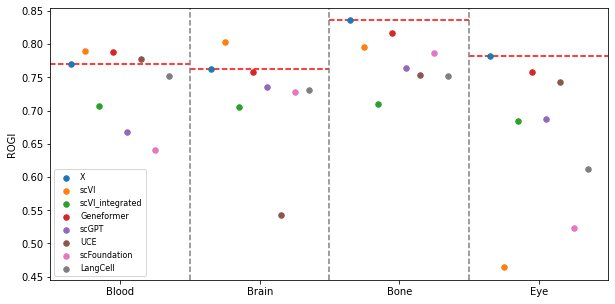

In [88]:
plt.figure(figsize=(10,5))
x = np.arange(1,5)
x_line = [0.5, 1.5, 2.5, 3.5, 4.5]
plt.xlim(0.5, 4.5)
width = 0.1
for i, model_name in enumerate(rogi_df["model"].unique()):
    color = f"C{i}"  # change the palette
    x_pos = x + i * width - 3.5 * width  # Adjust x position for each dataset
    y = rogi_df[rogi_df["model"]==model_name].values[0, 1:].tolist()
    # print(x_pos)
    plt.scatter(x_pos, y, s=30, color=color, alpha=1, label=model_name, zorder=2)
    if model_name == "X":
        x_min = x_line[:-1]
        x_max = x_line[1:]
        xlim = plt.gca().get_xlim()
        for y_, x_min_, x_max_ in zip(y, x_min, x_max):
            print(y_, x_min_, x_max_)
            x_min_ = (x_min_ - xlim[0]) / (xlim[1] - xlim[0])
            x_max_ = (x_max_ - xlim[0]) / (xlim[1] - xlim[0])
            plt.axhline(y=y_, xmin=x_min_, xmax=x_max_, ls="--", color="red",zorder=1)

plt.legend(fontsize=8)
for x in x_line[1:-1]:
    plt.axvline(x=x, ls="--", color="grey")   
plt.ylabel("ROGI")
plt.xticks(ticks=[1,2,3,4], labels=['Blood', 'Brain', 'Bone', 'Eye'])
# plt.savefig()

## UMAP visualization

In [1]:
tissue_list = ['Blood', 'Brain', 'Bone', 'Eye']
tissue_list

['Blood', 'Brain', 'Bone', 'Eye']

In [5]:
adata_list = []
for i, tissue in enumerate(tissue_list):
    adata = sc.read_h5ad(f"/data2/zhuyiheng/wjl/scFoundation/output/TISCH/{tissue}.h5ad")
    adata.obs["Tissue"] = tissue
    adata_list.append(adata)
adata_all = ad.concat(adata_list, join='outer')

In [173]:
adata_all.obs["Tissue"]

Cell
AML328-D113_ATTAAGCATTTC                 Blood
AML328-D113_GAAATGCCCCAT                 Blood
AML328-D113_GGGTGGCGAAAC                 Blood
AML328-D113_TAACTAAGCTAC                 Blood
AML328-D113_TCGTTAGTTATT                 Blood
                                         ...  
GSM4147100_UMM067L@TCGCGTTGTGTTAAGA-1      Eye
GSM4147100_UMM067L@TCTGGAACATTAACCG-1      Eye
GSM4147100_UMM067L@TGAGCATAGCGTGAAC-1      Eye
GSM4147100_UMM067L@TTAGGACCAAAGTCAA-1      Eye
GSM4147100_UMM067L@TTCCCAGAGTCAATAG-1      Eye
Name: Tissue, Length: 267390, dtype: object

In [ ]:
model = "scVI_integrated"
sc.pp.neighbors(adata_all, use_rep=model)
sc.tl.umap(adata_all)
fig = sc.pl.umap(adata_all, color=['Celltype (malignancy)', 'Tissue'], wspace=0.3, return_fig=True)
fig.savefig(f"./figures/cancer_finder/{model}_umap.png", dpi=300, bbox_inches='tight')

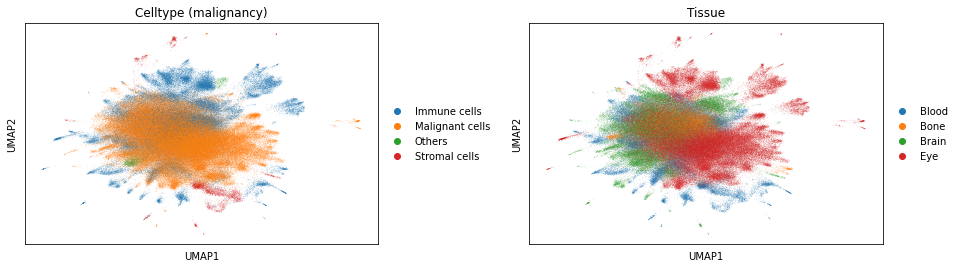

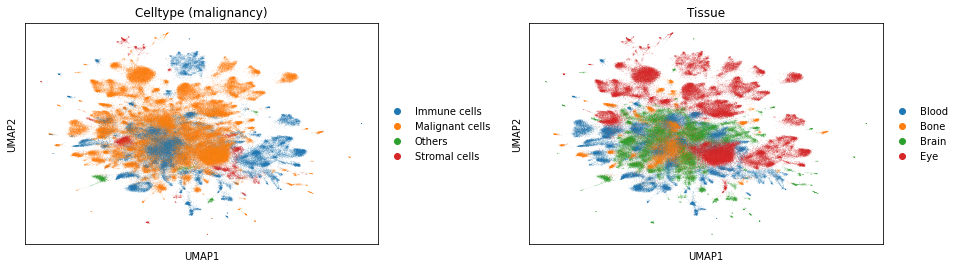

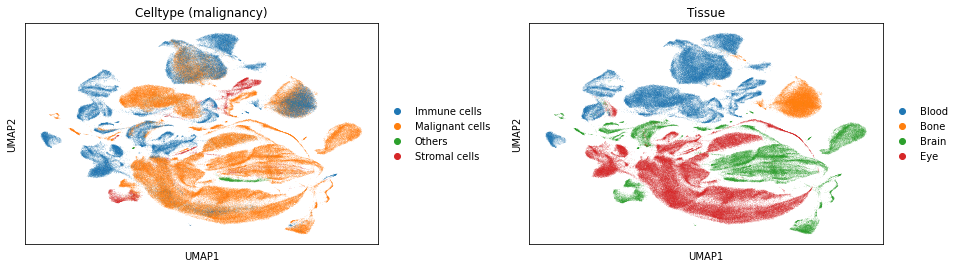

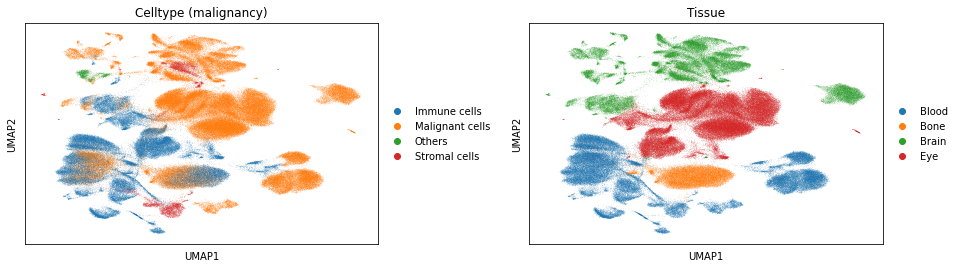

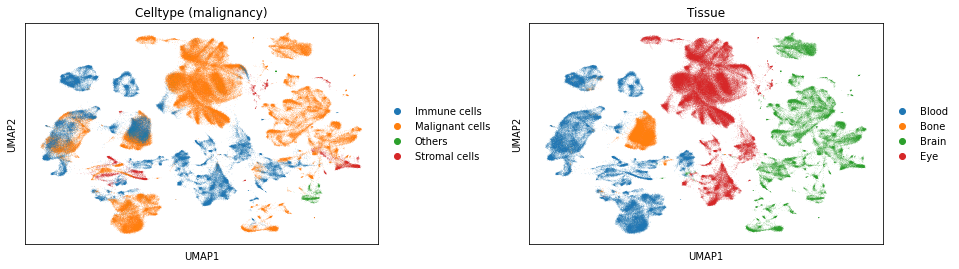

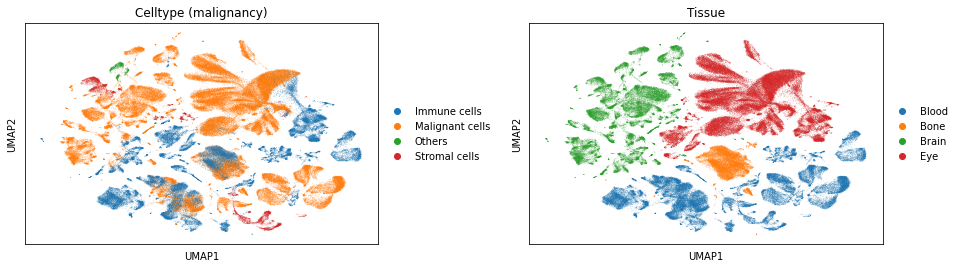

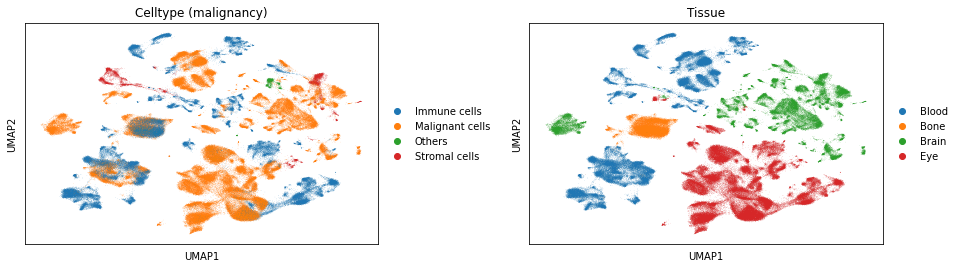

In [182]:
for model in model_list[1:]:
    sc.pp.neighbors(adata_all, use_rep=model)
    sc.tl.umap(adata_all)
    fig = sc.pl.umap(adata_all, color=['Celltype (malignancy)', 'Tissue'], wspace=0.3, return_fig=True)
    fig.savefig(f"./figures/cancer_finder/{model}_umap.png", dpi=300, bbox_inches='tight')

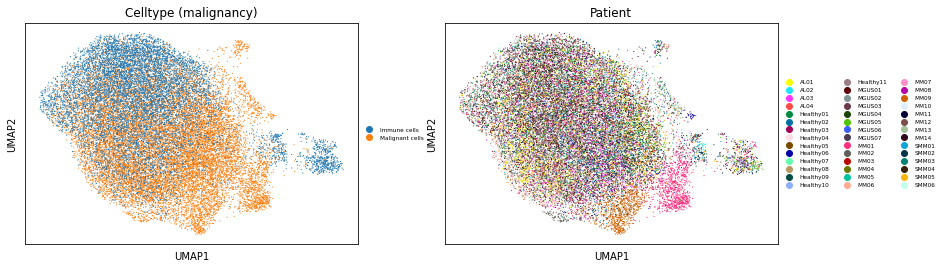

In [157]:
sc.pp.neighbors(adata, use_rep='scGPT')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Celltype (malignancy)', 'Patient'],legend_fontsize ='xx-small',size=5,legend_fontweight='light')

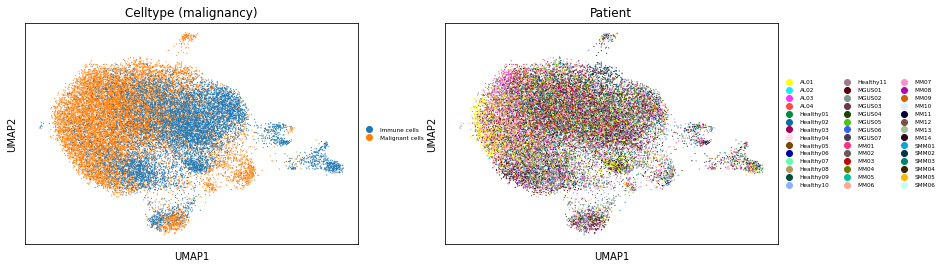

In [158]:
sc.pp.neighbors(adata, use_rep='scVI')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Celltype (malignancy)', 'Patient'],legend_fontsize ='xx-small',size=5,legend_fontweight='light')

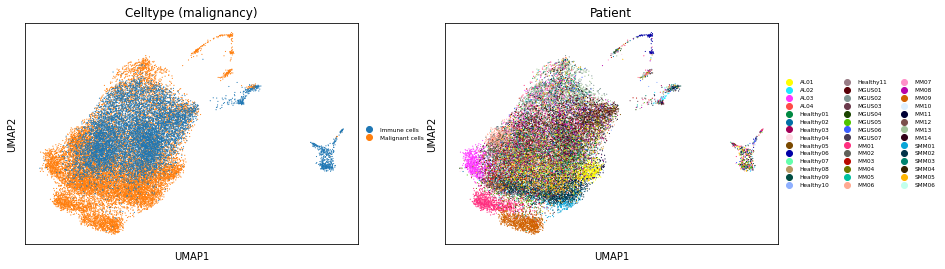

In [159]:
sc.pp.neighbors(adata, use_rep='UCE')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Celltype (malignancy)', 'Patient'],legend_fontsize ='xx-small',size=5,legend_fontweight='light')

# Drug sensitivity

In [4]:
result = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/results/drug_sensitivity.csv", delimiter="\t")
result.head()

Drug   AUROC   AUPRC         Model
0      Sorafenib  0.8400  0.8400  scFoundation
1     NVP-TAE684  0.8400  0.8737  scFoundation
2  PLX4720_451Lu  0.6600  0.6755  scFoundation
3      Etoposide  0.6800  0.6227  scFoundation
4      Sorafenib  0.7819  0.7393         scGPT

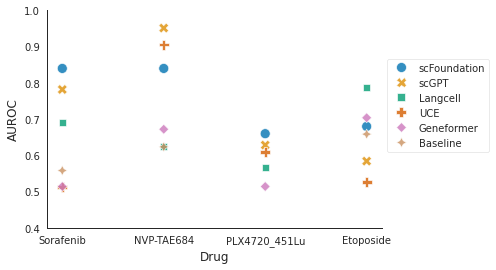

In [61]:
sns.scatterplot(result, x="Drug", y="AUROC", style="Model", hue="Model", s=100, palette="colorblind", alpha=0.8)
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim(0.4, 1)
ax.legend(loc="upper left", ncol=1, title=None, frameon=True, bbox_to_anchor=(1, 0.8))
plt.savefig("figures/drug_sensitivity/drug_auroc.png", dpi=300, bbox_inches='tight')

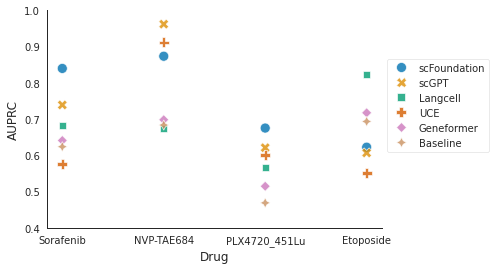

In [60]:
sns.set_style('white')
# plt.style.use('ggplot')
sns.scatterplot(result, x="Drug", y="AUPRC", style="Model", hue="Model", s=100, palette="colorblind", alpha=0.8)
sns.despine(top=True, right=True, left=False, bottom=False)
ax = plt.gca()
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
ax.set_ylim(0.4, 1)
ax.legend(loc="upper left", ncol=1, title=None, frameon=True, bbox_to_anchor=(1, 0.8))
plt.savefig("figures/drug_sensitivity/drug_auprc.png", dpi=300, bbox_inches='tight')

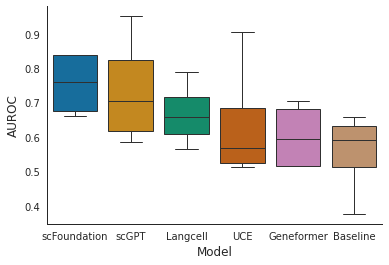

In [59]:
sns.boxplot(result, x="Model", y="AUROC", hue="Model", palette="colorblind", width=0.8)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.savefig("figures/drug_sensitivity/average_auroc.png", dpi=300, bbox_inches='tight')

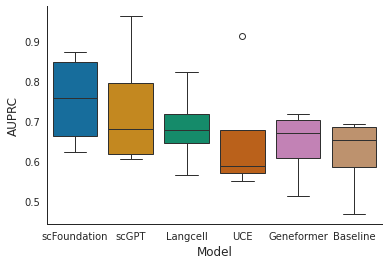

In [58]:
sns.boxplot(result, x="Model", y="AUPRC", hue="Model", palette="colorblind", width=0.8)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.savefig("figures/drug_sensitivity/average_auprc.png", dpi=300, bbox_inches='tight')

# General figures

## Modal size & training data size

In [3]:
df = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/figures/model_data_size.txt",sep="\t")
df.head()

Model  Model parameters (M)  Training data (M)
0       scGPT                    50               33.0
1  Geneformer                    40               30.0
2         UCE                   650               36.0
3  xTrimoGene                   100               50.0
4    LangCell                    40               27.5

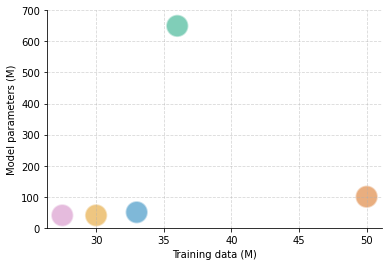

In [32]:
fig, ax = plt.subplots()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.scatterplot(df, x="Training data (M)", y="Model parameters (M)", s=500, hue="Model", 
                ax=ax, palette="colorblind", alpha=0.5, legend=False)
# ax.tick_params(top=False, labeltop=False, bottom=True, labelbottom=True)
plt.grid(ls="--",alpha=0.5)
plt.ylim(0,700)
plt.savefig("./figures/model_info/model_data_size.png", dpi=300)

## Computational resource

In [40]:
df = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/figures/computation_cost.txt",sep="\t")
df.head()

Model  Total GPU memory (MB)  GPU memory (MB)  GPU memory (GB)  \
0        scVI                    NaN              NaN              NaN   
1  Geneformer                 1306.0            982.0              1.0   
2       scGPT                 3680.0           3356.0              3.3   
3    LangCell                 1724.0           1400.0              1.4   
4         UCE                 6760.0           6436.0              6.3   

   Batch size  
0           1  
1           1  
2           1  
3           1  
4           1

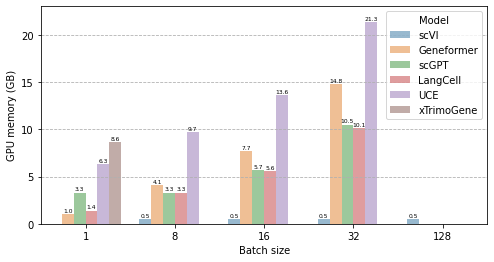

In [44]:
plt.figure(figsize=(8,4))
ax = sns.barplot(df, x="Batch size", y="GPU memory (GB)", hue="Model", alpha=0.5, width=0.8)
plt.grid(axis="y", ls="--")
for p in ax.patches:
    if p.get_height() > 0:
        ax.text(p.get_x() + p.get_width() / 2, p.get_height()+0.1, 
                f'{p.get_height():.1f}', 
                ha='center', va='bottom', fontdict={"fontsize":6})
ax.set_ylim(0, 23)
plt.savefig("./figures/gpu_memory.png",dpi=300)

In [46]:
df = pd.read_csv("/data2/zhuyiheng/wjl/scFoundation/figures/computation_time.txt",sep="\t")
df

Model  Time (s)  Batch size
0        scVI     625.6         128
1  Geneformer     556.1          32
2       scGPT      91.7          32
3    LangCell     487.5          32
4         UCE    1889.7          32
5  xTrimoGene    4247.1           1

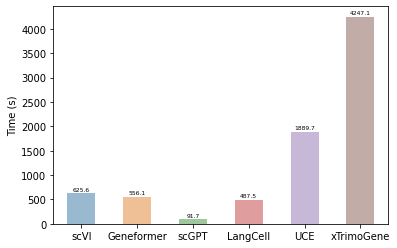

In [55]:
# plt.figure(figsize=(8,4))
ax = sns.barplot(df, x="Model", y="Time (s)", hue="Model", alpha=0.5, width=0.5, zorder=1)
# plt.grid(axis="x", ls="--", zorder=0)
for p in ax.patches:
    if p.get_height() > 0:
        ax.text(p.get_x() + p.get_width() / 2, p.get_height()+30, 
                f'{p.get_height():.1f}', 
                ha='center', va='bottom', fontdict={"fontsize":6})
ax.set_xlabel("")
plt.savefig("./figures/pancreas_extract_emb_time.png",dpi=300)

## Evaluation metrics